### Optimal Transport

#### Embeddings

In [54]:
from Process_Data.Datasets.KaldiDataset import ScriptTrainDataset
from Light.dataset import Sampler_Loaders, SubScriptDatasets

import os
from hyperpyyaml import load_hyperpyyaml
from Light.model import SpeakerLoss
from geomloss import SamplesLoss

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
import pandas as pd
import numpy as np

from TrainAndTest.train_egs.train_dist import all_seed

In [2]:
torch.cuda.set_device(1)
device = 'cuda:1'

In [3]:
data_root = '/home/yangwenhao/project/SpeakerVerification-pytorch'

In [531]:
# train_config = 'data/vox2/model.2024.01.29.yaml'
# train_config = 'data/vox1/model.2024.03.15.yaml'
train_config = data_root + '/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshot3_random5/1234/model.2024.04.25.yaml'

In [532]:
with open(train_config, 'r') as f:
    config_args = load_hyperpyyaml(f)

In [533]:
if 'embedding_model' in config_args:
    model = config_args['embedding_model']

if 'classifier' in config_args:
    model.classifier = config_args['classifier']
# else:
#     if not isinstance(model.classifier, Classifier):
#         create_classifier(model, **config_args)

In [534]:
model.loss = SpeakerLoss(config_args)
model = model.cuda()

In [536]:
# resume = 'Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox2/wave_fb80_dist_aug53/1234/checkpoint_3.pth'
epoch = 'avg3' #'avg3' #
# resume = 'Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53/1234/checkpoint_{}.pth'.format(epoch)
resume = f'Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshot3_random5/1234/checkpoint_{epoch}.pth'

checkpoint = torch.load(os.path.join(data_root, resume), map_location='cpu') #, map_location='cuda:1')

start_epoch = checkpoint['epoch']
checkpoint_state_dict = checkpoint['state_dict']
if isinstance(checkpoint_state_dict, tuple):
    checkpoint_state_dict = checkpoint_state_dict[0]

filtered = {k: v for k, v in checkpoint_state_dict.items(
) if 'num_batches_tracked' not in k}

# filtered = {k: v for k, v in checkpoint['state_dict'].items() if 'num_batches_tracked' not in k}
if list(filtered.keys())[0].startswith('module'):
    new_state_dict = OrderedDict()
    for k, v in filtered.items():
        # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
        new_state_dict[k[7:]] = v  # 新字典的key值对应的value为一一对应的值。

    model.load_state_dict(new_state_dict)
else:
    model_dict = model.state_dict()
    model_dict.update(filtered)
    model.load_state_dict(model_dict)

In [537]:
config_args['verbose'] = 1
config_args['save_data_dir'] = data_root + '/' + config_args['save_data_dir']

In [538]:
train_dir, valid_dir, train_extract_dir = SubScriptDatasets(config_args)

==> There are 1211 speakers in Dataset.
    There are 148642 utterances in Trainset, where 0 utterances are removed.
    Spliting 2422 utterances for Validation.
    Loading training samples from:
	 /home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst/train.csv 
    Sample 386317 segments for speakers.
Examples uids:  ['id10001-J9lHsKG98U8-00015', 'id10001-J9lHsKG98U8-00024', 'id10002-RLKKsYiCMvc-00006', 'id10002-eNc4LrrvV80-00013']


In [547]:
save_csv = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshot3_random/Sample-RandomSelect-10-sample-0-balance-1234.csv'
train_utts = pd.read_csv(save_csv).to_numpy().tolist()

In [548]:
top_examples = np.array([t[0] for t in train_utts])

In [550]:
subtrain_dir = torch.utils.data.Subset(train_dir, top_examples)

In [41]:
labels = [u for u,s,e in train_dir.base_utts]
labels = [u.split('-')[0] for u in labels]
labels = np.array([train_dir.spk_to_idx[l] for l in labels])

In [551]:
batch_size = config_args['batch_size'] #// 2
num_classes = config_args['num_classes']

# batch_loader = torch.utils.data.DataLoader(
#     train_dir, batch_size=batch_size, num_workers=config_args['nj'])
# sample_num = len(train_dir)

batch_loader = torch.utils.data.DataLoader(
    subtrain_dir, batch_size=batch_size, num_workers=config_args['nj'])
sample_num = len(subtrain_dir)

In [10]:
config_args['num_classes']

1211

In [552]:
embedding_dim = config_args['embedding_size']
# embeddings = torch.zeros([len(train_dir), embedding_dim], requires_grad=False)
# grads = torch.zeros([len(train_dir), embedding_dim], requires_grad=False)
# logits = torch.zeros([len(train_dir), config_args['num_classes']], requires_grad=False)
# logits_grads = torch.zeros([len(train_dir), config_args['num_classes']], requires_grad=False)

embeddings = torch.zeros([len(subtrain_dir), embedding_dim], requires_grad=False)
logits = torch.zeros([len(subtrain_dir), config_args['num_classes']], requires_grad=False)

In [253]:
pbar = tqdm(enumerate(batch_loader), ncols=50, total=len(batch_loader))
model.eval()

losses = []
with torch.no_grad():
    for i, (data, label) in pbar:
        
        logit, embedding = model(data.to(device))
        model.loss.xe_criterion.reduction = 'none'
        
        loss = model.loss.xe_criterion(logit, label.to(device))        
        # loss, _ = model.loss(logit, label.to(device), batch_weight=None, other=True)
        # print(loss.shape, model.loss.xe_criterion.ce.reduction)
        # break
        losses.append(loss.detach().cpu())

losses = torch.cat(losses, dim=0)

100%|█████████| 4025/4025 [02:59<00:00, 22.39it/s]


In [254]:
losses.shape, len(train_dir)

# 386318

(torch.Size([386317]), 386317)

In [255]:
torch.save({'losses': losses}, 'data/vox1_inst/losses.pth')

In [ ]:
losses

In [ ]:
losses.shape

In [554]:
pbar = tqdm(enumerate(batch_loader), ncols=50, total=len(batch_loader))
model.eval()

with torch.no_grad():
    for i, (data, label) in pbar:

        logit, embedding = model(data.to(device))
        loss, _ = model.loss(logit, label.to(device), batch_weight=None, other=True)
        
        # embedding_grad, logits_grad = torch.

        embedding = embedding.detach().cpu()
        logit = logit.detach().cpu()

        embeddings[i * batch_size:min((i+1) * batch_size, sample_num)] += embedding
        logits[i * batch_size:min((i+1) * batch_size, sample_num)] += logit

        # break

100%|███████████| 403/403 [00:21<00:00, 18.58it/s]


In [29]:
# torch.save({'embeddings': embeddings}, 'data/vox2/embeddings.pth')
torch.save({'embeddings': embeddings}, 'data/vox1_inst/embeddings.pth')
torch.save({'logits': logits}, 'data/vox1_inst/logits.pth')

In [36]:
save_path = 'data/vox1_inst_avg3' #data/vox1_inst
# embeddings = torch.load('data/vox2/embeddings.pth')['embeddings']
# grads = torch.load('data/vox1_inst/grads.pth')['grads']
embeddings = torch.load(save_path + '/embeddings.pth')['embeddings']
logits = torch.load(save_path + '/logits.pth')['logits']

In [38]:
embeddings.shape

torch.Size([386317, 192])

In [33]:
from Process_Data.Datasets.SelectDataset import Dist_loss

import numpy as np

In [20]:
batch_size = 96

In [21]:
device = torch.device('cuda:1')

### Optimal Tranport Sinkorn Algorithm

In [42]:
new_data = []
for i in np.arange(num_classes):
    this_idx = labels == i
    new_data.append(embeddings[this_idx].clone().detach().reshape(-1, embeddings.shape[-1]))

In [43]:
new_data_mean = embeddings.mean(0, keepdim=True)
new_data_norm = torch.norm(embeddings, 2, 1)[:, None]

num = 0
new_data_indices = [0]
class_indices = []
for i in range(len(new_data)):
    num += len(new_data[i])
    new_data_indices.append(num)
    class_indices.append(len(new_data[i])) 

In [44]:
data_mus = []
for i in range(len(new_data)):
    new_data[i] = ((embeddings[new_data_indices[i]:new_data_indices[i+1],:] - new_data_mean)/new_data_norm[new_data_indices[i]:new_data_indices[i+1],:]) #(10000, 1)
    data_mus.append(new_data[i].mean(0).unsqueeze(0))
data_mus = torch.cat(data_mus, dim=0)  

datas = torch.cat(new_data, dim=0).unsqueeze(0)
mus = data_mus.unsqueeze(0) 

In [45]:
datas.shape

torch.Size([1, 386317, 192])

In [46]:
def compute_optimal_transport(M, r, c,
                              epsilon=1e-6, lam=4):    
    r = r.cuda()
    c = c.cuda()
    n_runs, n, m = M.shape  
    P = torch.exp(- lam * M)
    P /= P.view((n_runs, -1)).sum(1).unsqueeze(1).unsqueeze(1)                        
    u = torch.zeros(n_runs, n).cuda()
    maxiters = 1000
    iters = 1
    # normalize this matrix
    while torch.max(torch.abs(u - P.sum(2))) > epsilon:
        u = P.sum(2)
        P *= (r / u).view((n_runs, -1, 1))
        P *= (c / P.sum(1)).view((n_runs, 1, -1))
        if iters == maxiters:
            break
        iters = iters + 1
        
    return P, P*M 

#### Sinkhorn Cosine Logits

In [234]:
# define cost matrix
all_samples = datas.size()[1]
num_class = data_mus.size()[0]

partial = 250

dist_score = 'logits'
lam     = 4
repeats = 20

# for seed in [1233, 1234, 1235, 1236, 1237]:
for seed in [1233]:

    all_seed(seed)
    
    scores = []
    for m in tqdm(range(repeats), ncols=50):
        classes_idx = np.arange(num_classes)
        np.random.shuffle(classes_idx)
        
        for j in range(int(np.ceil(num_classes/partial))):
            start_class = j*partial
            end_class   = (j+1)*partial
            
            if m == 0:
                
                start_idx  = int(np.sum(class_indices[:start_class]))
                end_idx    = int(np.sum(class_indices[:end_class]))

                if dist_score == 'mean':
                    dist = torch.zeros((1,np.sum(class_indices[start_class:end_class]), partial)).cuda()
                    dist = (datas[:,start_idx:end_idx].unsqueeze(2) - mus[:, start_class:end_class].unsqueeze(1)).norm(dim=3).pow(2)
                elif dist_score == 'logits':
                    dist = 1 - logits[start_idx:end_idx, start_class:end_class].clone().unsqueeze(0)

                num_samples = np.array(class_indices[start_class:end_class])
                sample_idx = np.arange(start_idx, end_idx)
                # print(start_idx, end_idx)

            else:
                # class_idx = np.random.choice(np.arange(num_classes), size=partial, replace=False)
                class_idx = classes_idx[start_class:end_class]
                dist = [logits[new_data_indices[n]:new_data_indices[n+1]].clone() for n in class_idx]

                sample_idx = np.concatenate([np.arange(new_data_indices[n],
                                                       new_data_indices[n+1]) for n in class_idx])

                dist = torch.cat(dist, dim=0)
                dist = 1 - dist[:, torch.LongTensor(class_idx)].unsqueeze(0)

                num_samples = np.array([class_indices[n] for n in class_idx])

            a = np.ones(dist.shape[1]) #/ dist.shape[1]
            b = np.ones(dist.shape[-1]) * num_samples #/ dist.shape[-1]
            P, T = compute_optimal_transport(dist.cuda(), 
                                             torch.tensor(a).unsqueeze(0),
                                             torch.tensor(b).unsqueeze(0),
                                             lam=lam)

            T = T.cpu().norm(dim=2).pow(2)[0] #[1:]

            scores.append((T, sample_idx))
    
    t_scores = torch.zeros(all_samples)
    t_counts = torch.ones(all_samples)

    for T,sample_idx in scores:
        # sample_idx = torch
        t_scores[sample_idx] = t_scores[sample_idx] + T
        t_counts[sample_idx] = t_counts[sample_idx] + 1

    t_scores = t_scores/t_counts
#     save_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshotavg3_lr_Sinkhorn_logits'
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
    
#     train_utts = pd.DataFrame(train_dir.base_utts, columns=['uid', 'start', 'end'])
#     train_utts['scores'] = t_scores.numpy()    
#     train_utts.to_csv(os.path.join(save_dir, f'subtrain.{seed}.scores.csv'),
#                       index=None)

100%|█████████████| 20/20 [00:22<00:00,  1.14s/it]


In [235]:
t_scores = torch.zeros(all_samples)
t_counts = torch.ones(all_samples)

for T,sample_idx in scores:
    # sample_idx = torch
    t_scores[sample_idx] = t_scores[sample_idx] + T
    t_counts[sample_idx] = t_counts[sample_idx] + 1
    
t_scores = t_scores/t_counts

In [210]:
t_counts[:10]

tensor([21., 21., 21., 21., 21., 21., 21., 21., 21., 21.])

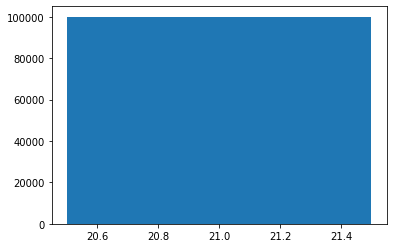

In [208]:
# _ = plt.hist((t_scores/t_counts)[:100000], bins='auto', cumulative=False)
_ = plt.hist(t_counts[:100000], bins='auto', cumulative=False)


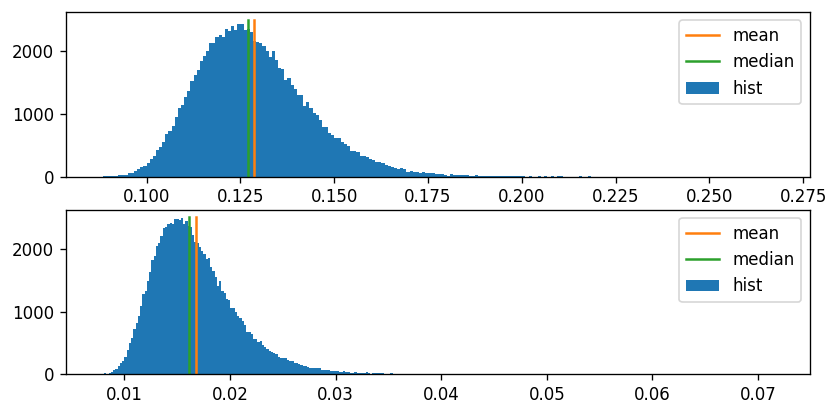

In [205]:
plt.figure(figsize=(8, 4), dpi=120)

# plt.figure(figsize=(8, 12), dpi=120)

for i,j in enumerate([0.5, 1]):
    plt.subplot(2,1,i+1)
    t = t_scores[:100000]
    t = np.power(t, j)
    _ = plt.hist(t, bins='auto', cumulative=False)

    plt.plot([t.mean()]*2, [0, 2500])
    plt.plot([np.median(t)]*2, [0, 2500])
# _ = plt.hist((t_scores/t_counts)[:100000], bins='auto', cumulative=False)
# _ = plt.hist(t_counts[:100000], bins='auto', cumulative=False)

# plt.scatter(t_counts[:100000], t_scores[:100000])
    plt.legend(['mean', 'median', 'hist', ])

In [256]:
import ot

In [298]:
this_idx = vectors_lab == 0
xa = torch.tensor(c_embedded[this_idx])
# xa = xa/xa.norm(dim=1).reshape(-1,1)

this_idx = vectors_lab == 1
xb = torch.tensor(c_embedded[this_idx])
# xb = xb/xb.norm(dim=1).reshape(-1,1)

# M = (1 - xa.matmul(xb.T)) / 2

In [335]:
this_idx = vectors_lab == 0
xa = torch.tensor(vectors[this_idx])
xa = xa/xa.norm(dim=1).reshape(-1,1)

this_idx = vectors_lab == 1
xb = torch.tensor(vectors[this_idx])
xb = xb/xb.norm(dim=1).reshape(-1,1)

M = (1 - xa.matmul(xb.T)) / 2

<ipython-input-335-6baae0f77693>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xa = torch.tensor(vectors[this_idx])
<ipython-input-335-6baae0f77693>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(vectors[this_idx])


### Alignment of Metric Learning

In [368]:
vn = vectors / vectors.norm(dim=1).unsqueeze(1)

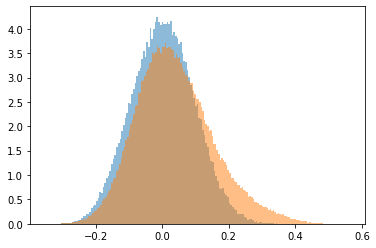

In [410]:
_ = plt.hist(x1.reshape(-1), bins='auto', density=True, alpha=0.5)
_ = plt.hist(x2.reshape(-1), bins='auto', density=True, alpha=0.5)

In [411]:
x1 = vn1.matmul(vn2.T).reshape(-1,1).numpy()
x2 = vn1.matmul(vn3.T).reshape(-1,1).numpy()

In [418]:
x1 = vn2.matmul(vn1.T).numpy()
x2 = vn3.matmul(vn1.T).numpy()

In [419]:
x1.shape

(653, 202)

In [431]:
M = ot.dist(x1, x2, 'euclidean')
M /= M.max()
M = torch.tensor(M).unsqueeze(0)

In [432]:
a = np.ones(M.shape[1]) #/ dist.shape[1]
b = np.ones(M.shape[-1]) #* num_samples #/ dist.shape[-1]
P, T = compute_optimal_transport(M.cuda(), 
                             torch.tensor(a).unsqueeze(0),
                             torch.tensor(b).unsqueeze(0),
                             lam=4)

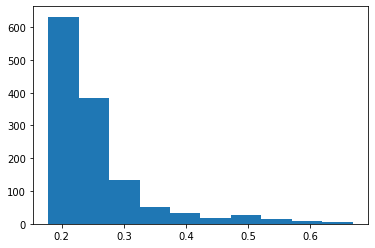

In [437]:
_=plt.hist(T.sum(dim=1).squeeze().cpu())

In [441]:
x1.shape

(653, 202)

In [442]:
torch.argsort(T.sum(dim=2).squeeze())[-20:]

tensor([191, 314, 192, 294,  90,  11, 232, 303, 210,  65, 170, 252,  70,  63,
         19,  80, 180, 241,  66,  77], device='cuda:1')

In [444]:
s = T.sum(dim=2).squeeze().cpu().numpy()

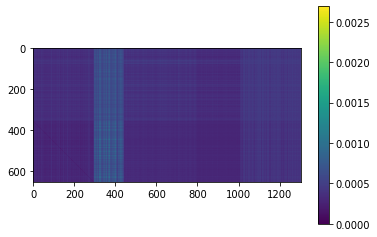

In [490]:
plt.imshow(T.cpu().squeeze())
plt.colorbar()

#### Negative-Positive Aligment

In [500]:
sublabels = np.arange(4)
optimize_vector = 'embeddings' #'logits'

total_vectors1 = []
total_label1 = []
for s in sublabels:
    sidx = labels == s
    
    if optimize_vector == 'embeddings':
        feats = embeddings[sidx].clone()
    elif optimize_vector == 'logits':
        feats = logits[sidx].clone()
    elif optimize_vector == 'grads':
        feats = grads[sidx].clone()
        
    total_vectors1.append(feats)
    total_label1.append([s]*len(feats))
        
total_vectors1 = torch.cat(total_vectors1, dim=0)
total_label1 = torch.LongTensor(np.concatenate(total_label1))

In [496]:
v4 = total_vectors1 / total_vectors1.norm(dim=1).unsqueeze(1)

In [497]:
x4 = v4.matmul(v4.T)

In [503]:
l4 = total_label1.reshape(-1, 1).matmul(total_label1.reshape(1, -1))

In [507]:
total_indices = [0]
for s in sublabels:
    sidx = labels == s
    total_indices.append(len(labels[sidx])+total_indices[-1])

In [516]:
lable4 = torch.zeros_like(x4)

In [515]:
total_indices

[0, 202, 480, 837, 1133]

In [517]:
for i in range(len(total_indices[:-1])):
    lable4[total_indices[i]:total_indices[i+1], total_indices[i]:total_indices[i+1],] += 1

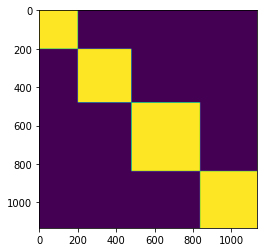

In [518]:
plt.imshow(lable4)

In [519]:
neg_l = lable4.reshape(-1) == 0
neg_p = lable4.reshape(-1) == 1


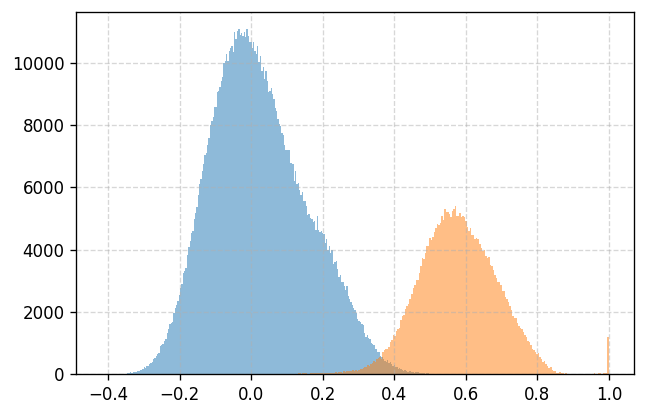

In [528]:
plt.figure(figsize=(6, 4), dpi=120)

# _ = plt.hist(x4.reshape(-1)[neg_l], bins='auto', density=True, alpha=0.5)
# _ = plt.hist(x4.reshape(-1)[neg_p], bins='auto', density=True, alpha=0.5)

_ = plt.hist(x4.reshape(-1)[neg_l], bins='auto', alpha=0.5)
_ = plt.hist(x4.reshape(-1)[neg_p], bins='auto', alpha=0.5)
plt.grid(linestyle='--', alpha=0.5, zorder=-1)

In [555]:
sublabels = np.arange(4)
optimize_vector = 'embeddings' #'logits'

total_vectors1 = []
total_label1 = []
sub_labels = labels[top_examples]
for s in sublabels:
    sidx = sub_labels == s
    
    if optimize_vector == 'embeddings':
        feats = embeddings[sidx].clone()
    elif optimize_vector == 'logits':
        feats = logits[sidx].clone()
    elif optimize_vector == 'grads':
        feats = grads[sidx].clone()
        
    total_vectors1.append(feats)
    total_label1.append([s]*len(feats))
        
total_vectors1 = torch.cat(total_vectors1, dim=0)
total_label1 = torch.LongTensor(np.concatenate(total_label1))

In [558]:
v5 = total_vectors1 / total_vectors1.norm(dim=1).unsqueeze(1)

In [559]:
x5 = v5.matmul(v5.T)
l5 = total_label1.reshape(-1, 1).matmul(total_label1.reshape(1, -1))

total_indices = [0]
for s in sublabels:
    sidx = sub_labels == s
    total_indices.append(len(sub_labels[sidx])+total_indices[-1])
    
lable5 = torch.zeros_like(x5)
for i in range(len(total_indices[:-1])):
    lable5[total_indices[i]:total_indices[i+1], total_indices[i]:total_indices[i+1],] += 1

neg_l2 = lable5.reshape(-1) == 0
neg_p2 = lable5.reshape(-1) == 1

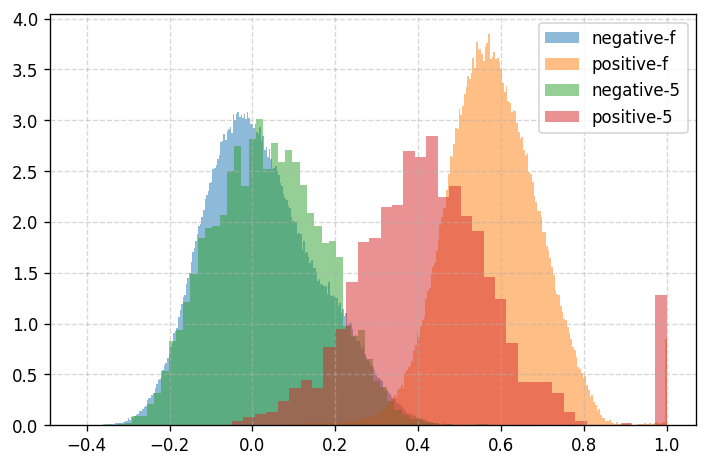

In [567]:
plt.figure(figsize=(6, 4), dpi=120)

_ = plt.hist(x4.reshape(-1)[neg_l], bins='auto', alpha=0.5, density=True)
_ = plt.hist(x4.reshape(-1)[neg_p], bins='auto', alpha=0.5, density=True)

_ = plt.hist(x5.reshape(-1)[neg_l2], bins='auto', alpha=0.5, density=True)
_ = plt.hist(x5.reshape(-1)[neg_p2], bins='auto', alpha=0.5, density=True)

plt.legend(['negative-f', 'positive-f', 'negative-5', 'positive-5'])
plt.grid(linestyle='--', alpha=0.5, zorder=-1)
plt.tight_layout()
plt.savefig('data/vox1_inst_avg3/full_5_metric.png')

In [ ]:
l4 = total_label1.reshape(-1, 1).matmul(total_label1.reshape(1, -1))

In [400]:
sublabels = np.arange(1)
optimize_vector = 'embeddings' #'logits'

total_vectors1 = []
for s in sublabels:
    sidx = labels == s

    if optimize_vector == 'embeddings':
        feats = embeddings[sidx].clone()
    elif optimize_vector == 'logits':
        feats = logits[sidx].clone()
    elif optimize_vector == 'grads':
        feats = grads[sidx].clone()
        
    total_vectors1.append(feats)
        
total_vectors1 = torch.cat(total_vectors1, dim=0)

sublabels = np.arange(2, 4)
# optimize_vector = 'embeddings' #'logits'

total_vectors2 = []
for s in sublabels:
    sidx = labels == s

    if optimize_vector == 'embeddings':
        feats = embeddings[sidx].clone()
    elif optimize_vector == 'logits':
        feats = logits[sidx].clone()
    elif optimize_vector == 'grads':
        feats = grads[sidx].clone()
        
    total_vectors2.append(feats)
        
total_vectors2 = torch.cat(total_vectors2, dim=0)


sublabels = np.arange(3, 8)
# optimize_vector = 'embeddings' #'logits'

total_vectors3 = []
for s in sublabels:
    sidx = labels == s

    if optimize_vector == 'embeddings':
        feats = embeddings[sidx].clone()
    elif optimize_vector == 'logits':
        feats = logits[sidx].clone()
    elif optimize_vector == 'grads':
        feats = grads[sidx].clone()
        
    total_vectors3.append(feats)
        
total_vectors3 = torch.cat(total_vectors3, dim=0)

In [407]:
vn1 = total_vectors1 / total_vectors1.norm(dim=1).unsqueeze(1)
vn2 = total_vectors2 / total_vectors2.norm(dim=1).unsqueeze(1)
vn3 = total_vectors3 / total_vectors3.norm(dim=1).unsqueeze(1)

In [ ]:
# M.reshape()

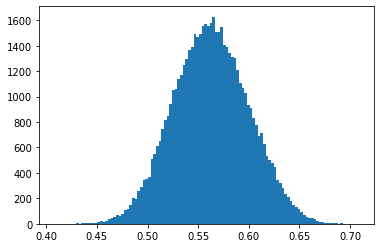

In [337]:
_ = plt.hist(M.reshape(-1), bins='auto')

In [269]:
a = np.ones(len(xa))/len(xa)
b = np.ones(len(xb))/len(xb)
mass = 0.7

In [338]:
partial_ot = ot.partial.partial_wasserstein(a, b, M.numpy(), m=mass)

In [365]:
M.shape

torch.Size([202, 278])

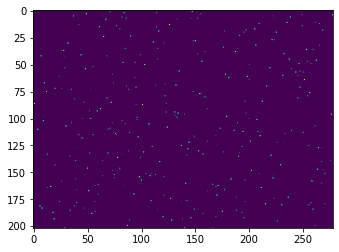

In [341]:
plt.imshow(partial_ot*M.numpy())

In [488]:
s.min(), s.max(), xa.shape

(0.43378192, 0.73165464, (653, 2))

<ipython-input-489-942d311b0a71>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  this_idx = ((vectors_lab == 2).astype(np.float32) + (vectors_lab == 3).astype(np.float32)).astype(np.bool)


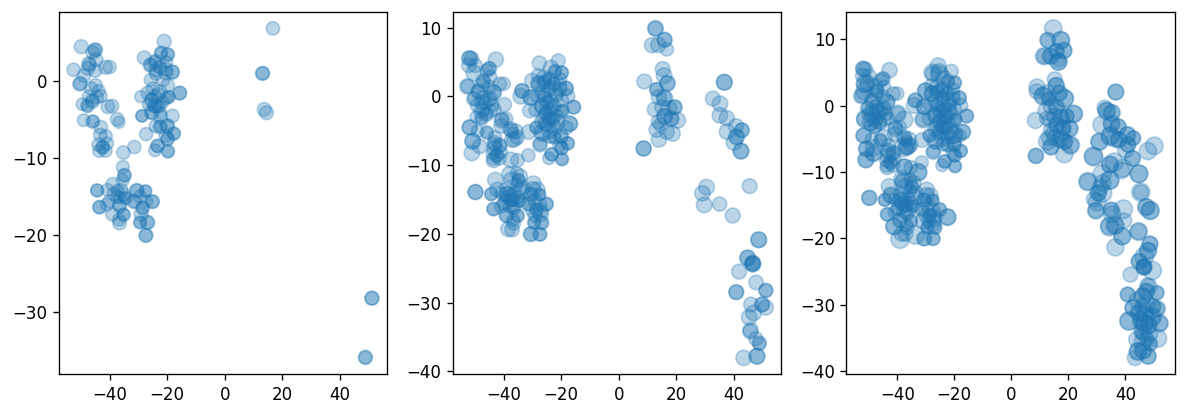

In [489]:
plt.figure(figsize=(12, 4), dpi=120)

# for i in range(2):

this_idx = ((vectors_lab == 2).astype(np.float32) + (vectors_lab == 3).astype(np.float32)).astype(np.bool)

xa = c_embedded[this_idx]

for j,i in enumerate([0.25, 0.5, 0.75]):
    plt.subplot(1, 3, j+1)
    sort_idx = np.argsort(s)[:int(i*len(s))]
    plt.scatter(xa[:, 0][sort_idx], xa[:, 1][sort_idx], s=np.exp(s[sort_idx]*9),
                alpha=0.3)

# plt.scatter(xa[:, 0], xa[:, 1], s=100*(1-s/s.max()), alpha=0.3)
# print(xa.shape)

# this_idx = vectors_lab == 1
# xa = c_embedded[this_idx]
# plt.scatter(xa[:, 0], xa[:, 1])

In [464]:
(vectors_lab == 1).astype(np.float32)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
c_embedded[this_idx]

In [346]:
s = (partial_ot*M.numpy()).sum(axis=1)

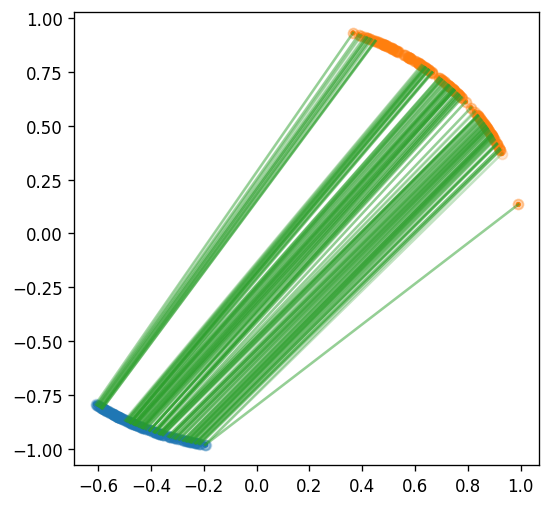

In [284]:
plt.figure(figsize=(5, 5), dpi=120)

P = partial_ot
if P.sum() > 0:
    P = P / P.max()
    
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P[i, j] > 0:
            plt.plot([xa[i, 0], xb[j, 0]], [xa[i, 1], xb[j, 1]], color='C2',
                    alpha=P[i, j] * 0.3)
            
plt.scatter(xa[:, 0], xa[:, 1], c='C0', alpha=0.2)
plt.scatter(xb[:, 0], xb[:, 1], c='C1', alpha=0.2)
plt.scatter(xa[:, 0], xa[:, 1], c='C0', s=P.sum(1).ravel() * 4)
plt.scatter(xb[:, 0], xb[:, 1], c='C1', s=P.sum(0).ravel() * 4)

In [304]:
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=.05)
ot_sinkhorn.fit(Xs=xa.numpy(), Xt=xb.numpy())

In [319]:
xs = []
ys = []
for i in range(2):
    this_idx = vectors_lab == i
    c = c_embedded[this_idx]
    # c -= 0.9 * c_embedded[this_idx].mean(axis=0).reshape(1, -1)
    c /= 0.9 * np.abs(c).mean()
    xs.append(c)
    ys.append(vectors_lab[this_idx])

xs = np.concatenate(xs, axis=0)    
ys = np.concatenate(ys, axis=0)    

xt = []
yt = []
for i in range(2,4):
    this_idx = vectors_lab == i
    c = c_embedded[this_idx]
    # c -= 0.9 * c_embedded[this_idx].mean(axis=0).reshape(1, -1)
    c /= 0.9 * np.abs(c).mean()
    
    xt.append(c)
    yt.append(vectors_lab[this_idx])

xt = np.concatenate(xt, axis=0)    
yt = np.concatenate(yt, axis=0)  

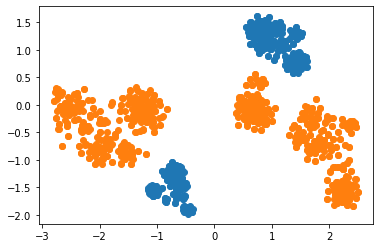

In [320]:
plt.scatter(xs[:, 0], xs[:, 1])
plt.scatter(xt[:, 0], xt[:, 1])

In [321]:
ot_sinkhorn_semi = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn_semi.fit(Xs=xs, Xt=xt, ys=ys, yt=yt)
transp_Xs_sinkhorn_semi = ot_sinkhorn_semi.transform(Xs=xs)

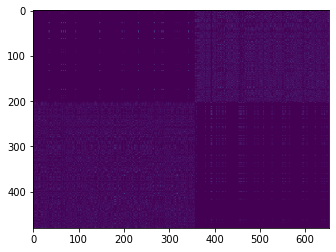

In [329]:
plt.imshow(ot_sinkhorn_semi.coupling_)

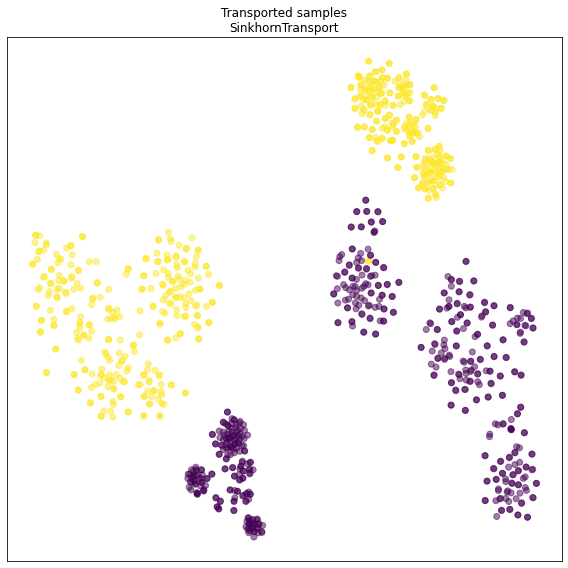

In [333]:
plt.figure(4, figsize=(8, 8))
plt.scatter(xs[:, 0], xs[:, 1], c=ys, marker='o',
           label='Target samples', alpha=0.5)
plt.scatter(xt[:, 0], xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)

# plt.scatter(transp_Xs_sinkhorn_semi[:, 0],
#             transp_Xs_sinkhorn_semi[:, 1], c=ys,
#            marker='+', label='Transp samples', s=30)
plt.title('Transported samples\nSinkhornTransport')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

In [307]:
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=xa.numpy())

In [ ]:
transp_Xs_sinkhorn

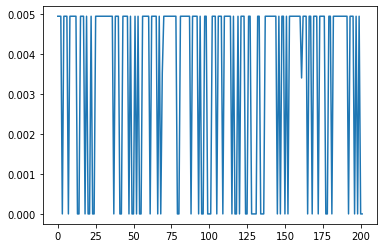

In [275]:
plt.plot(partial_ot.sum(axis=1))

In [277]:
partial_ot.sum()

0.7000000000000004

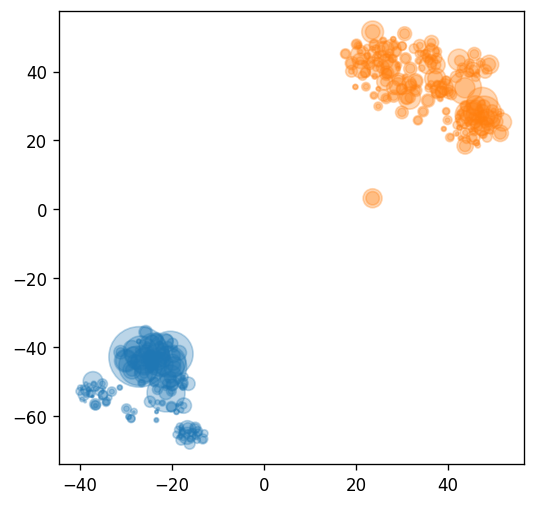

In [254]:
plt.figure(figsize=(5, 5), dpi=120)
# plt.figure(figsize=(10, 5), dpi=120)

alpha = 0.3
norm_sub_scores = (sub_scores - sub_scores.min()) / (sub_scores.max() - sub_scores.min())
norm_sub_scores = np.exp(8*norm_sub_scores)
norm_sub_scores /= norm_sub_scores.min()
n = 2

for idx in np.arange(n):
    # plt.subplot(1, n, idx+1)
    this_idx = vectors_lab == idx
    # thid_scores = sub_scores[this_idx]
    thid_scores = norm_sub_scores[this_idx]
    sort_idx = np.argsort(thid_scores)

    plt.scatter(c_embedded[:, 0][this_idx],
                c_embedded[:, 1][this_idx],
                marker='o', s=thid_scores,
                alpha=alpha)
    

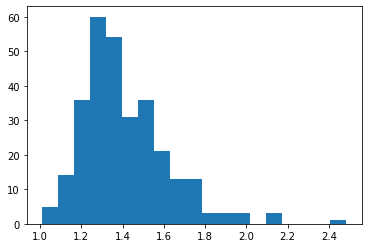

In [240]:
_ = plt.hist(thid_scores, bins='auto')

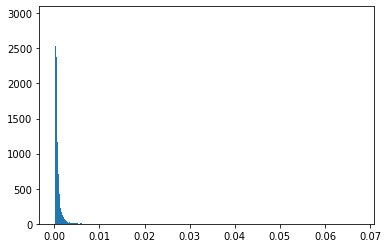

In [122]:
# t_scores = torch.cat(scores, dim=0)

_ = plt.hist(t_scores[:100000], bins='auto', cumulative=False)
# plt.savefig(save_path + f'/opt_sinkhorn.score.pq.405.{dist_score}.lam{lam}.png')

In [52]:
t_scores = torch.cat(scores, dim=0)

In [53]:
save_path

'data/vox1_inst_avg3'

In [40]:
result = torch.randn(12, 12)
result = result.norm(dim=1)

In [36]:
from torch import tensor, long

In [41]:
print(result)
print(torch.tensor(result, dtype=long))


tensor([2.9087, 2.7930, 5.1832, 2.8717, 3.8930, 2.4445, 3.3142, 3.2320, 3.1750,
        2.9271, 4.4009, 4.3941])
tensor([2, 2, 5, 2, 3, 2, 3, 3, 3, 2, 4, 4])


<ipython-input-41-ece59498a300>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(result, dtype=long))


In [60]:
train_utts = pd.DataFrame(train_dir.base_utts, columns=['uid', 'start', 'end'])
train_utts['scores'] = t_scores.numpy()

save_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshotavg3_lr_SinkhornCos2_embeddings'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
train_utts.to_csv(os.path.join(save_dir, 'subtrain.{}.scores.csv'.format(0)),
                  index=None)

#### Optimal Other Samples

In [50]:
# define cost matrix
# all_samples = datas.size()[1]
# num_class = data_mus.size()[0]

num_classes = config_args['num_classes']
num_class = config_args['num_classes']
all_samples = len(embeddings)
partial = 40
scores  = []
dist_score = 'logits'
lam = 10

other_num_classes = partial
repeats = 80

In [ ]:
num_classes = config_args['num_classes']
num_class = config_args['num_classes']
all_samples = len(embeddings)
partial = 16

dist_score = 'logits'
lam = 10

other_num_classes = partial
repeats = int(np.ceil(num_classes/partial))
# repeats = 32

for seed in [1233, 1234, 1235, 1236, 1237]:
    all_seed(seed)
    scores  = []
    for j in tqdm(range(int(np.ceil(num_classes/partial))), ncols=50):
        start_class = j*partial
        end_class   = (j+1)*partial
        start_idx  = int(np.sum(class_indices[:start_class]))
        end_idx    = int(np.sum(class_indices[:end_class]))
        # print(start_idx, end_idx)

        this_embeddings = embeddings[start_idx:end_idx].clone()
        this_embeddings = torch.nn.functional.normalize(this_embeddings, dim=1)

        Ts = []
        for m in range(repeats):
            other_classes = np.random.choice(list(set(np.arange(num_classes))-set(np.arange(start_class, end_class))), size=other_num_classes, replace=False)

            other_embeddings = []
            for i in other_classes:
                other_embeddings.append(new_data[i]) 
            other_embeddings = torch.cat(other_embeddings, dim=0)
            other_embeddings = torch.nn.functional.normalize(other_embeddings, dim=1)

            dist = 1 - torch.matmul(this_embeddings, other_embeddings.transpose(0,1)).unsqueeze(0)

            a = np.ones(dist.shape[1]) #/ dist.shape[1]
            b = np.ones(dist.shape[-1]) #* np.array(class_indices[start_class:end_class]) #/ dist.shape[-1]

            P, T = compute_optimal_transport(dist.cuda(), 
                                             torch.tensor(a).unsqueeze(0),
                                             torch.tensor(b).unsqueeze(0),
                                             lam=lam)
            T = T.cpu().norm(dim=2).pow(2) #[1:]
            Ts.append(T)

        T = torch.cat(Ts, dim=0)
        scores.append(T.mean(dim=0))

    t_scores = torch.cat(scores, dim=0)
    
    save_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshotavg3_lr_SinkhornCos8_embeddings'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    train_utts = pd.DataFrame(train_dir.base_utts, columns=['uid', 'start', 'end'])
    train_utts['scores'] = t_scores.numpy()    
    train_utts.to_csv(os.path.join(save_dir, f'subtrain.{seed}.scores.csv'),
                      index=None)


 83%|██████████▊  | 63/76 [13:21<03:01, 13.95s/it]

In [63]:
torch.cat(scores, dim=0).shape

torch.Size([772634])

In [77]:
x0 = [s.shape[0] for s in scores]

x1 = []

partial = 32
for j in tqdm(range(int(np.ceil(num_classes/partial))), ncols=50):
    start_class = j*partial
    end_class   = (j+1)*partial
    start_idx  = int(np.sum(class_indices[:start_class]))
    end_idx    = int(np.sum(class_indices[:end_class]))
    x1.append(end_idx-start_idx)
    

100%|███████████| 38/38 [00:00<00:00, 8679.13it/s]


In [78]:
len(x0), len(x1)

(76, 38)

In [81]:
x1[:10], x0[:10]

([10136, 10432, 9575, 9657, 8723, 8934, 10573, 10384, 9340, 11300],
 [10136, 10432, 9575, 9657, 8723, 8934, 10573, 10384, 9340, 11300])

In [ ]:
t_scores = torch.cat(scores, dim=0)

In [64]:
np.random.choice(list(set(np.arange(num_classes))-set(np.arange(start_class, end_class))), size=other_num_classes, replace=False)

array([ 822,  910,  428, 1103,  248,   63,  331,  632,  866,  212,  767,
        810,  139,  133,  725,  678,  793,  158,  491,  455])

In [6]:
save_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshotavg3_lr_SinkhornCos6_embeddings'

train_utts = pd.read_csv(save_dir+'/subtrain.0.scores.csv')
t_scores = train_utts['scores'].to_numpy()

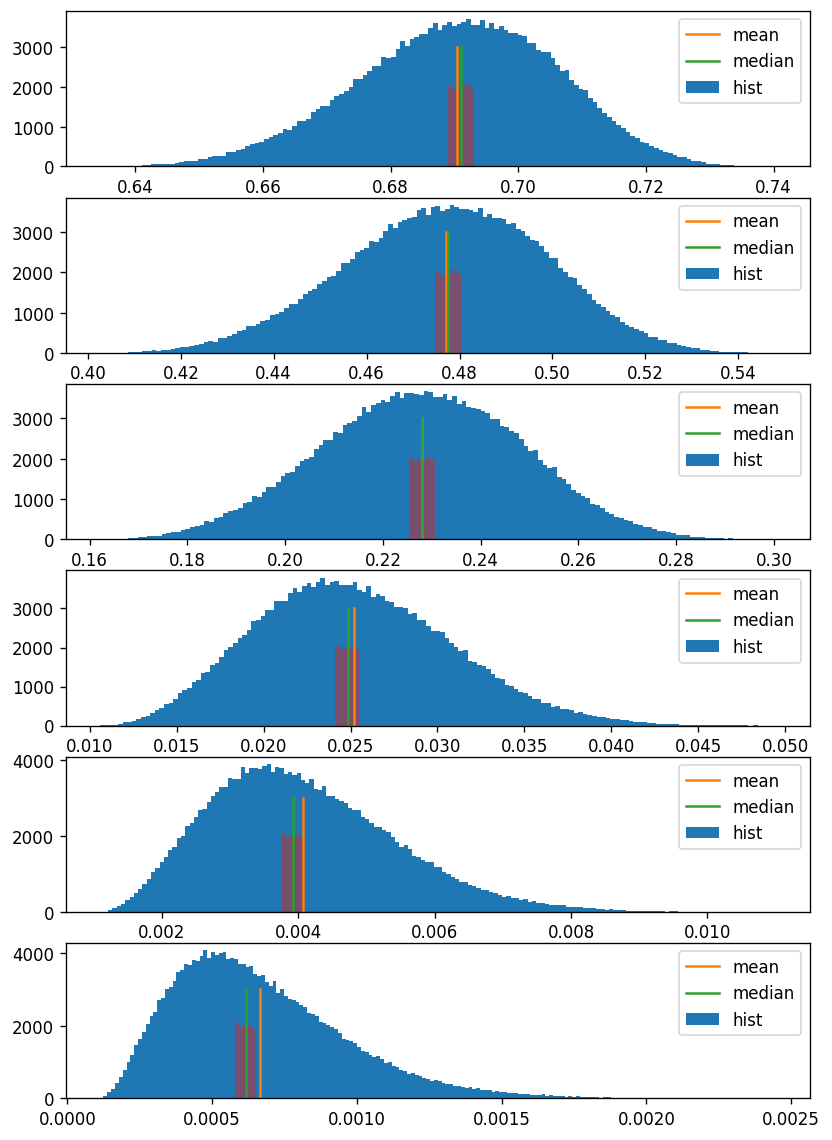

In [111]:
save_path = 'data/vox1_inst_avg3' #data/vox1_inst

# t_scores = torch.cat(scores, dim=0)
plt.figure(figsize=(8, 12), dpi=120)

for i,j in enumerate([0.05, 0.1, 0.2, 0.5, 0.75, 1]):
    plt.subplot(6,1,i+1)
    t = np.power(t_scores[-200000:], j)
    _ = plt.hist(t, bins='auto', cumulative=False)

    plt.plot([t.mean()]*2, [0, 3000])
    plt.plot([np.median(t)]*2, [0, 3000])

    plt.legend(['mean', 'median', 'hist', ])
    idx = np.argsort(np.abs(t-np.median(t)))[:int(0.1*len(t))]
    _ = plt.hist(t[idx], bins=10, cumulative=False, alpha=0.5)

# plt.savefig(save_path + f'/opt_sinkhorn.score.other_class.{partial}-{other_num_classes}-{repeats}.{dist_score}.lam{lam}.meanmedian.png')

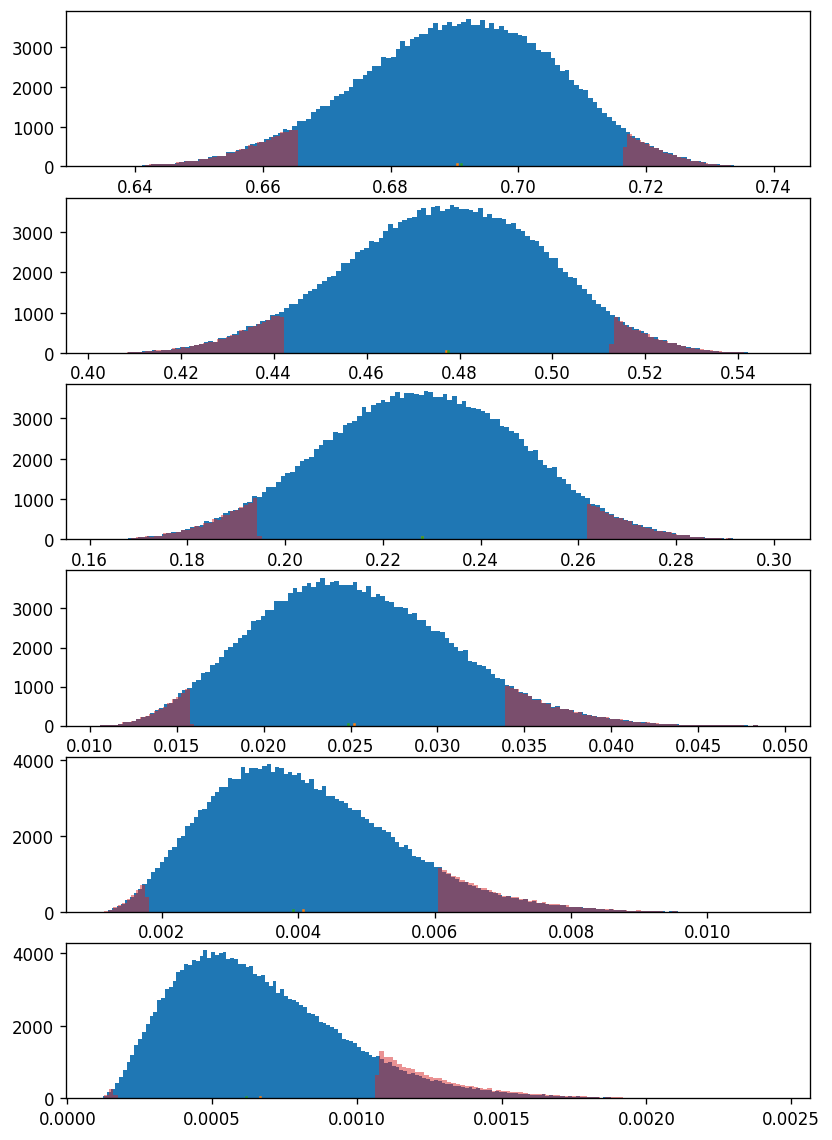

In [106]:
save_path = 'data/vox1_inst_avg3' #data/vox1_inst

# t_scores = torch.cat(scores, dim=0)
plt.figure(figsize=(8, 12), dpi=120)

for i,j in enumerate([0.05, 0.1, 0.2, 0.5, 0.75, 1]):
    plt.subplot(6,1,i+1)
    t = np.power(t_scores[-200000:], j)
    _ = plt.hist(t, bins='auto', cumulative=False)

    plt.plot([t.mean()]*2, [0, 50])
    plt.plot([np.median(t)]*2, [0, 50])

    # plt.legend(['mean', 'median', 'hist', ])
    idx = np.argsort(np.abs(t-np.median(t)))[-int(0.1*len(t)):]
    _ = plt.hist(t[idx], bins=150, cumulative=False, alpha=0.5)

# plt.savefig(save_path + f'/opt_sinkhorn.score.other_class.{partial}-{other_num_classes}-{repeats}.{dist_score}.lam{lam}.meanmedian.png')

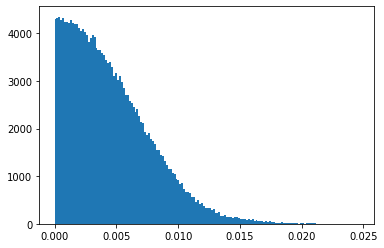

In [88]:
_=plt.hist(np.abs(t-np.median(t)), bins='auto')



In [49]:
# SinkhornCos3 -- samples2samples -- 20-20
# SinkhornCos4 -- samples2samples with mean norm -- 20-20
# SinkhornCos5 -- samples2samples with mean norm -- 20-20 iteration=60
# SinkhornCos6 -- samples2samples -- 20-20 iteration=60
# SinkhornCos7 -- samples2samples -- 32-32 iteration=80
# SinkhornCos8 -- samples2samples -- 16-16 iteration=1211/16
# SinkhornCos9 -- samples2logits -- 16-16 iteration=1211/16

t_scores = torch.cat(scores, dim=0)

train_utts = pd.DataFrame(train_dir.base_utts, columns=['uid', 'start', 'end'])
train_utts['scores'] = t_scores.numpy()

save_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshotavg3_lr_SinkhornCos7_embeddings'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
train_utts.to_csv(os.path.join(save_dir, 'subtrain.{}.scores.csv'.format(0)),
                  index=None)

### Optimal Tranport and Multi-scale distance

In [483]:
from Process_Data.Datasets.SelectDataset import cost_func

class Dist_loss(nn.Module):
    def __init__(self, w, metric='cosine'):
        super(Dist_loss, self).__init__()
        w = w/w.mean()
        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
                                # SamplesLoss("sinkhorn", p=2, blur=0.1)
    def forward(self, x1, x2):
        w = torch.nn.functional.softmax(self.w, dim=0)
        # w =  torch.clamp(self.w, min=0, max=2, out=None)
        w = w / w.mean()
        
        return self.loss(w*x1, x2)
    
from Define_Model.ParallelBlocks import gumbel_softmax_sample


def gumbel_softmax(logits, num=1, temperature = 5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    y_sort_idx = torch.argsort(y, dim=1)
    # _, ind = y.max(dim=-1)
    ind = y_sort_idx[:, -num:]
    # print(y_sort_idx.shape, ind)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    # y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard.scatter_(1, ind, 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

class MultiRatioDist_loss(nn.Module):
    def __init__(self, w, metric='cosine',
                ratios=[0.1, 0.25, 0.5, 0.75, 0.9],
                sample_ratio=3, temperature=5):
        super(MultiRatioDist_loss, self).__init__()

        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
                                # SamplesLoss("sinkhorn", p=2, blur=0.1)
        self.ratios = ratios
        self.sample_ratio = sample_ratio
        self.temperature = temperature
    def forward(self, x1, x2):

        loss = 0
        if self.sample_ratio < len(self.ratios):
            ratios = np.random.choice(self.ratios, self.sample_ratio, replace=False)
        else:
            ratios = self.ratios
            
        for r in ratios:
            idx = gumbel_softmax(self.w.reshape(1, -1), num=int(len(self.w)*r),
                                 temperature=self.temperature).squeeze().reshape(-1,1)
            x11 = x1*idx
            
            idx2 = (torch.rand(len(x2)) <= r).float().reshape(-1,1).to(x2.device)
            
            loss = loss + self.loss(x11, x2*idx2)
                
        return loss / len(ratios)
    

class MultiRatioStdDist_loss(nn.Module):
    def __init__(self, w, metric='cosine',
                ratios=[0.1, 0.25, 0.5, 0.75, 0.9],
                sample_ratio=3):
        super(MultiRatioStdDist_loss, self).__init__()

        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
                                # SamplesLoss("sinkhorn", p=2, blur=0.1)
        self.ratios = ratios
        self.sample_ratio = sample_ratio
        
    def forward(self, x1, x2):

        loss = 0
        if self.sample_ratio < len(self.ratios):
            ratios = np.random.choice(self.ratios, self.sample_ratio, replace=False)
        else:
            ratios = self.ratios
            
        for r in ratios:
            idx = gumbel_softmax(self.w.reshape(1, -1), num=int(len(self.w)*r)).squeeze().reshape(-1,1)
            x11 = x1*idx
            loss = loss + self.loss(x11, x2) / x11.std(dim=0).norm(p=2)
                
        return loss / len(ratios)


class MultiRatioDiscrepencyDist_loss(nn.Module):
    def __init__(self, w, metric='cosine',
                ratios=[0.1, 0.25, 0.5, 0.75, 0.9],
                sample_ratio=3):
        super(MultiRatioDiscrepencyDist_loss, self).__init__()

        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
                                # SamplesLoss("sinkhorn", p=2, blur=0.1)
        self.ratios = ratios
        self.sample_ratio = sample_ratio
        
    def forward(self, x1, x2):

        loss = 0
        if self.sample_ratio < len(self.ratios):
            ratios = np.random.choice(self.ratios, self.sample_ratio, replace=False)
        else:
            ratios = self.ratios
        
        standard_loss = self.loss(x1, x2)
        
        for r in ratios:
            idx = gumbel_softmax(self.w.reshape(1, -1), num=int(len(self.w)*r)).squeeze().reshape(-1,1)
            x11 = x1*idx
            loss = loss + (self.loss(x11, x2) - standard_loss).abs()
                
        return loss / len(ratios)

In [478]:
(torch.rand(len(x2)) <= 0.25).float()

tensor([1., 0., 0.,  ..., 0., 0., 1.])

In [53]:
np.random.choice([1,2,3,4,5,6], 4, replace=False)

array([1, 3, 6, 5])

In [ ]:
gumbel_softmax

In [144]:
samples = np.arange(sample_num)
batch_samples = []
for i in range(optimizer_time):
    np.random.shuffle(samples)
    batch_samples.append(samples[:int(sample_num / batch_size) * batch_size].reshape(-1, batch_size))

batch_samples = np.concatenate(batch_samples, axis=0)

In [146]:
bigger_samples = np.arange(sample_num)
bigger_batch_samples = []
bigger_batch_size = int(batch_size*4)

for i in range(optimizer_time*2):
    np.random.shuffle(bigger_samples)
    
    bigger_batch_samples.append(bigger_samples[:int(sample_num / bigger_batch_size) * bigger_batch_size].reshape(-1, bigger_batch_size))
    
bigger_batch_samples = np.concatenate(bigger_batch_samples, axis=0)

In [147]:
print(bigger_batch_samples.shape, batch_samples.shape)

(752, 2048) (1508, 512)


In [195]:
save_path

'data/vox1_inst'

In [ ]:
repeat = 1
optimizer_time = 4
metric = 'euclidean'
batch_size = 1024
optimize_vector = 'grads'
wss = []
random_seed = 1234
sample_ratio = 5
steps = 20
lr = 0.1
save_path = 'data/vox1_inst_avg3'

grads_f = '{}/grads.pth'.format(save_path)
logits_f = '{}/logits.pth'.format(save_path)
embeddings_f = '{}/embeddings.pth'.format(save_path)

for optimize_vector in ['grads', 'logits', 'embeddings']:
    if optimize_vector == 'grads':
        grads = torch.load(grads_f)['grads']
    elif optimize_vector == 'logits':
        logits = torch.load(logits_f)['logits']
    elif optimize_vector == 'embeddings':
        embeddings = torch.load(embeddings_f)['embeddings']
        print('Loading vectors from {}'.format(save_path))

    print('Computing optimal scores for ', optimize_vector)

    for cur_repeat in range(repeat):
        np.random.seed(random_seed)
        random_seed = random_seed - 5

        ws =  torch.ones(sample_num, 1)
        total_set = set(np.arange(sample_num))

        bigger_samples = np.arange(sample_num)
        bigger_batch_samples = []
        bigger_batch_size = int(batch_size*4)

        for i in range(optimizer_time*4):
            np.random.shuffle(bigger_samples)
            bigger_batch_samples.append(bigger_samples[:int(sample_num / bigger_batch_size) * bigger_batch_size].reshape(-1, bigger_batch_size))

        bigger_batch_samples = np.concatenate(bigger_batch_samples, axis=0)

        samples = np.arange(sample_num)
        batch_samples = []
        for i in range(optimizer_time):
            np.random.shuffle(samples)
            batch_samples.append(samples[:int(sample_num / batch_size) * batch_size].reshape(-1, batch_size))

        batch_samples = np.concatenate(batch_samples, axis=0)

        # pbar = tqdm(range(int(sample_num/batch_size*optimizer_time)), ncols=50)
        pbar = tqdm(range(len(batch_samples)), ncols=50)

        for i in pbar:

            select_ids = batch_samples[i]
            other_set = bigger_batch_samples[i%(bigger_batch_samples.shape[0])]

            if optimize_vector == 'embeddings':
                s_xvectors = embeddings[select_ids]
            elif optimize_vector == 'logits':
                s_xvectors = logits[select_ids]
            elif optimize_vector == 'grads':
                s_xvectors = grads[select_ids]

            x1 = s_xvectors.clone().cuda() #.to(device)

            # dloss = Dist_loss(ws[select_ids]).to(x1.device)
            dloss = MultiRatioDist_loss(ws[select_ids], metric='euclidean', sample_ratio=sample_ratio).to(x1.device)

            opt = torch.optim.Adam(dloss.parameters(), lr=lr, weight_decay=0)

            for j in range(steps):
                other_set = bigger_batch_samples[(i+j)%(bigger_batch_samples.shape[0])]

                if optimize_vector == 'embeddings':
                    x2 = embeddings[other_set].clone().to(device)
                elif optimize_vector == 'logits':
                    x2 = logits[other_set].clone().to(device)
                elif optimize_vector == 'grads':
                    x2 = grads[other_set].clone().to(device)

                L_αβ = dloss(x1, x2)
                L_αβ.backward()
                opt.step()
                # print(dloss.w.data.squeeze()[:10])
                opt.zero_grad()

            w = dloss.w.data.cpu()
            ws[select_ids] = w #dloss.w.data.abs().cpu()
            # break

        wss.append(ws)

    ws = torch.stack(wss, dim=0)
    if ws.shape[0] > 1:
        ws = ws.mean(dim=0)
    else:
        ws = ws.squeeze()

    trainset = 'v1'
    other_str = 'x2s'
    if isinstance(dloss, MultiRatioDist_loss):
        loss_str = 'mulscale'

    scores_path = '{}/scores.{}.{}.lr{:.1f}.steps{}.time{}.batch{}.{}.{}.path'.format(save_path, loss_str, trainset, lr, steps, optimizer_time, batch_size, other_str, optimize_vector)

torch.save({'scores': ws.squeeze()}, scores_path)

In [202]:
trainset = 'v1'
other_str = 'x2s'
# if isinstance(dloss, MultiRatioDist_loss):
loss_str = 'mulscale'
lr = 0.1
steps = 20
optimizer_time = 4

scores_path = '{}/scores.{}.{}.lr{:.1f}.steps{}.time{}.batch{}.{}.{}.path'.format(save_path, loss_str, trainset, lr, steps, optimizer_time, batch_size, other_str, optimize_vector)


In [203]:
scores_path

'data/vox1_inst/scores.mulscale.v1.lr0.1.steps20.time4.batch48.x2s.embeddings.path'

In [163]:
print(ws.squeeze().min(), ws.squeeze().max())

tensor(-2.4893) tensor(9.0417)


In [164]:
ws.squeeze().shape, sample_num

(torch.Size([386317]), 386317)

In [256]:
# scores = torch.load('data/vox1_inst/scores.mulscale.v1.lr0.1.steps20.time4.logits.pth')['scores']
# scores = torch.load('data/vox1_inst/scores.mulscale.v1.lr0.1.steps20.time4.batch1024.x2s.grads.path')['scores']
scores = torch.load('data/vox1_inst/losses.pth')['losses']

In [332]:
scores = torch.load('data/vox1_inst_avg3/scores.mulscale.lr0.1.steps20.time4.bat1024.x2s.logits.pth')['scores']

In [331]:
# torch.load('data/vox1_inst_avg3/scores.mulscale.lr0.1.steps20.time4.bat1024.x2s.logits.pth')

{'scores': tensor([0.6343, 0.6962, 1.4828,  ..., 1.2097, 1.9544, 1.7410])}

In [333]:
train_utts = pd.DataFrame(train_dir.base_utts, columns=['uid', 'start', 'end'])
train_utts['scores'] = scores #ws.squeeze().numpy()

save_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshotavg3_lr_muloptimal_logits'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
train_utts.to_csv(os.path.join(save_dir, 'subtrain.{}.scores.csv'.format(0)),
                  index=None)

In [334]:
[np.arange(2)]*2

[array([0, 1]), array([0, 1])]

### batch size should be related to the ratio of subset

In [199]:
from Define_Model.ParallelBlocks import gumbel_softmax_sample

def gumbel_softmax(logits, num=1, temperature = 5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    y_sort_idx = torch.argsort(y, dim=1)
    # _, ind = y.max(dim=-1)
    ind = y_sort_idx[:, -num:]
    # print(y_sort_idx.shape, ind)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    # y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard.scatter_(1, ind, 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [220]:
w.squeeze()[gumbel_softmax(w.cuda().reshape(1, -1), num=10).squeeze().bool()]

torch.Size([1, 512]) tensor([[402,  97, 107, 234, 347,  87, 222, 180, 114, 322]], device='cuda:1')


tensor([1.2529, 0.7807, 1.0882, 1.1323, 0.6588, 1.1155, 1.0709, 1.1681, 0.9610,
        1.2499])

In [119]:
def gumbel_softmax(logits, num=1, temperature = 5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    y_sort_idx = torch.argsort(y, dim=1)
    # _, ind = y.max(dim=-1)
    ind = y_sort_idx[:, -num:]
    # print(y_sort_idx.shape, ind)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    # y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard.scatter_(1, ind, 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [187]:
dloss.w.shape,x1.shape

(torch.Size([512, 1]), torch.Size([512, 192]))

  20    14  442.0161  441.9662


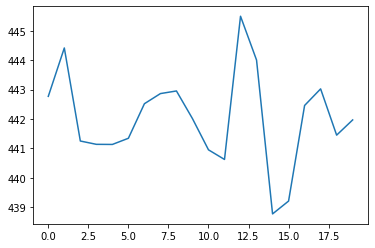

In [153]:
x1 = s_xvectors.clone().cuda() #.to(device)
steps = 20
sample_ratio = 5
lr = .1
ratios=[0.1, 0.25, 0.5, 0.75, 0.9]

# for steps in [20]:
# for lr in [4, 2, 1, 0.1, 0.01]:
for steps in [20]:
    for sample_ratio in [5]:

        losses = []
        dloss = MultiRatioDist_loss(ws[select_ids], metric='euclidean', sample_ratio=sample_ratio).to(x1.device)
        # dloss = MultiRatioDiscrepencyDist_loss(ws[select_ids], metric='euclidean', 
        #                                        ratios=ratios,
        #                                        sample_ratio=sample_ratio).to(x1.device)

        opt = torch.optim.Adam(dloss.parameters(), lr=lr, weight_decay=0)
        np.random.seed(1234)
        for i in range(steps):
            other_set = bigger_batch_samples[i//2]
            x2 = embeddings[other_set].clone().to(device)
            L_αβ = dloss(x1, x2)
            # L_αβ = dloss(x1, x1)
            
            losses.append(float(L_αβ.item()))
            L_αβ.backward()
            opt.step()
            opt.zero_grad()
                # w = torch.clamp(dloss.w.data.cpu(), min=0, max=2, out=None) #dloss.w.data.squeeze().abs()

        plt.plot(losses)
        print('{: >4}  {: >4}  {:.4f}  {:.4f}'.format(steps, np.argmin(losses), np.mean(losses), losses[-1]))
    
# 0.1
# 20 503.4534 19 
# 30 503.4202 20 
# 40 503.2956 39 
# 60 503.2195 48 

# 0.2
# 20 504.0794 19 
# 30 503.4644 28 
# 40 503.2004 36 
# 60 503.0920 47

# 0.3
# 20 504.4903 18 
# 30 503.6195 29 
# 40 503.3297 39 
# 60 503.1680 56 

# 0.1
# 20 449.2462 17 
# 30 449.2888 20 
# 40 448.8777 15 
# 60 450.0882 18

# sample_ratio = 5 lr=1,
# 20 23.1627 13 
# 40 21.6203 12 
# 80 19.1648 43 
# 200 21.1245 62

In [ ]:
w[torch.argsort(w)]

503.200439453125


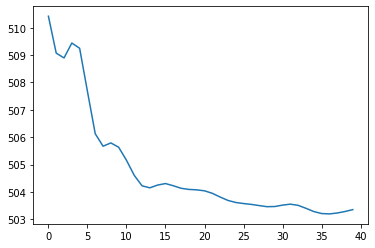

In [124]:
plt.plot(losses)
print(np.min(losses))

In [50]:
w = torch.nn.functional.softmax(dloss.w.data.cpu().squeeze(), dim=0)
# w =  torch.clamp(self.w, min=0, max=2, out=None)
w = w / w.mean()

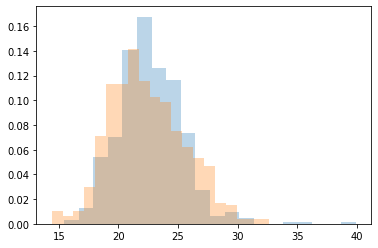

In [77]:
_ = plt.hist(x1.norm(dim=1).cpu(), bins=20, alpha=0.3, density=True)
_ = plt.hist(x1.norm(dim=1).cpu()*w, bins=20, alpha=0.3, density=True)

In [154]:
w = torch.nn.functional.softmax(dloss.w.data.cpu().squeeze(), dim=0)
# w = torch.clamp(self.w, min=0, max=2, out=None)
w = w / w.mean()

y     = x1.norm(dim=1).cpu()
idx   = torch.sort(y).indices
idx_w = torch.sort(w).indices

In [155]:
print(w.min(), w.max())

tensor(0.0431) tensor(17.7399)


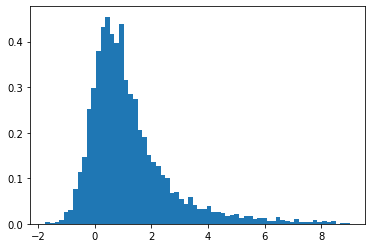

In [17]:
# _ = plt.hist(w, bins='auto', density=True)
_ = plt.hist(scores.squeeze().numpy()[:5120], bins='auto', density=True)

In [ ]:
w[idx_w]

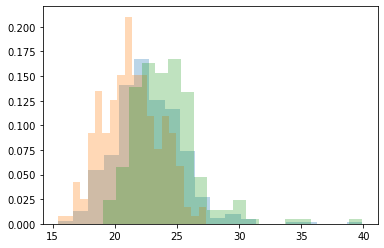

In [89]:
_ = plt.hist(y, bins=20, alpha=0.3, density=True)
_ = plt.hist(y[idx_w[-200:]], bins=20, alpha=0.3, density=True)
_ = plt.hist(y[idx_w[:200]], bins=20, alpha=0.3, density=True)


In [432]:
from geomloss import SamplesLoss

In [433]:
loss_func = SamplesLoss("sinkhorn", p=2, blur=0.05, cost=lambda a, b: cost_func(a, b, p=2, metric='euclidean'))

In [91]:
op_1 = loss_func(x1[idx_w[-200:]], x2)
op_2 = loss_func(x1[idx_w[:200]], x2)
print(op_1.float(), op_2)

tensor(513.7578, device='cuda:1') tensor(627.0327, device='cuda:1')


In [157]:
print("   #Samples   |  max_opx2  |  min_opx2 |  max_opx1  |  min_opx1 |   x1_x2   |  x2_x2  |   random1 |  random2  |")
np.random.seed(1234)
for r in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    
    ops= []
    for x2_idx in range(10):
        other_set = bigger_batch_samples[x2_idx*4]
        x2 = embeddings[other_set].clone().to(device) 
        
        num = int(r*len(idx_w))
        op_1 = loss_func(x1[idx_w[-num:]], x2)
        op_2 = loss_func(x1[idx_w[:num]], x2)
        op_11 = loss_func(x1[idx_w[-num:]], x1)
        op_22 = loss_func(x1[idx_w[:num]], x1)
        op_3 = loss_func(x1, x2)
        op_4 = loss_func(x2, x2)
        # print(op_1.float(), op_2)
        
        ops.append([float(op_1), float(op_2),float(op_11), float(op_22), float(op_3), float(op_4)])
        
    ops = np.mean(ops, axis=0)

    loss_rand1 = []
    for i in range(10):
        x1_samples = np.arange(len(x1))
        np.random.shuffle(x1_samples)
        rand_idx = torch.LongTensor(x1_samples[-num:]).to(device)
        loss_rand1.append(loss_func(x1[rand_idx], x1).cpu().float())
    
    loss_rand2 = []
    for i in range(10):
        x1_samples = np.arange(len(x1))
        np.random.shuffle(x1_samples)
        rand_idx = torch.LongTensor(x1_samples[-num:]).to(device)
        loss_rand2.append(loss_func(x1[rand_idx], x2).cpu().float())

    print(" {: >5d} ({:4>.2f}) |   {:.3f}  |  {:.3f}  |   {:>7.3f}  |  {:>7.3f}  |  {:.3f}  |  {:.3f}  |  {:>7.3f}  |  {:>7.3f}  |".format(num, r, ops[0],ops[1],ops[2],ops[3],ops[4],
                                                                                                 ops[5], np.mean(loss_rand1), np.mean(loss_rand2)))
    
   # #Samples   |    max_op  |  min_op   |   x1_x2   |  x2_x2  |   random  |
   #    51      |   591.282  |  755.204  |  503.421  |  0.000  |  654.000  |
   #   128      |   534.334  |  661.014  |  503.421  |  0.000  |  590.209  |
   #   256      |   503.825  |  594.438  |  503.421  |  0.000  |  547.005  |
   #   384      |   496.292  |  547.888  |  503.421  |  0.000  |  520.241  |
   #   460      |   498.988  |  522.620  |  503.421  |  0.000  |  509.579  |

   #Samples   |  max_opx2  |  min_opx2 |  max_opx1  |  min_opx1 |   x1_x2   |  x2_x2  |   random1 |  random2  |
   102 (0.10) |   549.193  |  711.371  |   504.763  |  621.699  |  465.170  |  0.000  |  534.275  |  608.008  |
   256 (0.25) |   497.873  |  616.473  |   392.503  |  439.980  |  465.170  |  0.000  |  401.117  |  550.554  |
   512 (0.50) |   472.373  |  543.353  |   257.431  |  249.740  |  465.170  |  0.000  |  247.563  |  504.910  |
   768 (0.75) |   462.458  |  500.732  |   134.045  |  111.193  |  465.170  |  0.000  |  116.329  |  482.236  |
   921 (0.90) |   461.854  |  479.991  |    56.562  |   41.437  |  465.170  |  0.000  |   46.454  |  471.102  |
   972 (0.95) |   462.731  |  472.757  |    29.583  |   19.926  |  465.170  |  0.000  |   23.067  |  467.936  |


In [118]:
print("   #Samples   |  max_opx2  |  min_opx2 |  max_opx1  |  min_opx1 |   x1_x2   |  x2_x2  |   random1 |  random2  |")
np.random.seed(1234)
for r in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    
    ops= []
    for x2_idx in range(10):
        other_set = bigger_batch_samples[x2_idx*4]
        x2 = embeddings[other_set].clone().to(device) 
        
        num = int(r*len(idx_w))
        op_1 = loss_func(x1[idx_w[-num:]], x2)
        op_2 = loss_func(x1[idx_w[:num]], x2)
        op_11 = loss_func(x1[idx_w[-num:]], x1)
        op_22 = loss_func(x1[idx_w[:num]], x1)
        op_3 = loss_func(x1, x2)
        op_4 = loss_func(x2, x2)
        # print(op_1.float(), op_2)
        
        ops.append([float(op_1), float(op_2),float(op_11), float(op_22), float(op_3), float(op_4)])
        
    ops = np.mean(ops, axis=0)

    loss_rand1 = []
    for i in range(10):
        x1_samples = np.arange(len(x1))
        np.random.shuffle(x1_samples)
        rand_idx = torch.LongTensor(x1_samples[-num:]).to(device)
        loss_rand1.append(loss_func(x1[rand_idx], x1).cpu().float())
    
    loss_rand2 = []
    for i in range(10):
        x1_samples = np.arange(len(x1))
        np.random.shuffle(x1_samples)
        rand_idx = torch.LongTensor(x1_samples[-num:]).to(device)
        loss_rand2.append(loss_func(x1[rand_idx], x2).cpu().float())

    print(" {: >5d} ({:4>.2f}) |   {:.3f}  |  {:.3f}  |   {:>7.3f}  |  {:>7.3f}  |  {:.3f}  |  {:.3f}  |  {:>7.3f}  |  {:>7.3f}  |".format(num, r, ops[0],ops[1],ops[2],ops[3],ops[4],
                                                                                                 ops[5], np.mean(loss_rand1), np.mean(loss_rand2)))
    
   # #Samples   |    max_op  |  min_op   |   x1_x2   |  x2_x2  |   random  |
   #    51      |   591.282  |  755.204  |  503.421  |  0.000  |  654.000  |
   #   128      |   534.334  |  661.014  |  503.421  |  0.000  |  590.209  |
   #   256      |   503.825  |  594.438  |  503.421  |  0.000  |  547.005  |
   #   384      |   496.292  |  547.888  |  503.421  |  0.000  |  520.241  |
   #   460      |   498.988  |  522.620  |  503.421  |  0.000  |  509.579  |

   #Samples   |  max_opx2  |  min_opx2 |  max_opx1  |  min_opx1 |   x1_x2   |  x2_x2  |   random1 |  random2  |


NameError: name 'bigger_batch_samples' is not defined

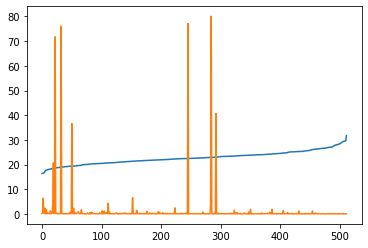

In [263]:
plt.plot(y[idx])
plt.plot(w[idx])
# plt.plot((y*w)[idx])

In [ ]:
x1.norm(dim=1).cpu()*w

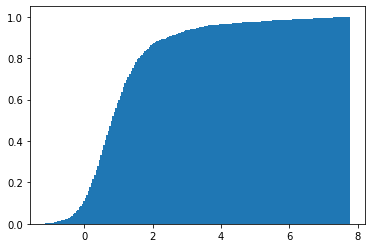

In [272]:
_ = plt.hist(ws.squeeze()[:2000], bins=200, cumulative=True, density=True)
# plt.xscale('log')

In [ ]:
# dloss.w.grad
# ws[:100]
idx = torch.sort(ws.squeeze()).indices
ws[idx[-100:]]

In [116]:
idx.shape

torch.Size([386301, 1])

In [550]:
torch.save({'weights': ws}, 'data/vox2/weight.adam.512.pth')

In [286]:
import pandas as pd

In [287]:
train_utts = pd.DataFrame(train_dir.base_utts, columns=['uid', 'start', 'end'])
train_utts['scores'] = ws.squeeze().numpy()

train_utts.to_csv(os.path.join('data/vox2', 'subtrain.{}.scores.csv'.format(0)),
                  index=None)

In [293]:
scores_utts = pd.read_csv(os.path.join('data/vox2', 'subtrain.{}.scores.csv'.format(0))).to_numpy()

In [295]:
scores_utts[:, -1].astype(np.float32)

array([1.0109581 , 1.0425051 , 0.9720516 , ..., 0.98818487, 1.007649  ,
       1.0005752 ], dtype=float32)

In [299]:
isinstance(scores_utts, np.ndarray)

True

In [298]:
type(np.array([0]))

numpy.ndarray

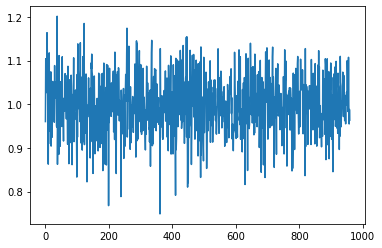

In [551]:
plt.plot(ws[:192*5])

In [276]:
 torch.clamp(dloss.w, min=0, max=None, out=None).squeeze()

tensor([1.0847, 0.7928, 0.9437, 0.9226, 1.0970, 0.9642, 0.8300, 0.7533, 1.0684,
        0.9703, 1.2075, 0.8556, 0.9872, 1.0142, 0.8874, 0.9423, 1.0489, 0.8062,
        0.9436, 0.9211, 0.7868, 0.8112, 1.0417, 0.9621, 1.1970, 0.6961, 0.7554,
        0.8663, 1.1496, 0.8346, 0.9528, 1.0622, 1.2156, 0.9771, 1.1184, 0.8449,
        1.0420, 1.2011, 1.0929, 0.9940, 0.9283, 1.2092, 0.9854, 0.9348, 1.0021,
        0.8265, 1.0707, 1.1061, 1.1406, 1.1476, 1.1865, 0.9351, 0.9794, 1.1467,
        0.9899, 1.0639, 0.8515, 0.9758, 0.8566, 0.9828, 0.9257, 0.9806, 1.1537,
        0.9151, 1.0171, 1.0892, 1.1026, 0.7150, 1.0516, 1.0144, 1.2819, 1.0385,
        1.1359, 1.0043, 0.9578, 0.9713, 1.2582, 1.0290, 0.9604, 1.1242, 0.9068,
        0.8332, 0.9394, 0.9187, 1.1651, 0.6764, 0.7592, 1.2796, 0.9830, 1.0989,
        0.8486, 0.9984, 0.8949, 0.9937, 1.0046, 1.1887, 0.9522, 1.0982, 0.7692,
        0.9274, 0.9178, 0.9645, 1.0143, 1.0372, 1.1319, 0.9459, 1.2759, 1.0260,
        0.9607, 1.1045, 1.0587, 1.0580, 

In [507]:
# from Process_Data.Datasets.SelectDataset import cost_func

# class Dist_loss(nn.Module):
#     def __init__(self, w, metric='cosine'):
#         super(Dist_loss, self).__init__()
#         w = w/w.mean()
#         self.w = nn.Parameter(w)
#         self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
#                                 cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
#                                 # SamplesLoss("sinkhorn", p=2, blur=0.1)
#     def forward(self, x1, x2):
#         w = self.w.abs()
#         w = w / w.mean()
        
#         return self.loss(w*x1, x2)
    
def cost_func(a, b, p=2, metric='cosine'):
    """ a, b in shape: (B, N, D) or (N, D)
    """ 
    assert type(a)==torch.Tensor and type(b)==torch.Tensor, 'inputs should be torch.Tensor'
    if metric=='euclidean' and p==1:
        return geomloss.utils.distances(a, b)
    elif metric=='euclidean' and p==2:
        return geomloss.utils.squared_distances(a, b)
    else:
        if a.dim() == 3:
            x_norm = a / (a.norm(dim=2)[:, :, None]+1e-12)
            y_norm = b / (b.norm(dim=2)[:, :, None]+1e-12)
            M = 1 - torch.bmm(x_norm, y_norm.transpose(-1, -2))
        elif a.dim() == 2:
            x_norm = a / (a.norm(dim=1)[:, None]+1e-12)
            y_norm = b / (b.norm(dim=1)[:, None]+1e-12)
            M = 1 - torch.mm(x_norm, y_norm.transpose(0, 1))
        # M = pow(M, p)
        return M
    
class Dist_loss(nn.Module):
    def __init__(self, w, lamda=0, portion=0.8, metric='cosine'):
        super(Dist_loss, self).__init__()
        w = w/w.mean()
        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
        self.lamda = lamda
        self.portion = portion
        # self.sig = nn.Sigmoid()
    
    def get_w(self):
        w = torch.clamp(self.w, min=0.0, max=2, out=None)
        w = w/w.mean()
        return w

    def forward(self, x1, x2):
        # w = 2 * self.sig(self.w)
        # w = torch.clamp(self.w, min=0.0, max=2, out=None)
        # w = w/w.mean()
        w = self.get_w()
        
        return self.loss(w*x1, x2) + self.lamda * ((w <= 1).sum()/w.numel() - self.portion).abs()

In [183]:
x1 = s_xvectors.clone().cuda() #.to(device)
dloss = Dist_loss(ws[select_ids], metric=metric).to(x1.device)

other_set = bigger_samples[np.random.choice(np.arange(len(bigger_samples)))]

x2 = embeddings[other_set].clone().to(device)
opt = torch.optim.SGD(dloss.parameters(), lr=0.2, weight_decay=0)

for i in range(10):
    L_αβ = dloss(x1, x2)
    L_αβ.backward()
    
    dloss.w.data = dloss.w.data - 0.2*dloss.w.grad
    
    opt.step()
    opt.zero_grad()

In [259]:
steps = 40

In [434]:
96 * np.arange(1, 6)

array([ 96, 192, 288, 384, 480])

In [543]:
np.random.seed(1234)

steps  = 40
batch_sizes = 2 ** np.arange(6, 11)

total_loss = []
weights = {i:[] for i in [10, 20, 30, 40]}
ws =  torch.ones(sample_num, 1) #+0.5

for b in batch_sizes:
    select_ids = (np.arange(b) + b*i) % sample_num

    s_xvectors = embeddings[select_ids]
    x1 = s_xvectors.clone().cuda() 
    
    bigger_batch_size = int(b*4)
    bigger_samples = np.arange(sample_num)
    np.random.seed(1234)
    np.random.shuffle(bigger_samples)
    bigger_samples = bigger_samples[:int(sample_num/bigger_batch_size) * bigger_batch_size].reshape(-1, bigger_batch_size)
    other_set = bigger_samples[np.random.choice(np.arange(len(bigger_samples)))]
    
    x2 = embeddings[other_set].clone().to(device)
        
    dloss = Dist_loss(ws[select_ids].clone(), lamda=0,).to(x1.device)
    opt = torch.optim.Adam(dloss.parameters(), lr=2, weight_decay=0)

    loss = []
    for i in range(steps):
        # L_αβ = OT_solver(w*x1, x2)
        L_αβ = dloss(x1, x2)
        L_αβ.backward()
        opt.step()
        # opt.zero_grad()

        loss.append(float(L_αβ.item()))
        
        if (i+1) % 10 == 0:
            weights[i+1].append(dloss.get_w().data.squeeze().cpu().numpy())
    
    total_loss.append(loss)

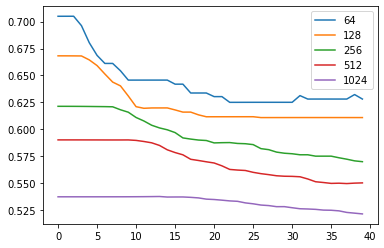

In [544]:
for t in total_loss:
    plt.plot(t)
    
plt.legend([str(b) for b in batch_sizes])

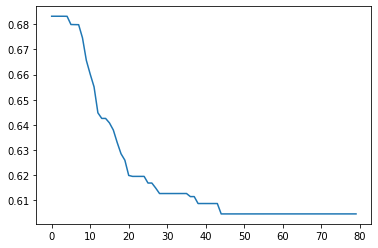

In [512]:
# for t in :
plt.plot(total_loss[0])
    
# plt.legend([str(b) for b in batch_sizes])

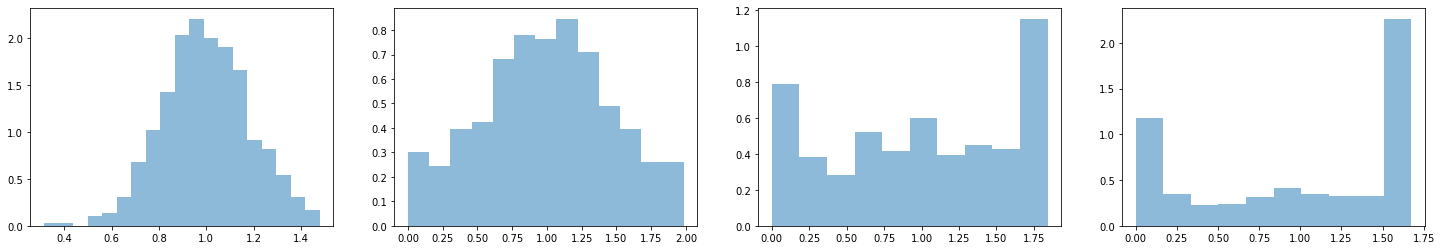

In [519]:
plt.figure(figsize=(25, 4))
for i, t in enumerate(weights):
    plt.subplot(1, len(weights),  i+1)
    plt.hist(weights[t][-1], bins='auto', density=True, alpha=0.5)
    
    # plt.legend([str(batch_sizes[i])])

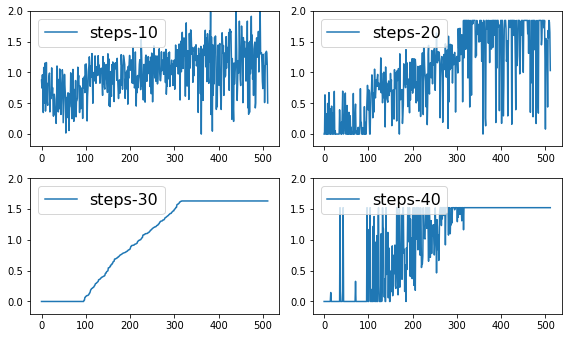

In [548]:
plt.figure(figsize=(8, 4.8))
j = -2
sort_idx = np.argsort(weights[30][j])

for i, t in enumerate([weights[i][j] for i in weights]):
    plt.subplot(2, len(weights)//2,  i+1)
    # plt.hist(t, bins='auto', density=True, alpha=0.5)
    plt.plot(t[sort_idx])
    plt.ylim([-0.2, 2])

    plt.legend(['steps-' + str((i+1) * 10)], fontsize=16, loc='upper left')
plt.tight_layout()

plt.savefig('score_convergence.png')

In [411]:
np.mean([4.605, 4.625, 4.867])

4.699000000000001

(array([ 11.,  23.,  58., 100., 160., 178., 126.,  68.,  38.,   6.]),
 array([0.02689774, 0.21658729, 0.40627682, 0.5959664 , 0.78565592,
        0.97534549, 1.16503501, 1.35472453, 1.54441416, 1.73410368,
        1.9237932 ]),
 <BarContainer object of 10 artists>)

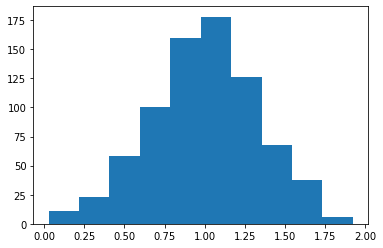

In [343]:
plt.hist(torch.clamp(dloss.w.data.squeeze(), min=0.0, max=2.0, out=None).cpu().numpy())

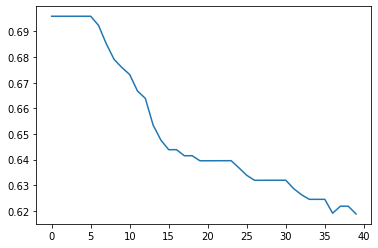

In [269]:
plt.plot(loss)

In [271]:
w = torch.clamp(dloss.w, min=0, max=2, out=None) #dloss.w.data.squeeze().abs()
w /= w.mean()

print(w.squeeze())

tensor([0.1019, 0.0000, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 0.0000,
        0.0000, 1.6039, 0.0000, 0.0000, 0.0000, 0.0000, 1.6039, 0.0000, 0.0000,
        1.6039, 1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039,
        0.0000, 0.0000, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 0.0000, 1.6039,
        1.6039, 0.0000, 1.6039, 1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039,
        1.6039, 1.6039, 1.6039, 1.6039, 0.0000, 1.6039, 0.1770, 1.6039, 1.6039,
        1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 1.3998,
        1.5241, 1.6039, 0.8081, 0.0000, 0.0000, 1.6039, 0.0000, 1.6039, 0.0323,
        0.0000, 1.6039, 1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 0.0000,
        1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 0.0000, 0.0000, 0.5347, 1.6039,
        1.6039, 1.6039, 1.6039, 1.6039, 0.0000, 1.6039], device='cuda:1',
       grad_fn=<SqueezeBackward0>)


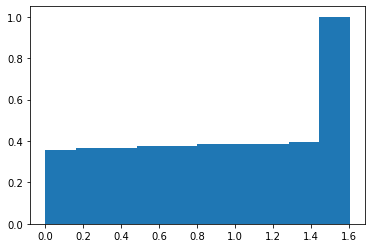

In [272]:
_ = plt.hist(w.squeeze().detach().cpu().numpy(), bins=10, density=True, cumulative=True)
plt.savefig('lamda=0.png')

In [83]:
x1.shape, x2.shape

(torch.Size([96, 192]), torch.Size([384, 192]))

In [ ]:
torch.save({'weights': ws}, 'data/vox2/weight.pth')

### Sample balance

In [336]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Sample T-SNE

In [11]:
save_path = 'data/vox1_inst'
save_path = 'data/vox1_inst'

optimize_vector = 'logits'

if optimize_vector == 'embeddings':
    embeddings = torch.load('{}/embeddings.pth'.format(save_path))['embeddings']
elif optimize_vector == 'logits':
    logits = torch.load('{}/logits.pth'.format(save_path))['logits']
elif optimize_vector == 'grads':
    grads = torch.load('{}/grads.pth'.format(save_path))['grads']

In [12]:
scores =  torch.load('{}/scores.mulscale.v1.lr0.1.steps20.time4.batch1024.x2s.pth'.format(save_path))['scores']

In [237]:
scores = t_scores

In [238]:
sublabels = np.arange(6)
optimize_vector = 'embeddings' #'logits'

vectors = []
vectors_lab = []
sub_scores = []
for s in sublabels:
    sidx = labels == s

    if optimize_vector == 'embeddings':
        feats = embeddings[sidx].clone()
    elif optimize_vector == 'logits':
        feats = logits[sidx].clone()
    elif optimize_vector == 'grads':
        feats = grads[sidx].clone()
        
    sub_scores.append(scores[sidx]) 
    vectors.append(feats)
    vectors_lab.extend([s]*len(feats))
        
vectors = torch.cat(vectors, dim=0)
vectors_lab = np.array(vectors_lab)
sub_scores = torch.cat(sub_scores, dim=0)

In [216]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib

In [217]:
all_vectors = PCA(n_components=64).fit_transform(vectors.numpy())
c_embedded  = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(all_vectors)

In [35]:
embedds = pd.DataFrame(c_embedded, columns=['x', 'y'])
embedds['label'] = vectors_lab
embedds['scores'] = sub_scores.squeeze().numpy()

# embedds['domain'] = domains

In [43]:
score_sort= np.argsort(sub_scores.squeeze().numpy())

In [53]:
embedds[embedds['scores'] <= sub_scores.squeeze().numpy()[score_sort[100]]]
#.loc(score_sort[:100])

x          y  label    scores
1    -50.401527   0.317670      0 -0.252600
2    -50.558170   2.778502      0 -0.247394
7    -50.067780 -21.063002      0 -0.056656
19   -46.107578 -13.463084      0 -0.492148
22   -45.730377 -10.348448      0 -0.362844
...         ...        ...    ...       ...
1090 -24.232710  55.418484      3 -0.142292
1093 -16.272129  50.055405      3 -0.154061
1107  -8.552108  39.274006      3 -0.051230
1113 -22.492676  54.903275      3 -0.341670
1116 -27.378096  30.199268      3 -0.738571

[101 rows x 4 columns]

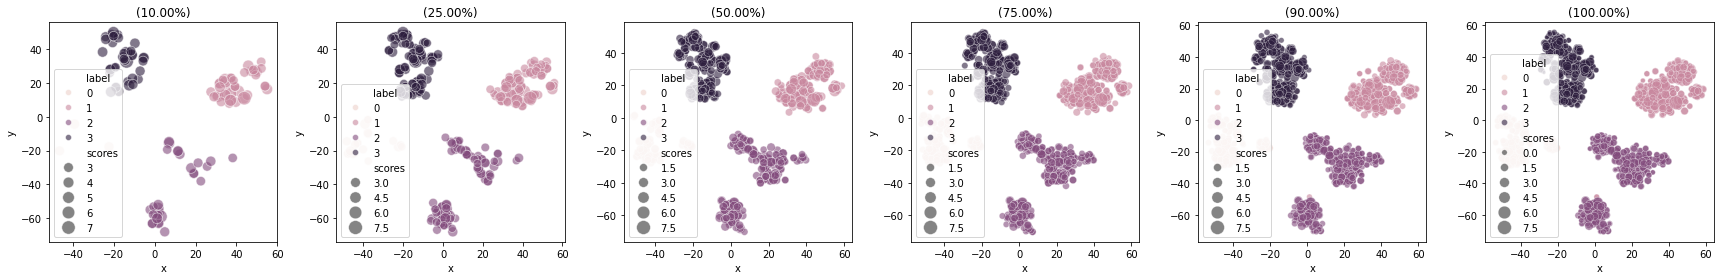

In [80]:
fig = plt.figure(figsize=(24, 4))
# sns.scatterplot(embedds[score_sort[:100]], x='x', y='y', 
#                 hue='label', style='label', 
#                 size='scores', sizes=(50, 500),
#                 alpha=0.6)
ratio = [0.1, 0.25, 0.5, 0.75, 0.9, 1]

for i,r in enumerate(ratio):
    plt.subplot(1, int(np.ceil(len(ratio)/1)), i+1)
    plt.title('({:.2f}%)'.format(r*100))
    num_samples = int(r*len(embedds))-1
    sns.scatterplot(embedds[embedds['scores'] >= sub_scores[score_sort[-num_samples]]], 
    # sns.scatterplot(embedds[embedds['scores'] <= sub_scores[score_sort[num_samples]]], 
                    x='x', y='y', 
                    size_norm=norm,
                    hue='label', 
                    size='scores', sizes=(10, 200),
                    alpha=0.6)
    plt.tight_layout()

# plt.savefig('imgs/tsne_ecapa.v2_snr05.v1_test.png')

In [65]:
sub_scores = sub_scores.squeeze().numpy()
norm = matplotlib.colors.Normalize(vmin=sub_scores.min(), vmax=sub_scores.max())

### Optimal Min&Max - Randoms

In [189]:
imgs_dir = 'data/vox1_inst/{}'.format(optimize_vector)
if not os.path.exists(imgs_dir):
    os.makedirs(imgs_dir)

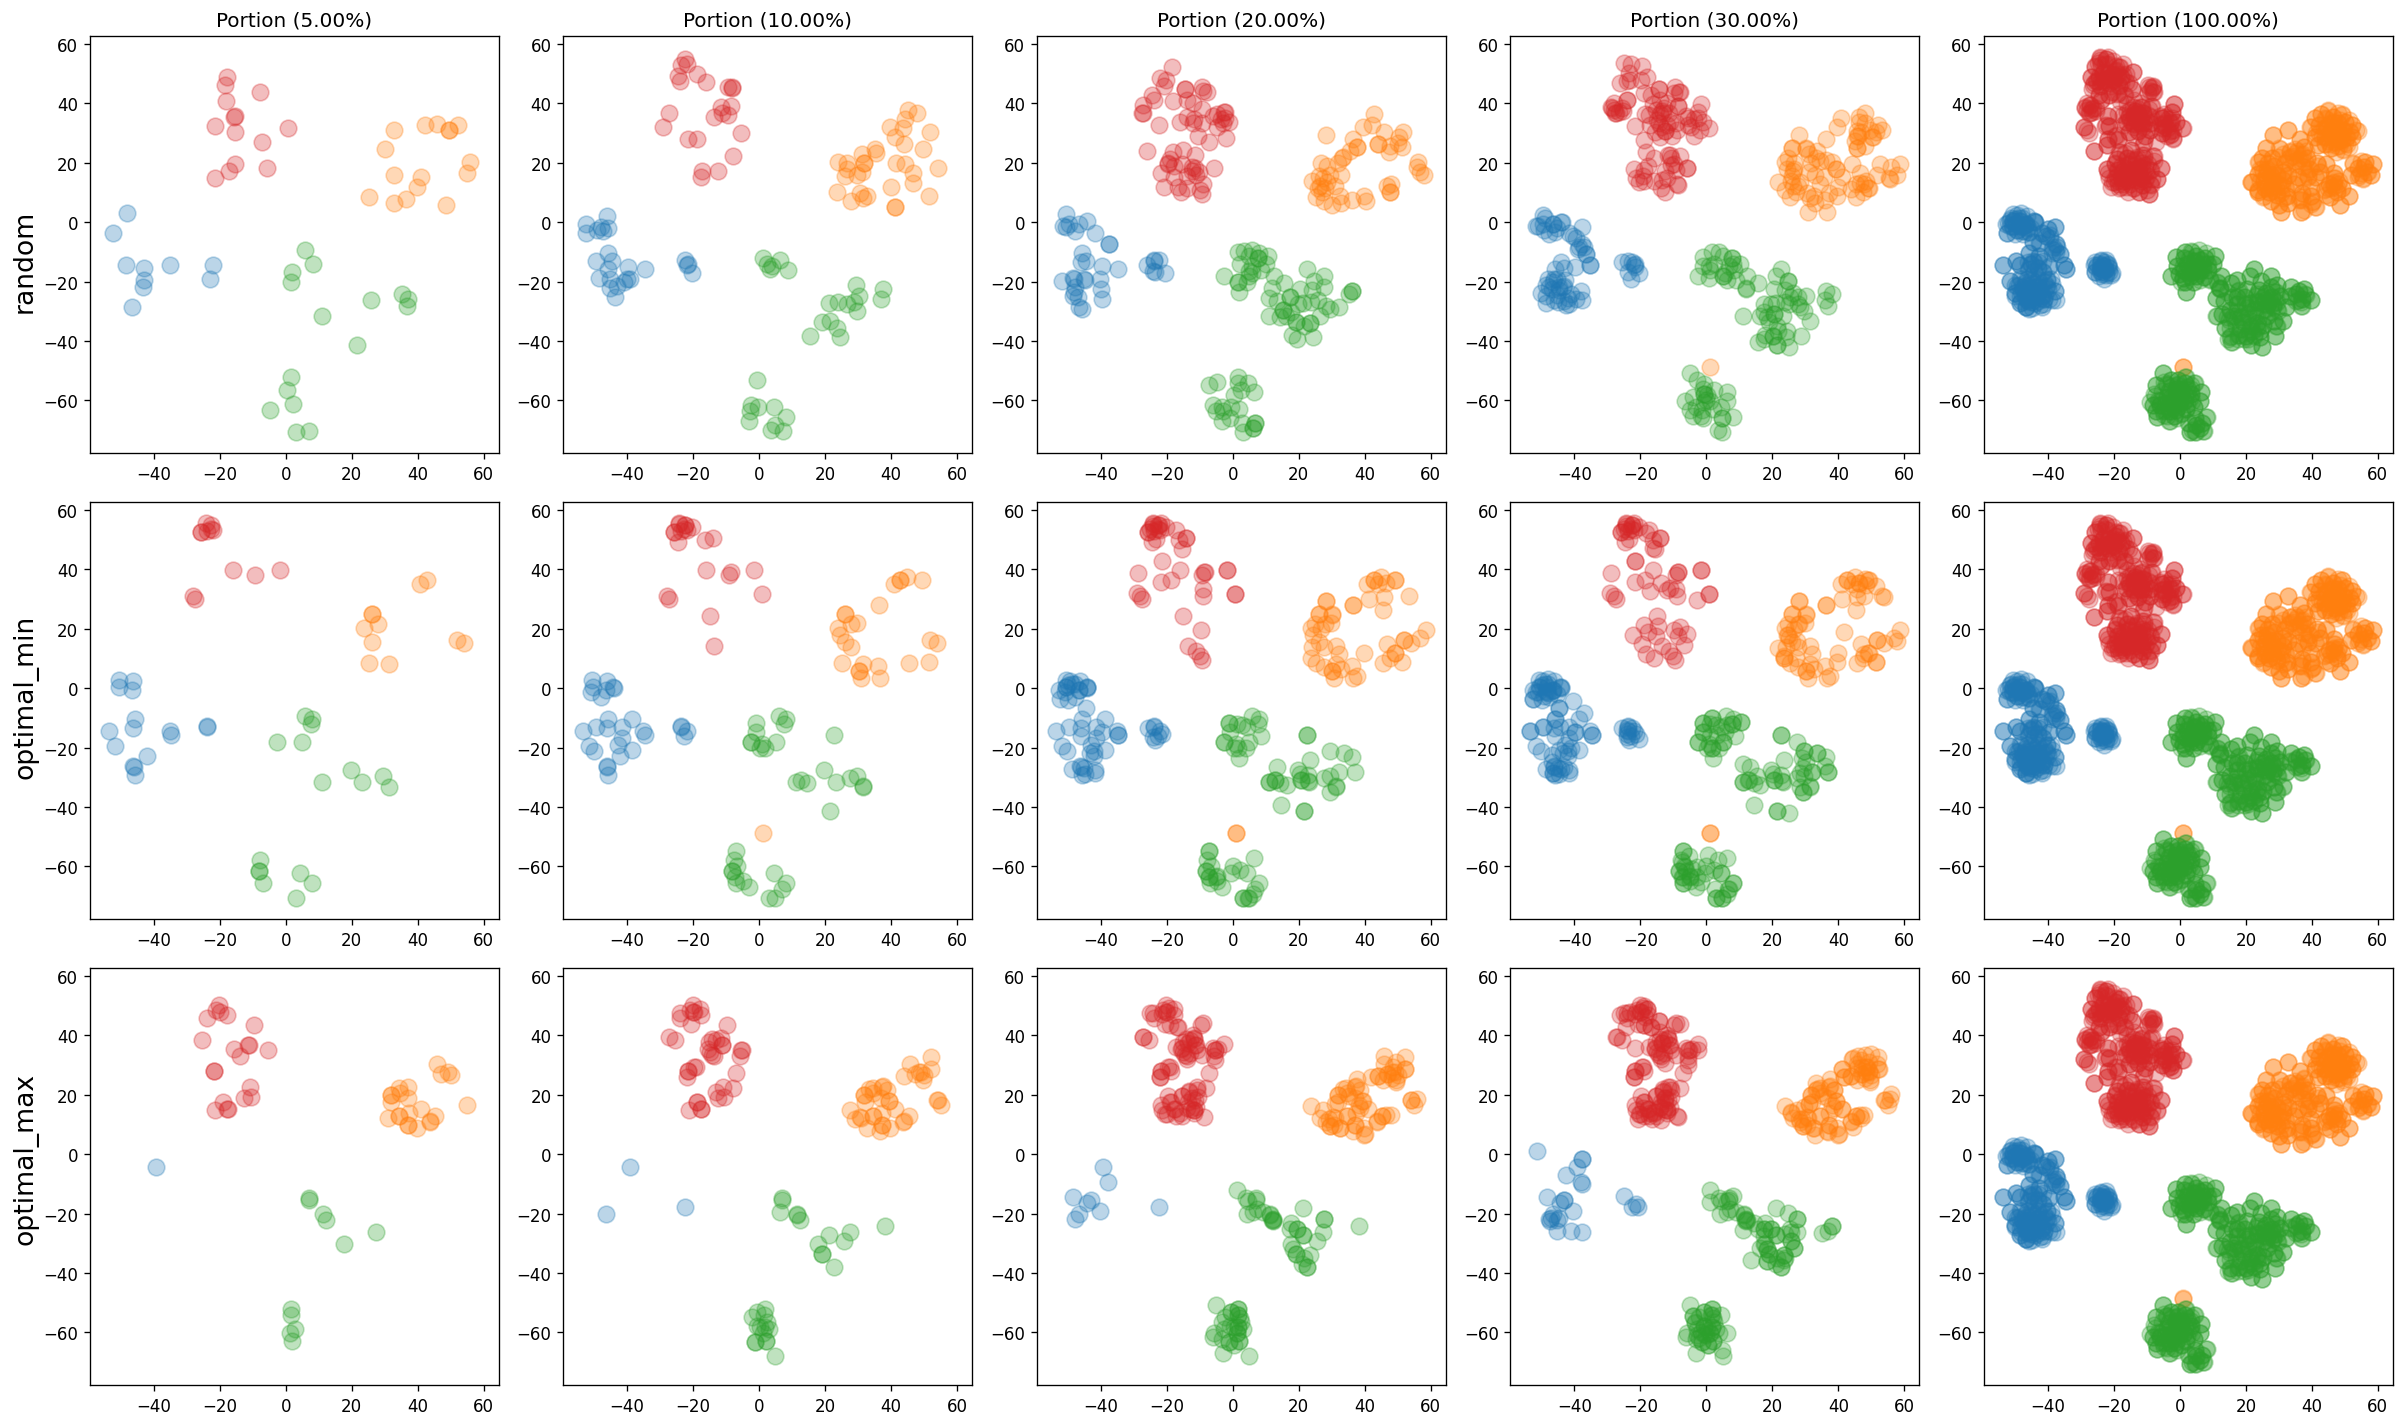

In [190]:
fig = plt.figure(figsize=(20, 12), dpi=120)
 
num_pert = 5
end = num_pert+1

plot_idx = np.arange(4)

labs = vectors_lab
sort_idx = np.argsort(sub_scores)


x_min,x_max = c_embedded[:, 0].min(), c_embedded[:, 0].max()
x_mag = max(np.abs(x_min), np.abs(x_max))

y_min,y_max = c_embedded[:, 1].min(), c_embedded[:, 1].max(), 
y_mag = max(np.abs(y_min), np.abs(y_max))

alpha=0.3
ratios   = [0.05, 0.1, 0.2, 0.3, 1]

num_pert = len(ratios)

# for i in range(1, num_pert+1):
for j,r in enumerate(ratios):
    
    i = j +1
    plt.subplot(3, num_pert, i)
    if i == end-1:
        this_len = len(labs)
    else:
        this_len = int(len(labs)*r)
    
    plt.title('Portion ({:.2f}%)'.format(r*100))

    part_idx = np.random.choice(np.arange(len(labs)), size=this_len, replace=False)
    s_labs = labs[part_idx]
    
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.4, s='random', fontsize=16, rotation='vertical')
    plt.subplot(3,num_pert,i+num_pert)

    part_idx = sort_idx[:this_len]
    s_labs   = labs[part_idx]
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.4, s='optimal_min', fontsize=16, rotation='vertical')
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
    plt.subplot(3,num_pert,i+num_pert+num_pert)

    part_idx = sort_idx[-this_len:]
    s_labs   = labs[part_idx]
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.4, s='optimal_max', fontsize=16, rotation='vertical')
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
plt.tight_layout()

plt.savefig('{}/optimal_random.tsne.png'.format(imgs_dir))

### Optimal Balance

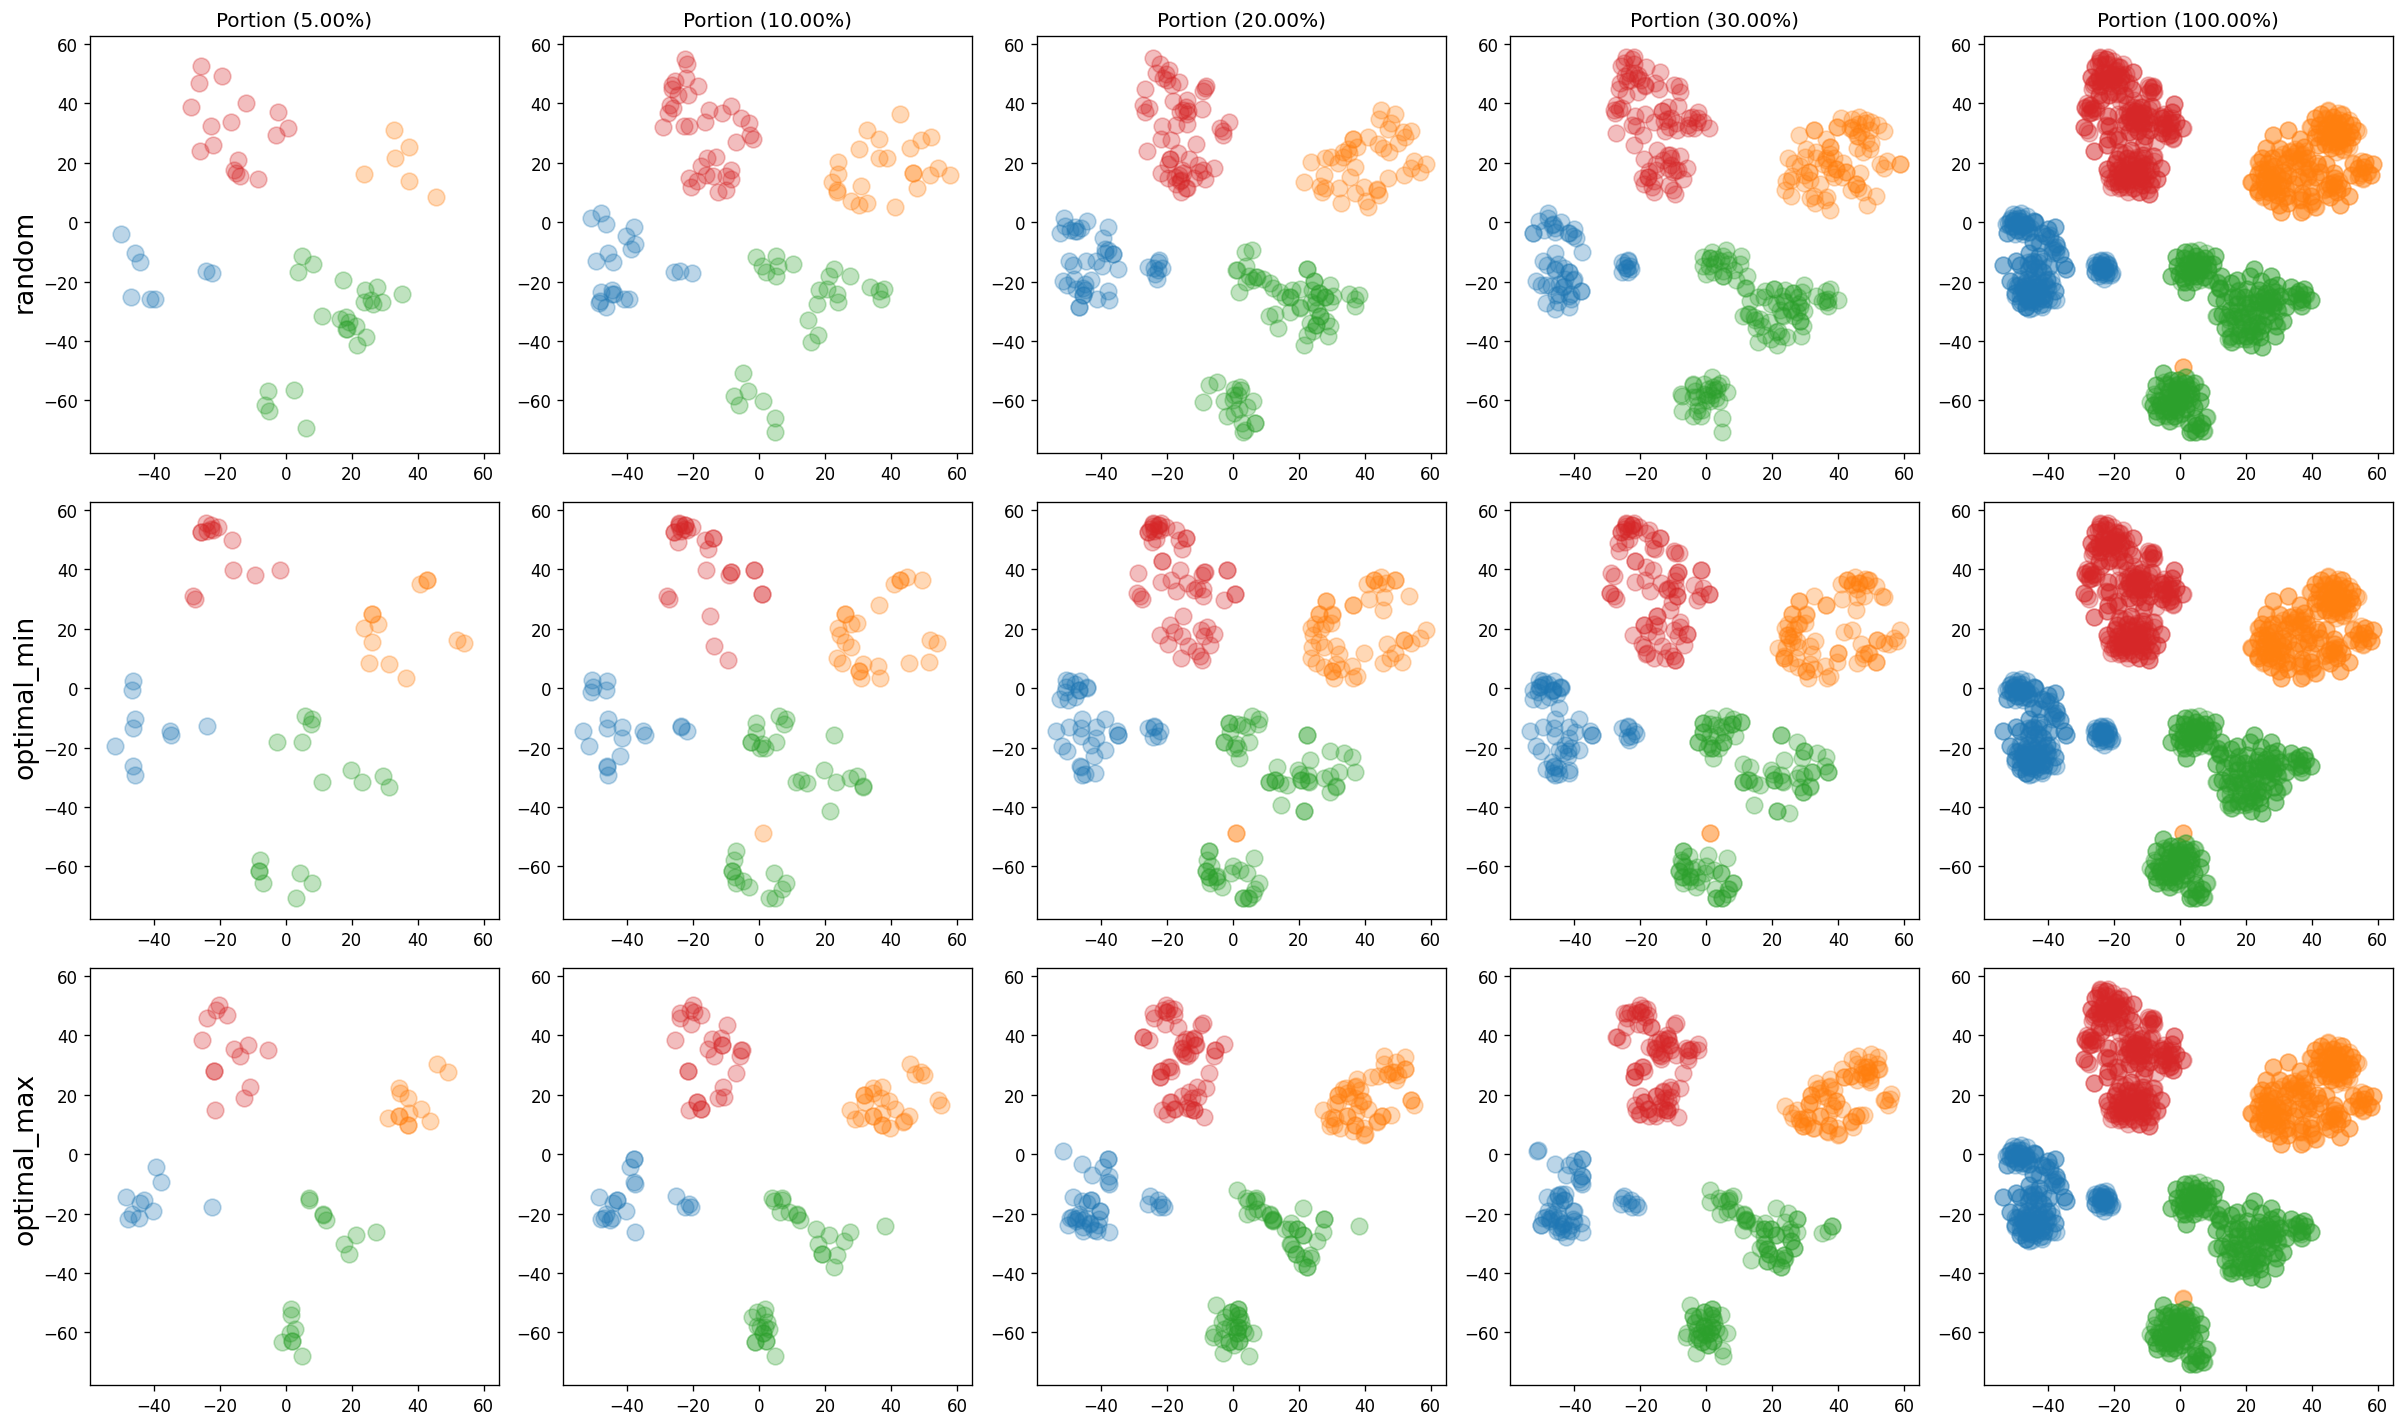

In [191]:
fig = plt.figure(figsize=(20, 12), dpi=120)
 
num_pert = 5
end = num_pert+1

plot_idx = np.arange(4)

labs = vectors_lab
sort_idx = np.argsort(sub_scores)


x_min,x_max = c_embedded[:, 0].min(), c_embedded[:, 0].max()
x_mag = max(np.abs(x_min), np.abs(x_max))

y_min,y_max = c_embedded[:, 1].min(), c_embedded[:, 1].max(), 
y_mag = max(np.abs(y_min), np.abs(y_max))

alpha=0.3
ratios   = [0.05, 0.1, 0.2, 0.3, 1]

num_pert = len(ratios)

# for i in range(1, num_pert+1):
for j,r in enumerate(ratios):
    
    i = j +1
    plt.subplot(3, num_pert, i)
    if j == len(ratios)-1:
        this_len = len(labs)
    else:
        this_len = int(len(labs)*r)
    
    plt.title('Portion ({:.2f}%)'.format(r*100))

    part_idx = np.random.choice(np.arange(len(labs)), size=this_len, replace=False)
    # print('random: ', len(part_idx)/len(labs))
    s_labs = labs[part_idx]
    
    plot_sub_idx = 0
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
        
        plot_sub_idx += len(c_embedded[:, 0][part_idx][this_idx])
    
    # print(plot_sub_idx/len(labs))
    
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.4, s='random', fontsize=16, rotation='vertical')
    plt.subplot(3,num_pert,i+num_pert)
    
    # s_labs   = labs[part_idx]
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.4, s='optimal_min', fontsize=16, rotation='vertical')
    
    for idx in plot_idx:
        this_idx = labs == idx
        thid_scores = sub_scores[this_idx]
        sort_idx = np.argsort(thid_scores)

        part_idx = sort_idx[:int(len(thid_scores)*r)]
        # print(thid_scores.shape, part_idx.shape)

        plt.scatter(c_embedded[:, 0][this_idx][part_idx], c_embedded[:, 1][this_idx][part_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
    plt.subplot(3,num_pert,i+num_pert+num_pert)

    # part_idx = sort_idx[-this_len:]
    # s_labs   = labs[part_idx]
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.4, s='optimal_max', fontsize=16, rotation='vertical')
    plot_sub_idx = 0
    for idx in plot_idx:
        this_idx = labs == idx
        thid_scores = sub_scores[this_idx]
        # print(thid_scores.shape)
        sort_idx = np.argsort(thid_scores)

        part_idx = sort_idx[-int(len(thid_scores)*r):]
        plot_sub_idx += len(part_idx)
        
        plt.scatter(c_embedded[:, 0][this_idx][part_idx], c_embedded[:, 1][this_idx][part_idx],
                    marker='o', s=100, alpha=alpha)
        
    # print(plot_sub_idx/len(this_idx))
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
plt.tight_layout()

plt.savefig('{}/optimal_random.tsne.balance.png'.format(imgs_dir))

### Optimal Sample Softmax

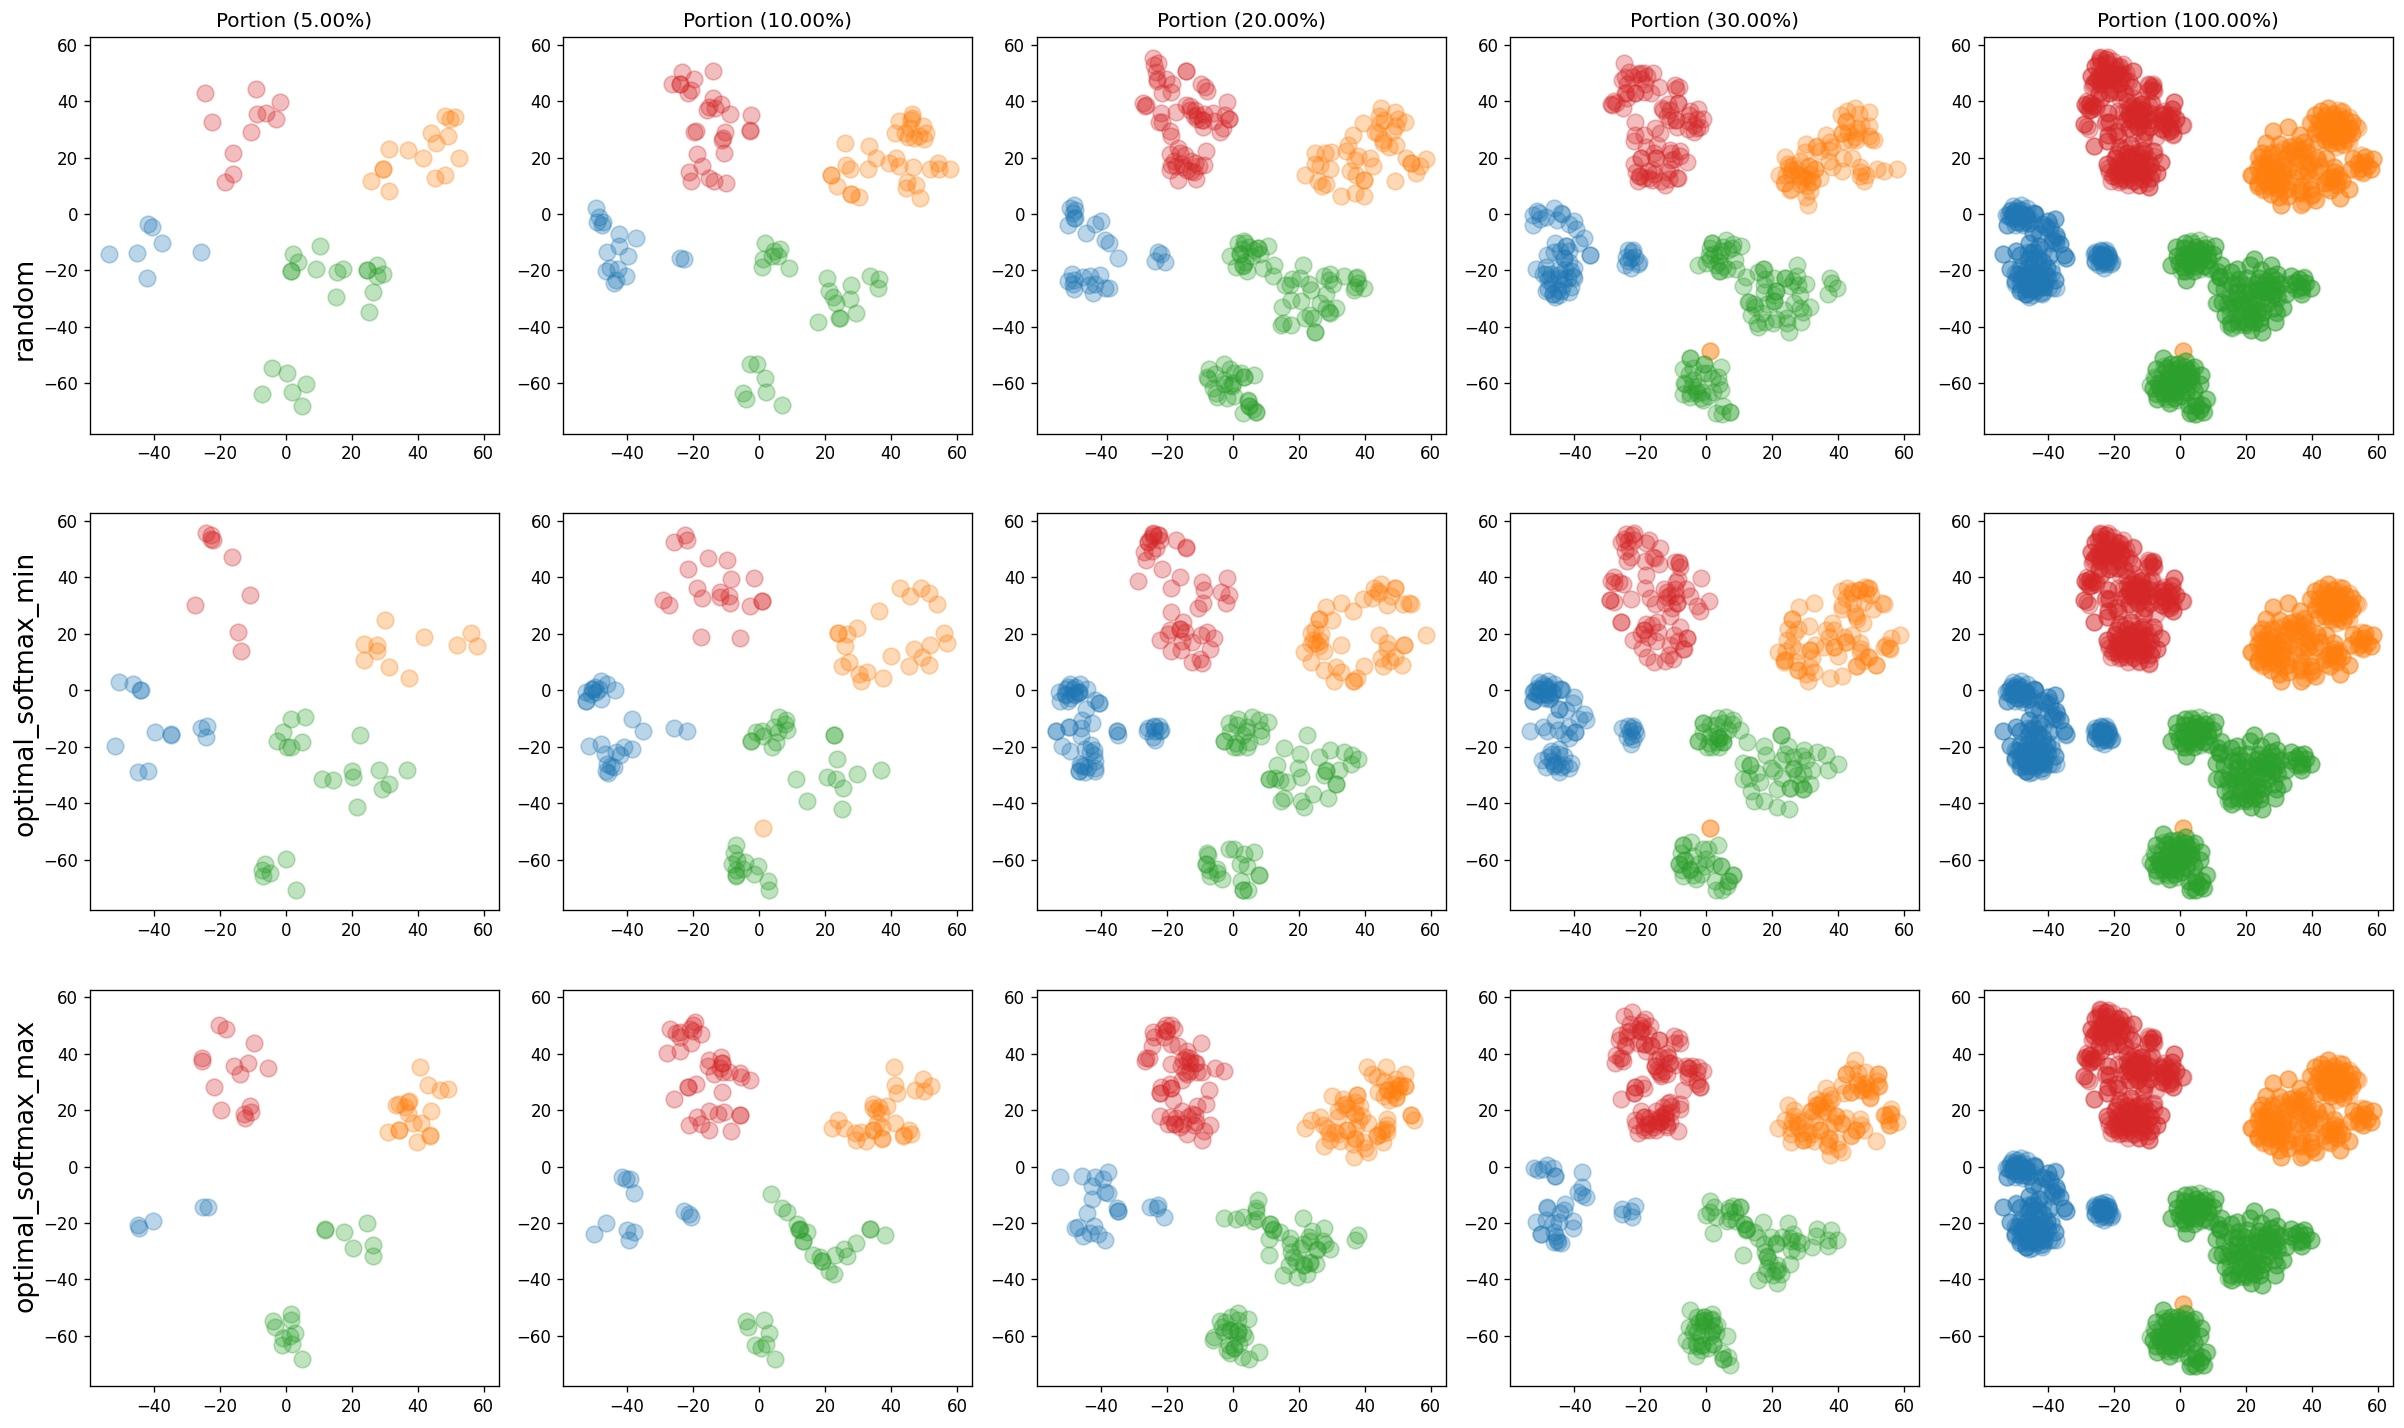

In [192]:
fig = plt.figure(figsize=(20, 12), dpi=120)
 

plot_idx = np.arange(4)

labs = vectors_lab
sort_idx = np.argsort(sub_scores)

x_min,x_max = c_embedded[:, 0].min(), c_embedded[:, 0].max()
x_mag = max(np.abs(x_min), np.abs(x_max))

y_min,y_max = c_embedded[:, 1].min(), c_embedded[:, 1].max(), 
y_mag = max(np.abs(y_min), np.abs(y_max))

alpha=0.3
ratios   = [0.05, 0.1, 0.2, 0.3, 1]


num_pert = len(ratios) #+ 1
end = num_pert+1

# for i in range(1, num_pert+1):
for j,r in enumerate(ratios):
    
    i = j +1
    plt.subplot(3, num_pert, i)
    if i == end-1:
        this_len = len(labs)
    else:
        this_len = int(len(labs)*r)
    
    plt.title('Portion ({:.2f}%)'.format(r*100))

    part_idx = np.random.choice(np.arange(len(labs)), size=this_len, replace=False)
    s_labs = labs[part_idx]
    
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.7, s='random', fontsize=16, rotation='vertical')
    plt.subplot(3,num_pert,i+num_pert)

    # part_idx = sort_idx[:this_len]
    if len(sub_scores) > this_len:
        idx = gumbel_softmax(torch.tensor(sub_scores.reshape(1, -1)).cuda(), num=len(sub_scores)-this_len).squeeze()
        part_idx = np.where(idx.cpu().numpy() == 0)[0]
    else:
        part_idx = np.arange(len(labs))
    
    s_labs   = labs[part_idx]
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.7, s='optimal_softmax_min', fontsize=16, rotation='vertical')
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
    plt.subplot(3,num_pert,i+num_pert+num_pert)

    idx = gumbel_softmax(torch.tensor(sub_scores.reshape(1, -1)).cuda(), num=this_len).squeeze()
    part_idx = np.where(idx.cpu().numpy() == 1)[0]
    s_labs   = labs[part_idx]
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.7, s='optimal_softmax_max', fontsize=16, rotation='vertical')
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
plt.tight_layout()

plt.savefig('{}/optimal_random.tsne.softmax.png'.format(imgs_dir))

### Optimal Sample Softmax Softmax

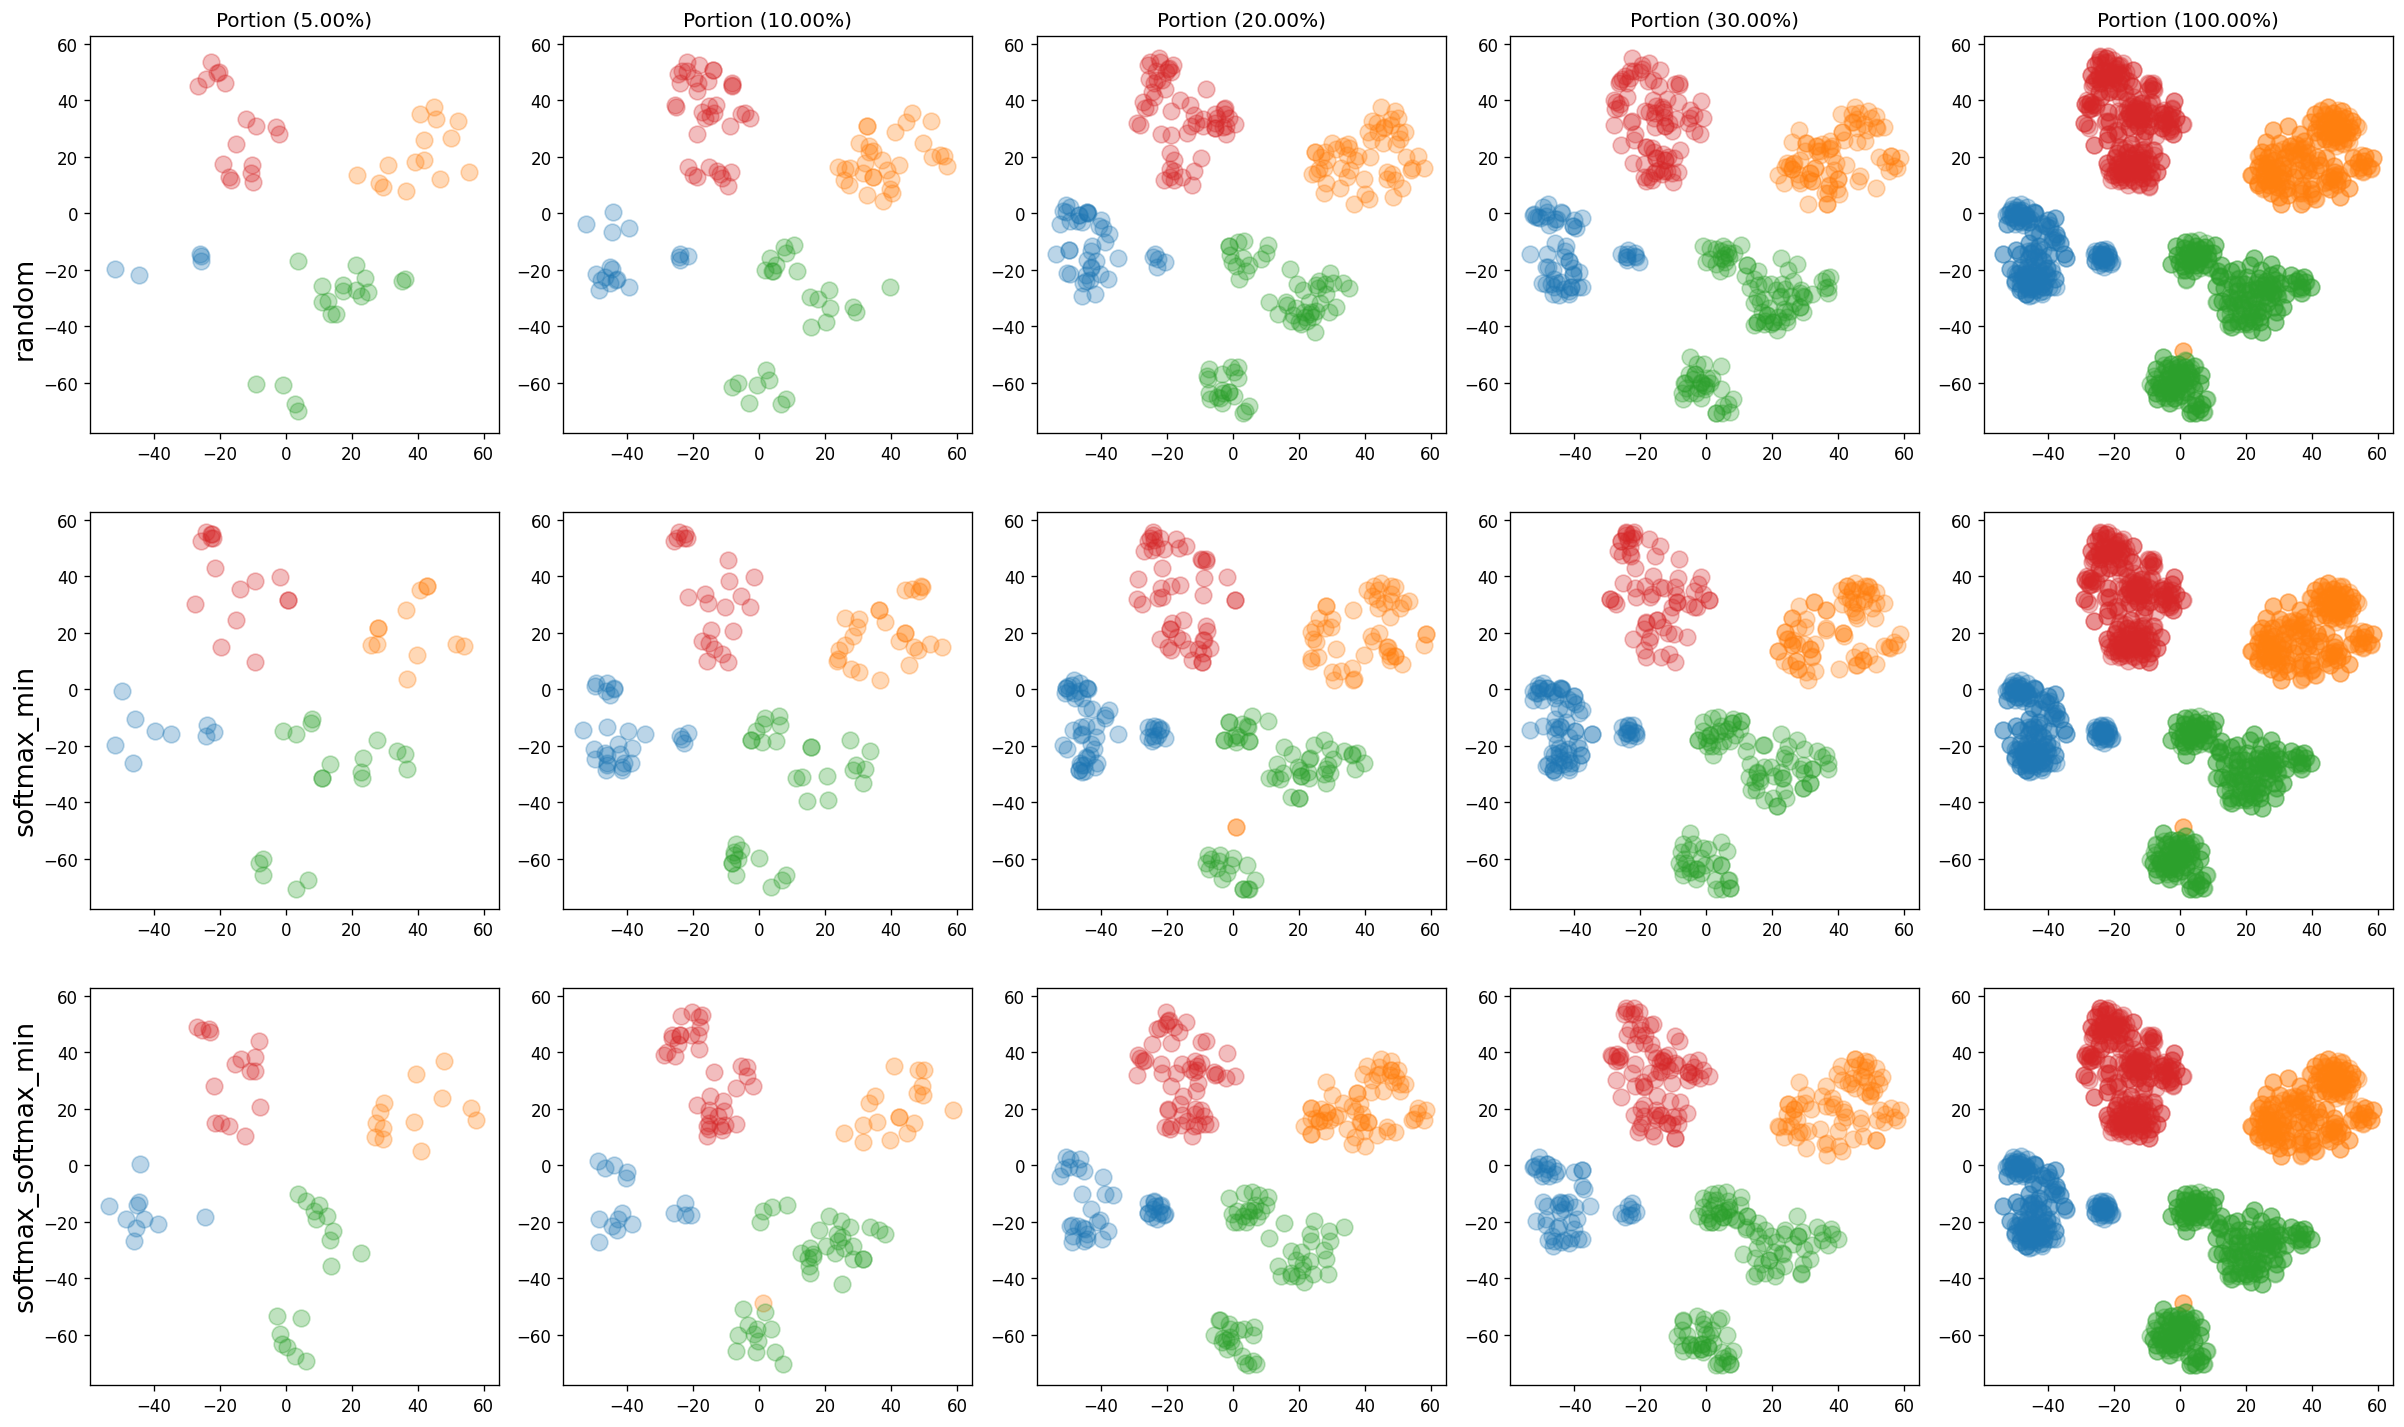

In [215]:
fig = plt.figure(figsize=(20, 12), dpi=120)
 

plot_idx = np.arange(4)

labs = vectors_lab
sort_idx = np.argsort(sub_scores)

x_min,x_max = c_embedded[:, 0].min(), c_embedded[:, 0].max()
x_mag = max(np.abs(x_min), np.abs(x_max))

y_min,y_max = c_embedded[:, 1].min(), c_embedded[:, 1].max(), 
y_mag = max(np.abs(y_min), np.abs(y_max))

alpha = 0.3
ratios   = [0.05, 0.1, 0.2, 0.3, 1]


num_pert = len(ratios) #+ 1
end = num_pert+1

# for i in range(1, num_pert+1):
for j,r in enumerate(ratios):
    
    i = j +1
    plt.subplot(3, num_pert, i)
    if i == end-1:
        this_len = len(labs)
    else:
        this_len = int(len(labs)*r)
    
    plt.title('Portion ({:.2f}%)'.format(r*100))

    part_idx = np.random.choice(np.arange(len(labs)), size=this_len, replace=False)
    s_labs = labs[part_idx]
    
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.7, s='random', fontsize=16, rotation='vertical')
    plt.subplot(3,num_pert,i+num_pert)

    # part_idx = sort_idx[:this_len]
    if len(sub_scores) > this_len:
        idx = gumbel_softmax(torch.tensor(sub_scores.reshape(1, -1)).cuda(), num=len(sub_scores)-this_len).squeeze()
        part_idx = np.where(idx.cpu().numpy() == 0)[0]
    else:
        part_idx = np.arange(len(labs))
    
    s_labs   = labs[part_idx]
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.7, s='softmax_min', fontsize=16, rotation='vertical')
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
    plt.subplot(3,num_pert,i+num_pert+num_pert)

    if len(sub_scores) > this_len:
        idx = gumbel_softmax(torch.softmax(torch.tensor(sub_scores.reshape(1, -1)).cuda(), dim=1), num=len(sub_scores)-this_len).squeeze()
        part_idx = np.where(idx.cpu().numpy() == 0)[0]
    else:
        part_idx = np.arange(len(labs))
        
    s_labs   = labs[part_idx]
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.7, s='softmax_softmax_min', fontsize=16, rotation='vertical')
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
plt.tight_layout()

# plt.savefig('{}/optimal_random.tsne.softmax.png'.format(imgs_dir))

In [ ]:
torch.softmax(sub_scores, dim=0)

### Optimal - Balance - Softmax

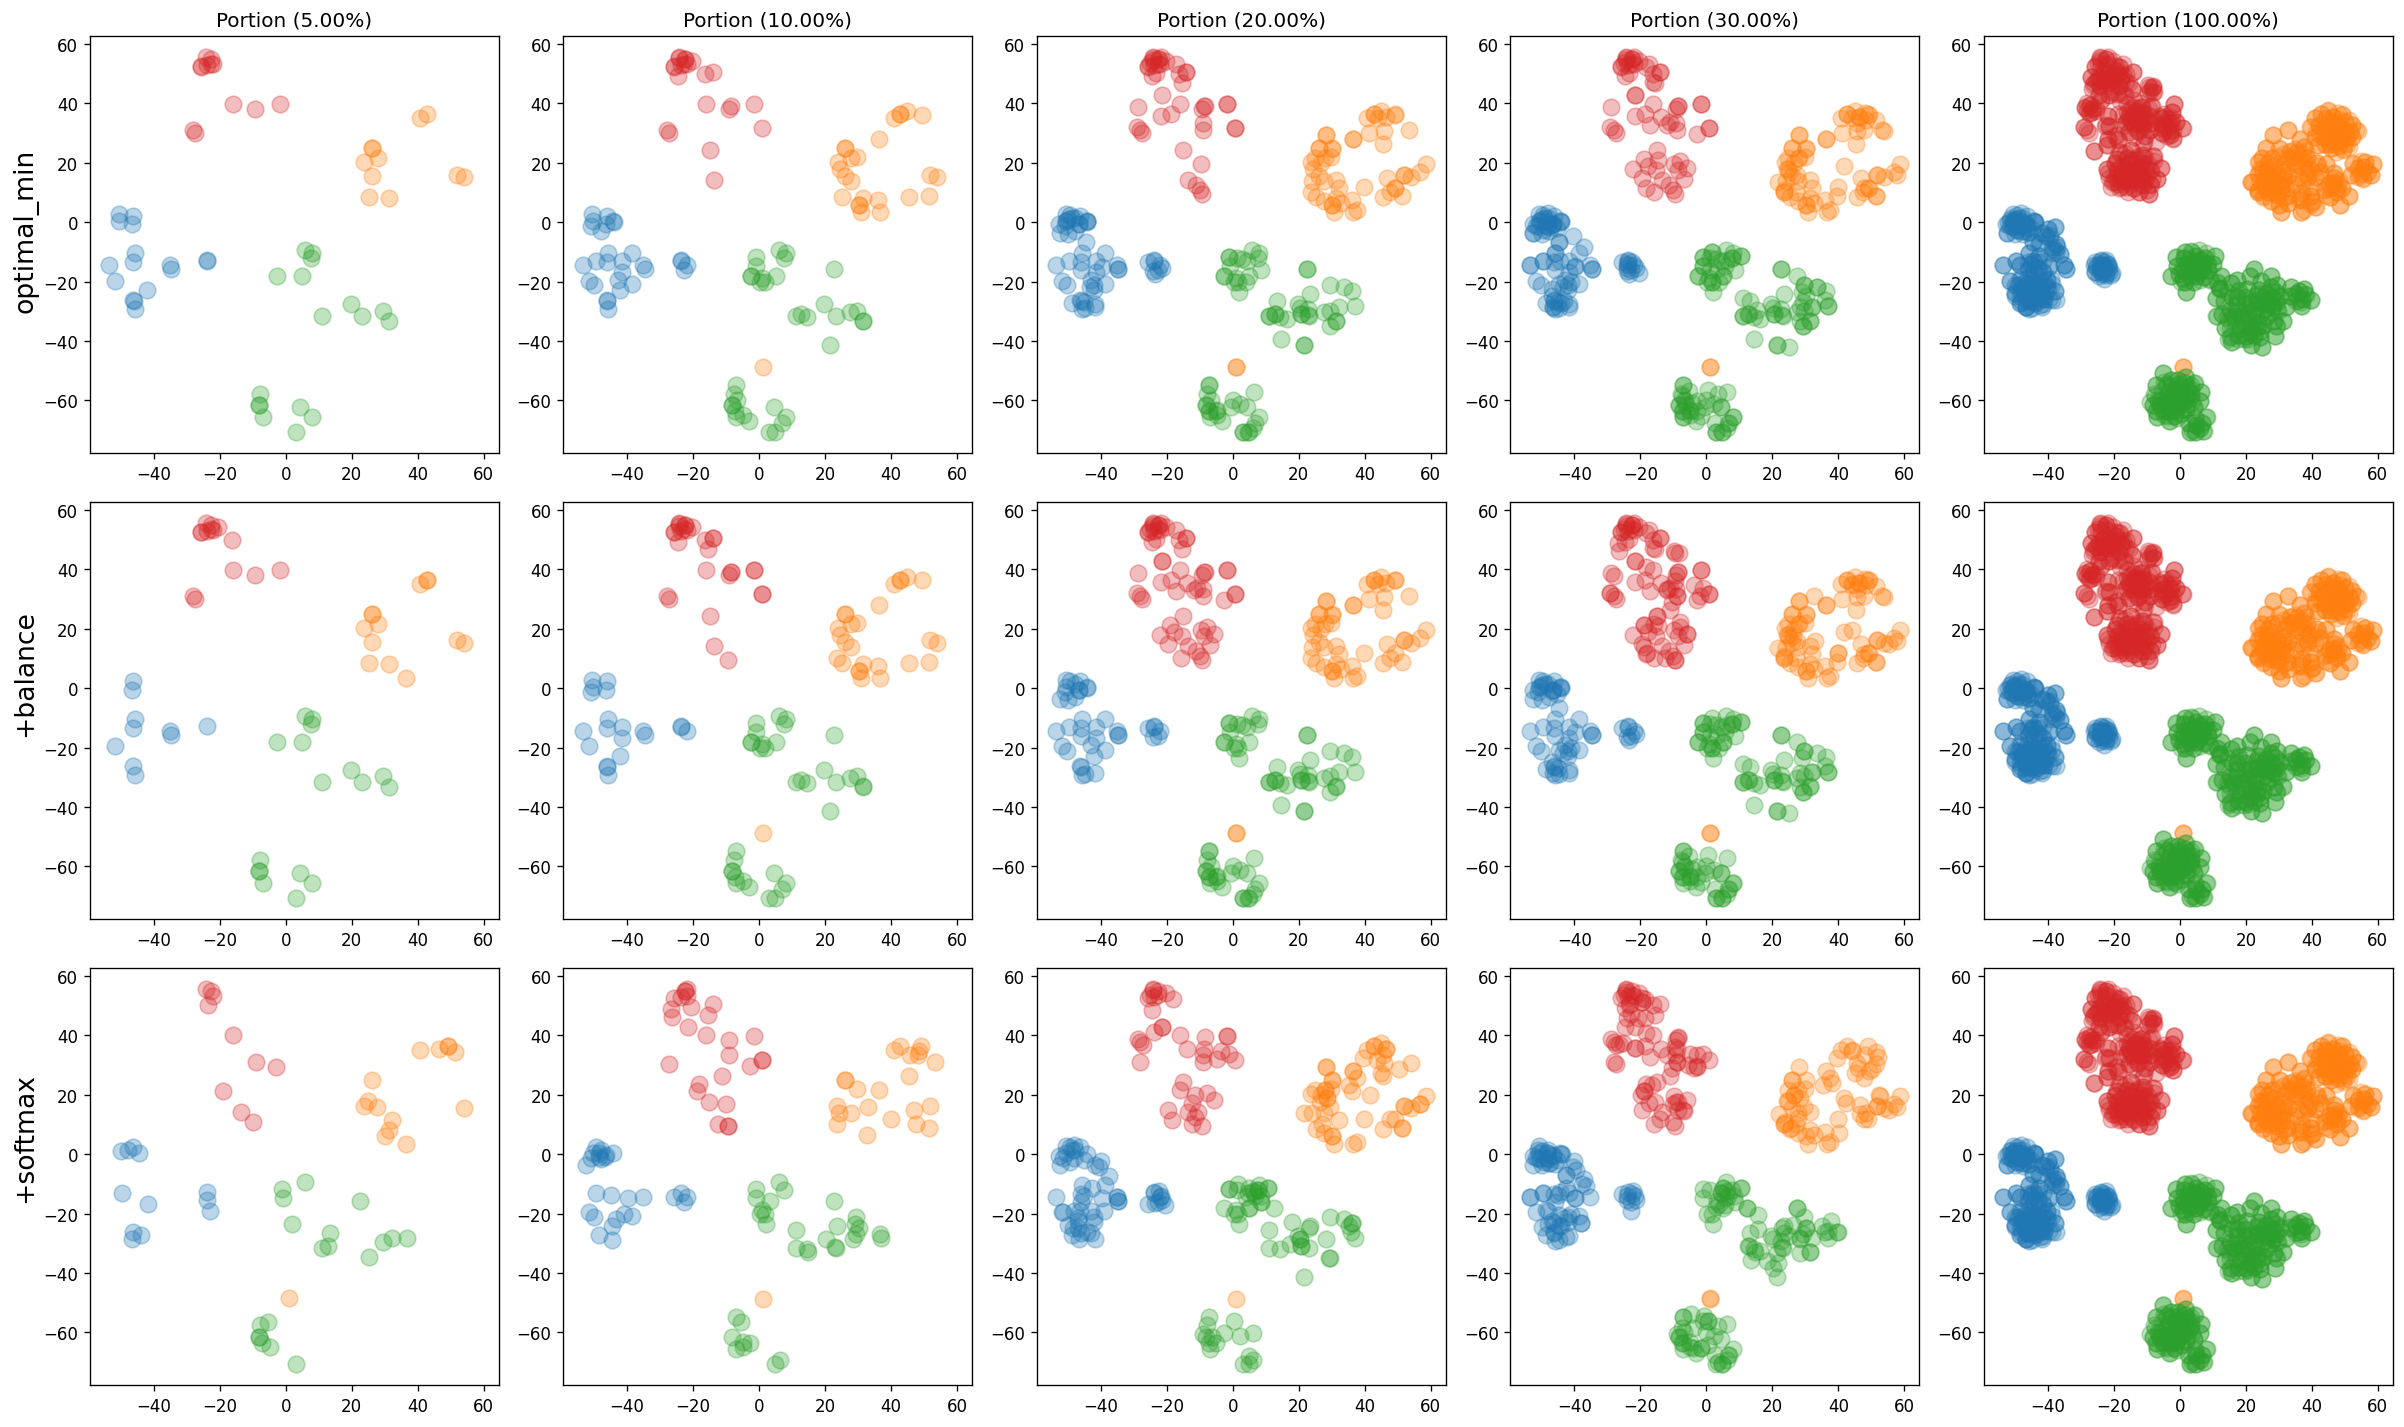

In [193]:
fig = plt.figure(figsize=(20, 12), dpi=120)
 

plot_idx = np.arange(4)

labs = vectors_lab
sort_idx = np.argsort(sub_scores)

x_min,x_max = c_embedded[:, 0].min(), c_embedded[:, 0].max()
x_mag = max(np.abs(x_min), np.abs(x_max))

y_min,y_max = c_embedded[:, 1].min(), c_embedded[:, 1].max(), 
y_mag = max(np.abs(y_min), np.abs(y_max))

alpha=0.3
ratios   = [0.05, 0.1, 0.2, 0.3, 1]


num_pert = len(ratios) #+ 1
end = num_pert+1

# for i in range(1, num_pert+1):
for j,r in enumerate(ratios):
    
    i = j +1
    plt.subplot(3, num_pert, i)
    if i == end-1:
        this_len = len(labs)
    else:
        this_len = int(len(labs)*r)
    
    plt.title('Portion ({:.2f}%)'.format(r*100))

    part_idx = sort_idx[:this_len]
    s_labs   = labs[part_idx]
    
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.4, s='optimal_min', fontsize=16, rotation='vertical')
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    

    plt.subplot(3,num_pert,i+num_pert)
    
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.2, s='+balance', fontsize=16, rotation='vertical')
    
    for idx in plot_idx:
        this_idx = labs == idx
        thid_scores = sub_scores[this_idx]
        this_sort_idx = np.argsort(thid_scores)

        part_idx = this_sort_idx[:int(len(thid_scores)*r)]
        # print(thid_scores.shape, part_idx.shape)

        plt.scatter(c_embedded[:, 0][this_idx][part_idx], c_embedded[:, 1][this_idx][part_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])
    
    plt.subplot(3,num_pert,i+num_pert+num_pert)
    # part_idx = sort_idx[:this_len]
    if len(sub_scores) > this_len:
        idx = gumbel_softmax(torch.tensor(sub_scores.reshape(1, -1)).cuda(), num=len(sub_scores)-this_len).squeeze()
        part_idx = np.where(idx.cpu().numpy() == 0)[0]
    else:
        part_idx = np.arange(len(labs))
    
    s_labs   = labs[part_idx]
    if i ==1:
        plt.text(x=x_min*1.55, y=y_min*0.2, s='+softmax', fontsize=16, rotation='vertical')
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=alpha)
        
    plt.xlim([x_min-x_mag*0.1, x_max+x_mag*0.1])
    plt.ylim([y_min-y_mag*0.1, y_max+y_mag*0.1])

    
plt.tight_layout()

plt.savefig('{}/optimal_random.tsne.min.balance.softmax.png'.format(imgs_dir))

### kcenters

In [107]:
def k_center_greedy(matrix, budget: int, metric, device, random_seed=None, index=None, already_selected=None,
                    print_freq: int = 20):
    if type(matrix) == torch.Tensor:
        assert matrix.dim() == 2
    elif type(matrix) == np.ndarray:
        assert matrix.ndim == 2
        matrix = torch.from_numpy(matrix).requires_grad_(False).to(device)

    sample_num = matrix.shape[0]
    assert sample_num >= 1

    if budget < 0:
        raise ValueError("Illegal budget size.")
    elif budget > sample_num:
        budget = sample_num

    if index is not None:
        assert matrix.shape[0] == len(index)
    else:
        index = np.arange(sample_num)

    assert callable(metric)

    already_selected = np.array(already_selected)

    with torch.no_grad():
        np.random.seed(random_seed)
        if already_selected.__len__() == 0:
            select_result = np.zeros(sample_num, dtype=bool)
            # Randomly select one initial point.
            already_selected = [np.random.randint(0, sample_num)]
            budget -= 1
            select_result[already_selected] = True
        else:
            select_result = np.in1d(index, already_selected)

        num_of_already_selected = np.sum(select_result)

        # Initialize a (num_of_already_selected+budget-1)*sample_num matrix storing distances of pool points from
        # each clustering center.
        dis_matrix = -1 * torch.ones([num_of_already_selected + budget - 1, sample_num], requires_grad=False).to(device)

        dis_matrix[:num_of_already_selected, ~select_result] = metric(matrix[select_result], matrix[~select_result])

        mins = torch.min(dis_matrix[:num_of_already_selected, :], dim=0).values

        for i in range(budget):
            # if i % print_freq == 0:
            #     print("| Selecting [%3d/%3d]" % (i + 1, budget))
            p = torch.argmax(mins).item()
            select_result[p] = True

            if i == budget - 1:
                break
            mins[p] = -1
            dis_matrix[num_of_already_selected + i, ~select_result] = metric(matrix[[p]], matrix[~select_result])
            mins = torch.min(mins, dis_matrix[num_of_already_selected + i])
    
    return index[select_result]

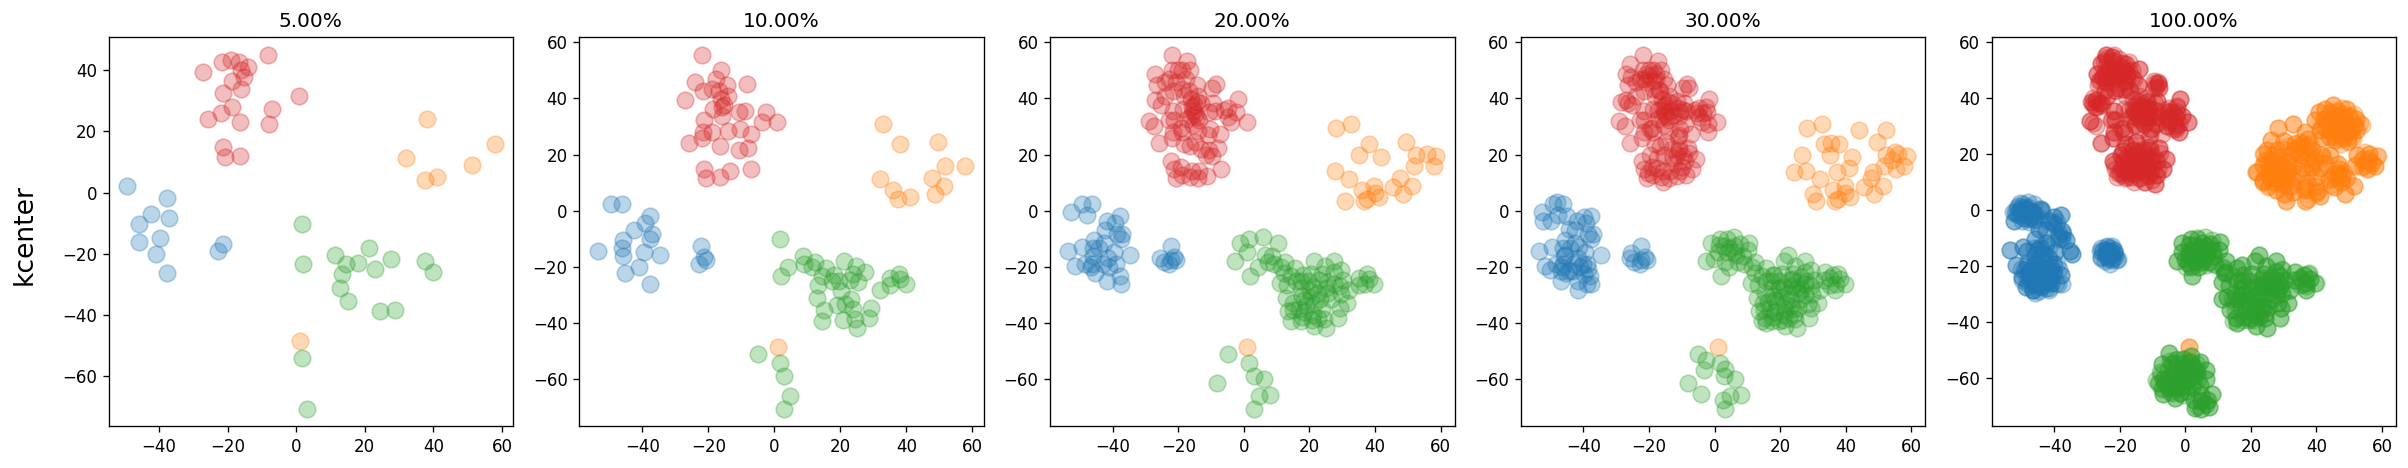

In [194]:
# x2 = torch.tensor(prototype_center[labs[x2_select_ids]]).type(dtype)
fig = plt.figure(figsize=(20, 4), dpi=120)
 
plot_idx = np.arange(10)
ratios   = [0.05, 0.1, 0.2, 0.3,]
num_pert = 1 + len(ratios)

for i, r in enumerate(ratios):
    budget = int(vectors.shape[0] * r)
    indexs = k_center_greedy(matrix=vectors, budget=budget, metric=cost_func, device='cpu', random_seed=1234,
                    index=None, already_selected=[])

    plt.subplot(1,num_pert,1+i)
    plt.title('{:.2f}%'.format(r*100))
    for idx in plot_idx:
        this_idx = vectors_lab[indexs] == idx
        plt.scatter(c_embedded[:, 0][indexs][this_idx], c_embedded[:, 1][indexs][this_idx],
                    marker='o', s=100, alpha=0.3)
    if i ==0:
        plt.text(x=x_min*1.55, y=y_min*0.4, s='kcenter', fontsize=16, rotation='vertical')
        
plt.subplot(1,num_pert,num_pert)
plt.title('{:.2f}%'.format(1*100))
for i in plot_idx:
    # this_idx = np.concatenate([s_labs, s_labs], axis=0) == i
    idx = vectors_lab == i
    plt.scatter(c_embedded[:, 0][idx], c_embedded[:, 1][idx],
                marker='o', s=100, alpha=0.3)

plt.tight_layout()
plt.savefig('{}/optimal_random.tsne.kcenters.png'.format(imgs_dir))

In [137]:
# gumbel_softmax(sub_scores.squeeze(), num=10)
for i in range(4):
    idx = gumbel_softmax(torch.tensor(sub_scores.reshape(1, -1)).cuda(), num=10).squeeze()
    print(np.where(idx.cpu().numpy() == 1))

(array([ 186,  217,  240,  252,  266,  275,  400,  583,  882, 1106]),)
(array([ 217,  267,  288,  384,  550,  719,  882, 1029, 1094, 1128]),)
(array([ 300,  362,  372,  445,  458,  786,  840,  882,  937, 1091]),)
(array([217, 246, 258, 268, 384, 485, 503, 586, 806, 882]),)


In [132]:
np.where(idx.cpu().numpy() == 1)

(array([ 217,  233,  293,  300,  309,  416,  641,  699,  999, 1106]),)

In [135]:
np.argsort(sub_scores)[:10]

array([ 688,  487,  499, 1116,  855,  760,  479,  137,  557,  261])

## Optimal Distance within Class

In [393]:
vectors_lab.shape

(1632,)

In [465]:
def plot_scores_minmax(s, c_embedded, within_idx, 
                       point_size, alpha, ratio, 
                       label_size, legend_size,
                       part='min',
                       balance=False, vectors_lab=None):

    if isinstance(s, torch.Tensor):
        s = s.numpy()
    
    plt.scatter(c_embedded[:, 0][within_idx],
                c_embedded[:, 1][within_idx],
                s=point_size, alpha=alpha,
                marker='o')
    
    print(f"Total-(mean/std): {c_embedded.mean(axis=0).sum():7>.3f}/{c_embedded.std(axis=0).sum():7>.3f}", end=' ')
    if balance:
        vlabs = set(vectors_lab)
        s_idx = []
        
        for v in vlabs:
            sub_vectors_lab = vectors_lab == v
            sub_s = s[sub_vectors_lab]
            sub_l = np.arange(len(vectors_lab))[sub_vectors_lab]
            if 'sample' in part:
                if 'min' in part:
                    tmp_l = np.random.choice(sub_l, p=sub_s/sub_s.sum(), 
                                             size=int(np.ceil((1-ratio)*len(sub_s))),
                                             replace=False)
                    s_idx.append(np.array(list(set(sub_l) - set(tmp_l))))
                else:
                    s_idx.append(np.random.choice(sub_l, p=sub_s/sub_s.sum(),
                                                  size=int(np.ceil(ratio*len(sub_s))),
                                                  replace=False))
                    
            elif part == 'min':
                s_idx.append(sub_l[np.argsort(sub_s)[:int(np.ceil(ratio*len(sub_s)))]])
            else:
                s_idx.append(sub_l[np.argsort(sub_s)[-int(np.ceil(ratio*len(sub_s))):]])

        s_idx = np.concatenate(s_idx)
        np.random.shuffle(s_idx)
        s_idx = s_idx[:int(ratio*len(s))]
    else:
        if 'sample' in part:
            if 'min' in part:
                tmp_l = np.random.choice(np.arange(len(s)), p=s/s.sum(), 
                                                 size=int(np.ceil((1-ratio)*len(s))),
                                                 replace=False)
                s_idx = np.array(list(set(np.arange(len(s))) - set(tmp_l)))
            else:
                s_idx = np.random.choice(np.arange(len(s)), p=s/s.sum(), 
                                                 size=int(np.ceil(ratio*len(s))),
                                                 replace=False)
        elif part == 'min':        
            s_idx = np.argsort(s)[:int(ratio*len(s))]
        else:
            s_idx = np.argsort(s)[-int(ratio*len(s)):]
    
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                s=point_size, alpha=alpha,
                marker='o')
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)  
    print(f"Subset-(mean/std): {c_embedded[within_idx][s_idx].mean(axis=0).sum():7>.3f}/{c_embedded[within_idx][s_idx].std(axis=0).sum():7>.3f}", end=' ')
    print(f'OT distance {float(loss_func(torch.tensor(c_embedded[s_idx]), torch.tensor(c_embedded)).cpu()):.4f}')
    plt.legend(['total', 'kept'], loc=4, fontsize=legend_size)

In [396]:
np.random.shuffle(s_idx)

In [288]:
from matplotlib.backends.backend_pdf import PdfPages

In [374]:
this_score = sub_scores.numpy()
this_score = (this_score - this_score.min()) / (this_score.max() - this_score.min())

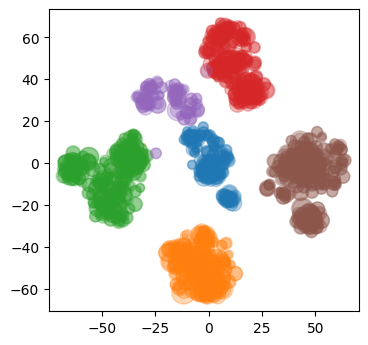

In [375]:
fig = plt.figure(figsize=(4, 4), dpi=100)

for i in np.arange(6):
    within_idx = vectors_lab == i
    plt.scatter(c_embedded[:, 0][within_idx],
                c_embedded[:, 1][within_idx],
                marker='o', s=this_score[within_idx]*300, alpha=0.3)

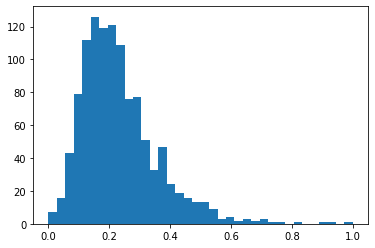

In [31]:
_ = plt.hist(this_score, bins='auto')

In [376]:
# within_idx = vectors_lab == 0
# within_idx = vectors_lab == 0

vec_0 = vectors #[within_idx]
idx_0 = np.arange(len(vec_0))

In [402]:
steps = 20
lr = 0.1
epochs = 20
w = torch.ones(len(idx_0))

In [385]:
xy_embed = torch.tensor(c_embedded)

#### Sub xy training

In [489]:
this_losses = []
metric = 'euclidean'
w = torch.ones(len(idx_0))
steps = 20
lr = 0.01
epochs = 20

for i in tqdm(range(epochs), ncols=50):
    this_batidx = np.random.choice(idx_0, size=128, replace=False)
    other_idx = np.array(list(set(idx_0) - set(this_batidx)))

#     x1 = vec_0[this_batidx].clone().cuda()
#     x2 = vec_0[other_idx].clone().cuda()
    
    x1 = xy_embed[this_batidx].clone().cuda()
    x2 = xy_embed[other_idx].clone().cuda()
    # x2 = xy_embed.clone().cuda()
    # x2 = vec_0.clone().cuda()
    dloss = MultiRatioDist_loss(w[this_batidx], metric=metric,
                # ratios=[0.1, 0.25, 0.5, 0.75, 0.9],
                ratios=[0.75,]*5,
                temperature=1,
                sample_ratio=5).cuda()
    # dloss = MultiRatioStdDist_loss(w[this_batidx], metric=metric,
    #             ratios=[0.1, 0.25, 0.5, 0.75, 0.9],
    #             sample_ratio=5).cuda()
    opt = torch.optim.Adam(dloss.parameters(), lr=lr, weight_decay=0)
        
    for j in range(steps):    

        L_αβ = dloss(x1, x2)
        this_losses.append(float(L_αβ.item()))
        
        L_αβ.backward()
        opt.step()
        opt.zero_grad()
        
    w[this_batidx] = dloss.w.data.cpu()

100%|█████████████| 20/20 [00:26<00:00,  1.32s/it]


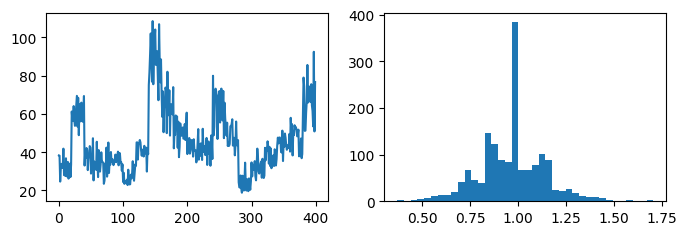

In [490]:
fig = plt.figure(figsize=(8, 2.5), dpi=100)

plt.subplot(1,2,1)
plt.plot(this_losses)

plt.subplot(1,2,2)
this_w = w.numpy()
# this_w = 1/np.exp((this_w - this_w.min()) / (this_w.max() - this_w.min()))
_ = plt.hist(this_w, bins='auto')

Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.925/65.987 OT distance 25.2765
Total-(mean/std): -0.326/64.789 Subset-(mean/std): 1.224/56.563 OT distance 47.9541
Total-(mean/std): -0.326/64.789 Subset-(mean/std): -3.635/73.390 OT distance 64.8854


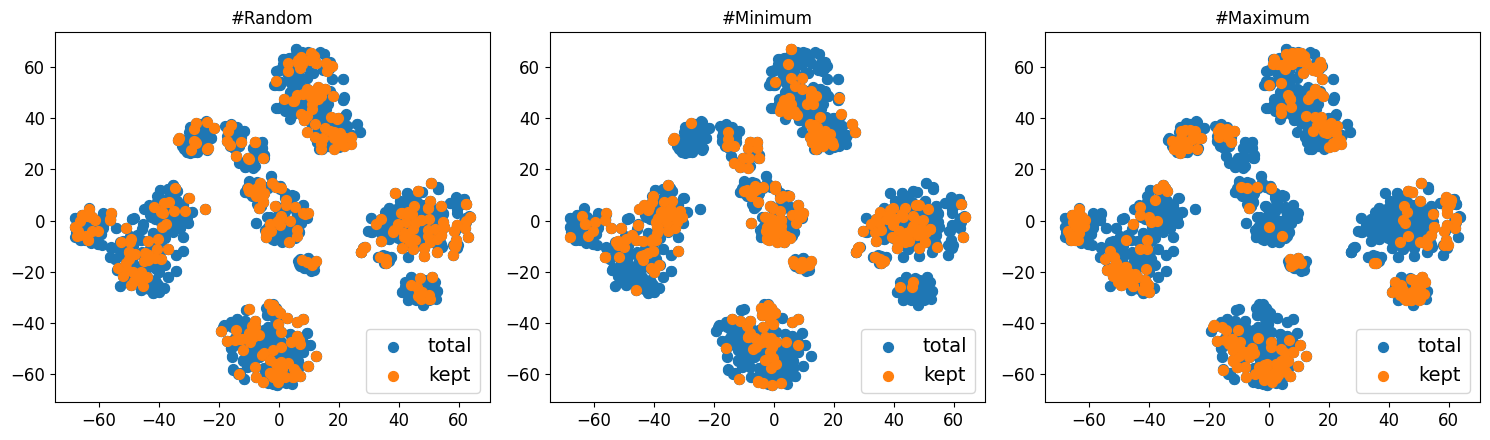

In [491]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# pdf = PdfPages('imgs/opcs/opcs_maxmin.pdf')
dpi = 100
fig = plt.figure(figsize=(15, 4.5), dpi=dpi)

ratio = 0.2
alpha = 1
point_size = 50

plt.subplot(1,3,1)
plt.title('#Random')

within_idx = np.arange(len(vectors_lab))

s = torch.randn(len(w))
s = s.numpy()
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='min')
    
    
plt.subplot(1,3,2)
plt.title('#Minimum')

within_idx = np.arange(len(vectors_lab))

s = torch.softmax(w.squeeze(), dim=0)
s = s.numpy()
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='min')
    
plt.subplot(1,3,3)
plt.title('#Maximum')
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='max')

plt.tight_layout()

# pdf.savefig()
# pdf.close()
# plt.savefig('')

# multiscale
# Total-(mean/std): -1.170/56.597 Subset-(mean/std): -4.088/50.697
# Total-(mean/std): -1.170/56.597 Subset-(mean/std): -3.637/63.288

# multiscale+std
# Total-(mean/std): -1.170/56.597 Subset-(mean/std): -10.585/49.161
# Total-(mean/std): -1.170/56.597 Subset-(mean/std): -3.355/64.668

# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -0.195/54.318
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 3.345/68.183

# temp=2
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.925/65.987 OT distance 25.2765
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 4.041/56.914 OT distance 81.3450
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.632/69.091 OT distance 41.4769

# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.925/65.987 OT distance 25.2765
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 1.469/57.921 OT distance 55.3749
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.797/73.548 OT distance 88.5072

Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.925/65.987 OT distance 25.2765
Total-(mean/std): -0.326/64.789 Subset-(mean/std): 2.804/65.137 OT distance 19.0819
Total-(mean/std): -0.326/64.789 Subset-(mean/std): 3.770/64.795 OT distance 26.4901


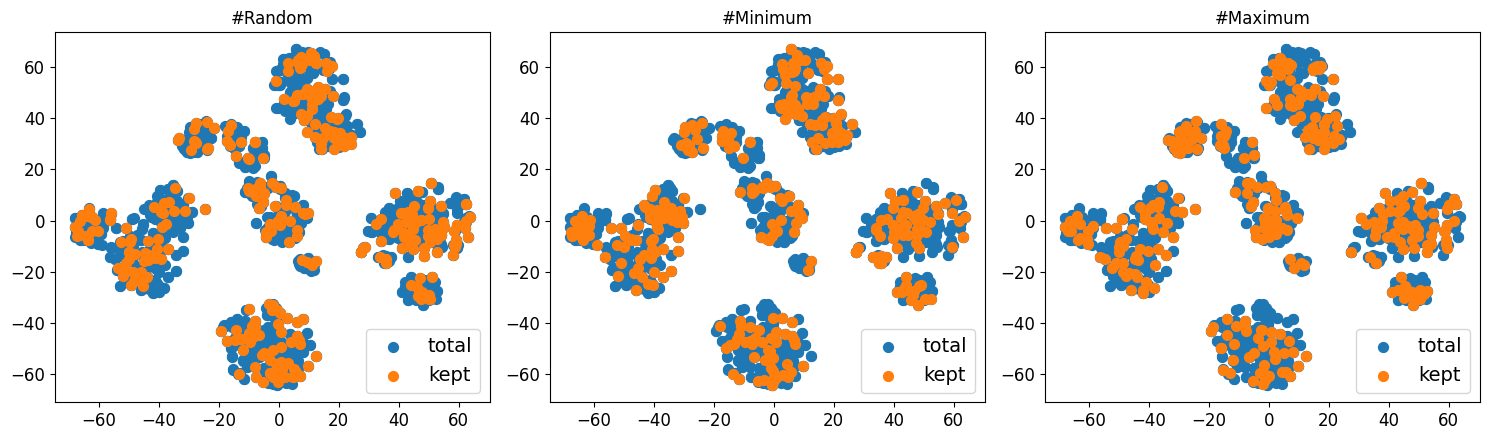

In [493]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# pdf = PdfPages('imgs/opcs/opcs_maxmin.pdf')
dpi = 100
fig = plt.figure(figsize=(15, 4.5), dpi=dpi)

ratio = 0.2
alpha = 1
point_size = 50

plt.subplot(1,3,1)
plt.title('#Random')

within_idx = np.arange(len(vectors_lab))

s = torch.randn(len(w))
s = s.numpy()
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='min')
    
    
plt.subplot(1,3,2)
plt.title('#Minimum')

within_idx = np.arange(len(vectors_lab))

s = torch.softmax(w.squeeze(), dim=0)
s = s.numpy()
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='samplemin')
    
plt.subplot(1,3,3)
plt.title('#Maximum')
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='samplemax')

plt.tight_layout()

# pdf.savefig()
# pdf.close()
# plt.savefig('')

# multiscale
# Total-(mean/std): -1.170/56.597 Subset-(mean/std): -4.088/50.697
# Total-(mean/std): -1.170/56.597 Subset-(mean/std): -3.637/63.288

# multiscale+std
# Total-(mean/std): -1.170/56.597 Subset-(mean/std): -10.585/49.161
# Total-(mean/std): -1.170/56.597 Subset-(mean/std): -3.355/64.668

# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -0.195/54.318
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 3.345/68.183

# temp=2
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.925/65.987 OT distance 25.2765
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 4.041/56.914 OT distance 81.3450
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.632/69.091 OT distance 41.4769

# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.925/65.987 OT distance 25.2765
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 1.469/57.921 OT distance 55.3749
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.797/73.548 OT distance 88.5072

Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.479/65.510 OT distance 9.1637
Total-(mean/std): -0.326/64.789 Subset-(mean/std): -0.012/58.985 OT distance 26.5754
Total-(mean/std): -0.326/64.789 Subset-(mean/std): -2.124/70.421 OT distance 29.8752


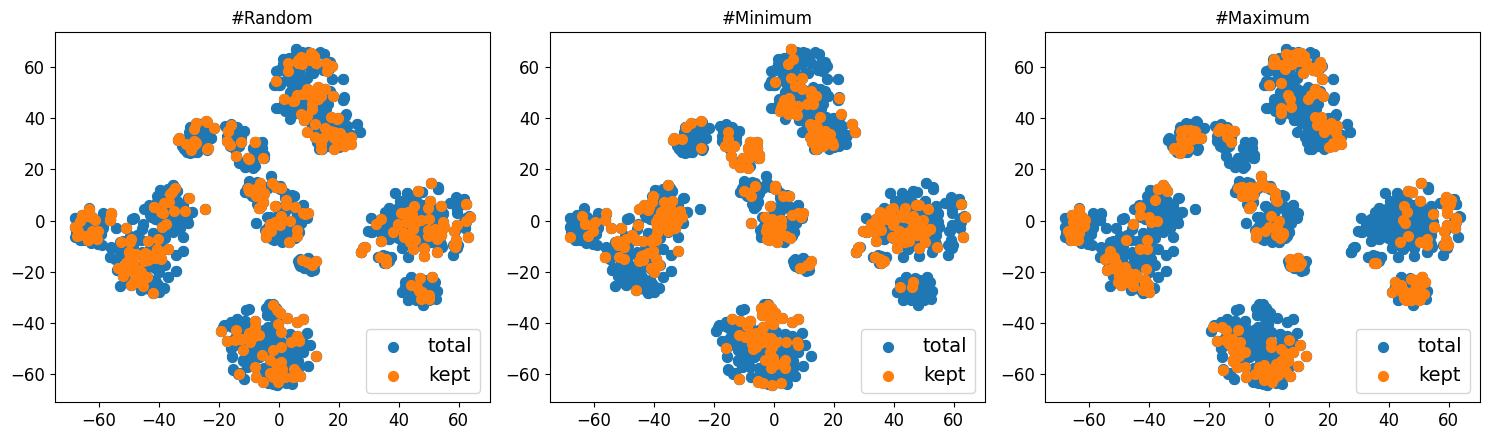

In [494]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# pdf = PdfPages('imgs/opcs/opcs_maxmin.pdf')
fig = plt.figure(figsize=(15, 4.5), dpi=dpi)

ratio = 0.2
alpha = 1
point_size = 50
balance = True

plt.subplot(1,3,1)
plt.title('#Random')

s = torch.randn(len(w))
s = s.numpy()
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='min',
                  balance=balance, vectors_lab=vectors_lab)
    
plt.subplot(1,3,2)
plt.title('#Minimum')

within_idx = np.arange(len(vectors_lab))

s = torch.softmax(w.squeeze(), dim=0)
s = s.numpy()
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='min',
                   balance=balance, vectors_lab=vectors_lab)
    
plt.subplot(1,3,3)
plt.title('#Maximum')
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='max',
                   balance=balance, vectors_lab=vectors_lab)

plt.tight_layout()

# multiscale balance
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.208/56.615
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.146/69.049

# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.889/60.674
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.603/65.526

# temp=2
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.479/65.510 OT distance 9.1637
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.826/63.126 OT distance 11.7432
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -0.520/67.219 OT distance 17.7427

# ratio-0.75
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.479/65.510 OT distance 9.1637
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -0.096/61.625 OT distance 12.3818
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -0.867/69.769 OT distance 22.6242

Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.479/65.510 OT distance 9.1637
Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.142/61.223 OT distance 12.0578
Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.102/68.451 OT distance 14.6024


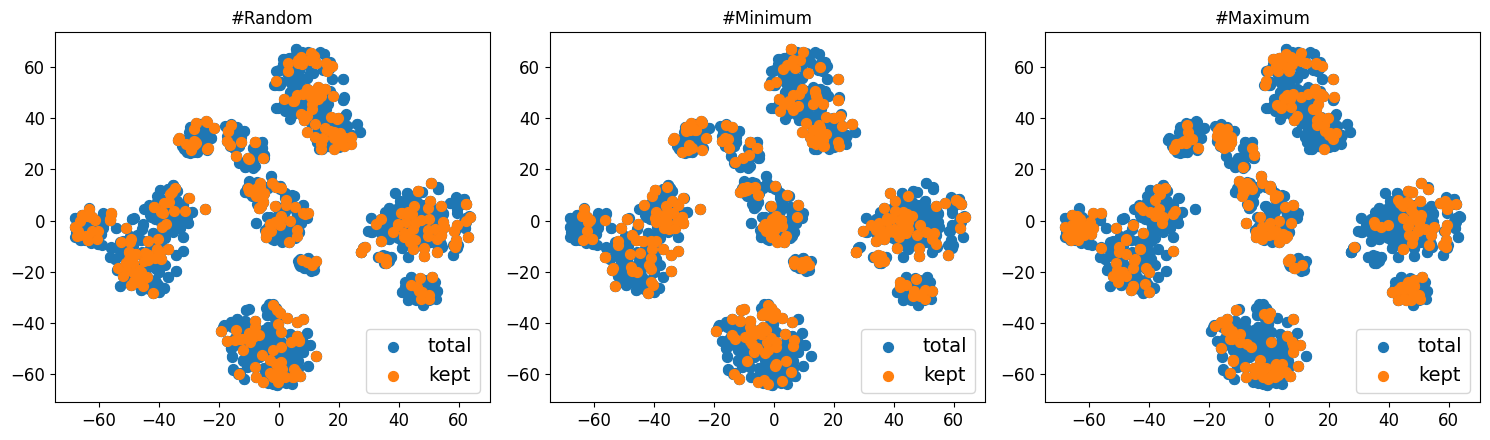

In [467]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# pdf = PdfPages('imgs/opcs/opcs_maxmin.pdf')
fig = plt.figure(figsize=(15, 4.5), dpi=dpi)

ratio = 0.2
alpha = 1
point_size = 50
balance = True

plt.subplot(1,3,1)
plt.title('#Random')

s = torch.randn(len(w))
s = s.numpy()
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='min',
                  balance=balance, vectors_lab=vectors_lab)
    
plt.subplot(1,3,2)
plt.title('#Minimum')

within_idx = np.arange(len(vectors_lab))

s = torch.softmax(w.squeeze(), dim=0)
s = s.numpy()
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='samplemin',
                   balance=balance, vectors_lab=vectors_lab)
    
plt.subplot(1,3,3)
plt.title('#Maximum')
plot_scores_minmax(s, c_embedded, within_idx, 
                   point_size, alpha, ratio, 
                   label_size, legend_size, part='samplemax',
                   balance=balance, vectors_lab=vectors_lab)

plt.tight_layout()

# multiscale balance
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.208/56.615
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.146/69.049

# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.889/60.674
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.603/65.526

# temp=2
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.479/65.510 OT distance 9.1637
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): 0.826/63.126 OT distance 11.7432
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -0.520/67.219 OT distance 17.7427

# ratio-0.75
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -1.479/65.510 OT distance 9.1637
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -0.096/61.625 OT distance 12.3818
# Total-(mean/std): -0.326/64.789 Subset-(mean/std): -0.867/69.769 OT distance 22.6242

In [323]:
legend_size = 14
label_size = 12
point_size = 100
alpha = 1
dpi=150

52.41031 56.954727
56.954727 51.115257


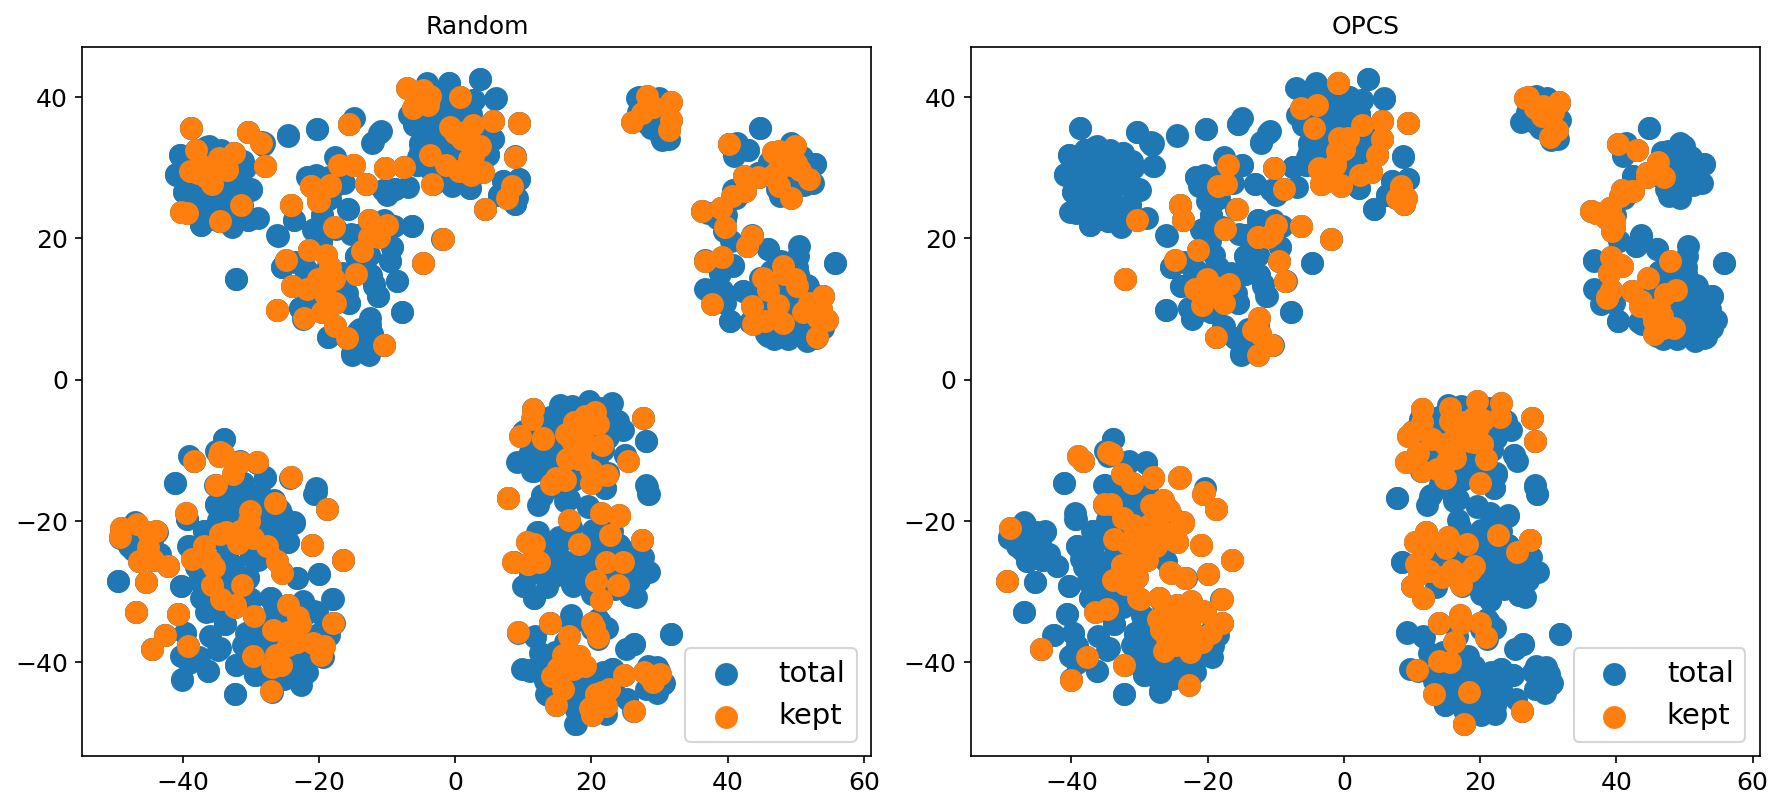

In [327]:
pdf = PdfPages('imgs/opcs/random_opcs.pdf')
fig = plt.figure(figsize=(12, 5.5), dpi=dpi)

ratio = 0.25
plt.subplot(1,2,1)
plt.title('Random')
for i in np.arange(1):
    # within_idx = vectors_lab == i
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    s -= s.min()
    
    # s_idx = np.argsort(s)[-int(ratio*len(s)):]
    s = torch.softmax(torch.tensor(s).squeeze(), dim=0)
    s = s.numpy()
    # print(len(s), s.sum())
    s_idx = np.random.choice(np.arange(len(s)), p=s/s.sum(), size=int((1-ratio)*len(s)), replace=False)
    s_idx = np.array(list(set(np.arange(len(s))) - set(s_idx)))
    
    size = np.log(s[s_idx]*200)
    size -= size.min()
    size /= size.max() * point_size
    
    plt.scatter(c_embedded[:, 0][within_idx],
                c_embedded[:, 1][within_idx],
                s=point_size, alpha=alpha,
                marker='o')
    # print((s[s_idx]*200).min(), (s[s_idx]*200).max())
    # print(s[s_idx])
    
    print(c_embedded[within_idx][s_idx].std(axis=0).sum(), end = ' ')
    # s = -w.numpy()
    # s -= s.min()
    # s_idx = np.argsort(s)[:-int(ratio*len(s))]
    
    s_idx = np.random.choice(np.arange(len(s)),
                             #p=s/s.sum(),
                             size=int(ratio*len(s)), replace=False)
    
    size = np.log(s[s_idx]*200)
    size -= size.min()
    size /= size.max() * point_size
    
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                s=point_size, alpha=alpha,
                marker='o')
    
    # print((s[s_idx]*200).min(), (s[s_idx]*200).max())
    
    print(c_embedded[within_idx][s_idx].std(axis=0).sum())
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)
    plt.legend(['total', 'kept'], loc=4, fontsize=legend_size)
    
    
# fig = plt.figure(figsize=(8, 8), dpi=100)
plt.subplot(1,2,2)
plt.title('OPCS')

for i in np.arange(1):
    # within_idx = vectors_lab == i
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    s -= s.min()
    
    size = s[s_idx]
    size -= size.min()
    size /= size.max() * 0.025

    plt.scatter(c_embedded[:, 0][within_idx],
                c_embedded[:, 1][within_idx],
                s=point_size, alpha=alpha,
                marker='o')
    
    print(c_embedded[within_idx][s_idx].std(axis=0).sum(), end = ' ')

    size = s[s_idx]
    size -= size.min()
    size /= size.max() * 0.025
    
    s_idx = np.argsort(s)[:int(ratio*len(s))]
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                s=point_size, alpha=alpha,
                marker='o',)
    
    print(c_embedded[within_idx][s_idx].std(axis=0).sum())
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)
    
    plt.legend(['total', 'kept'], loc=4, fontsize=legend_size)

plt.tight_layout()

pdf.savefig()
pdf.close()

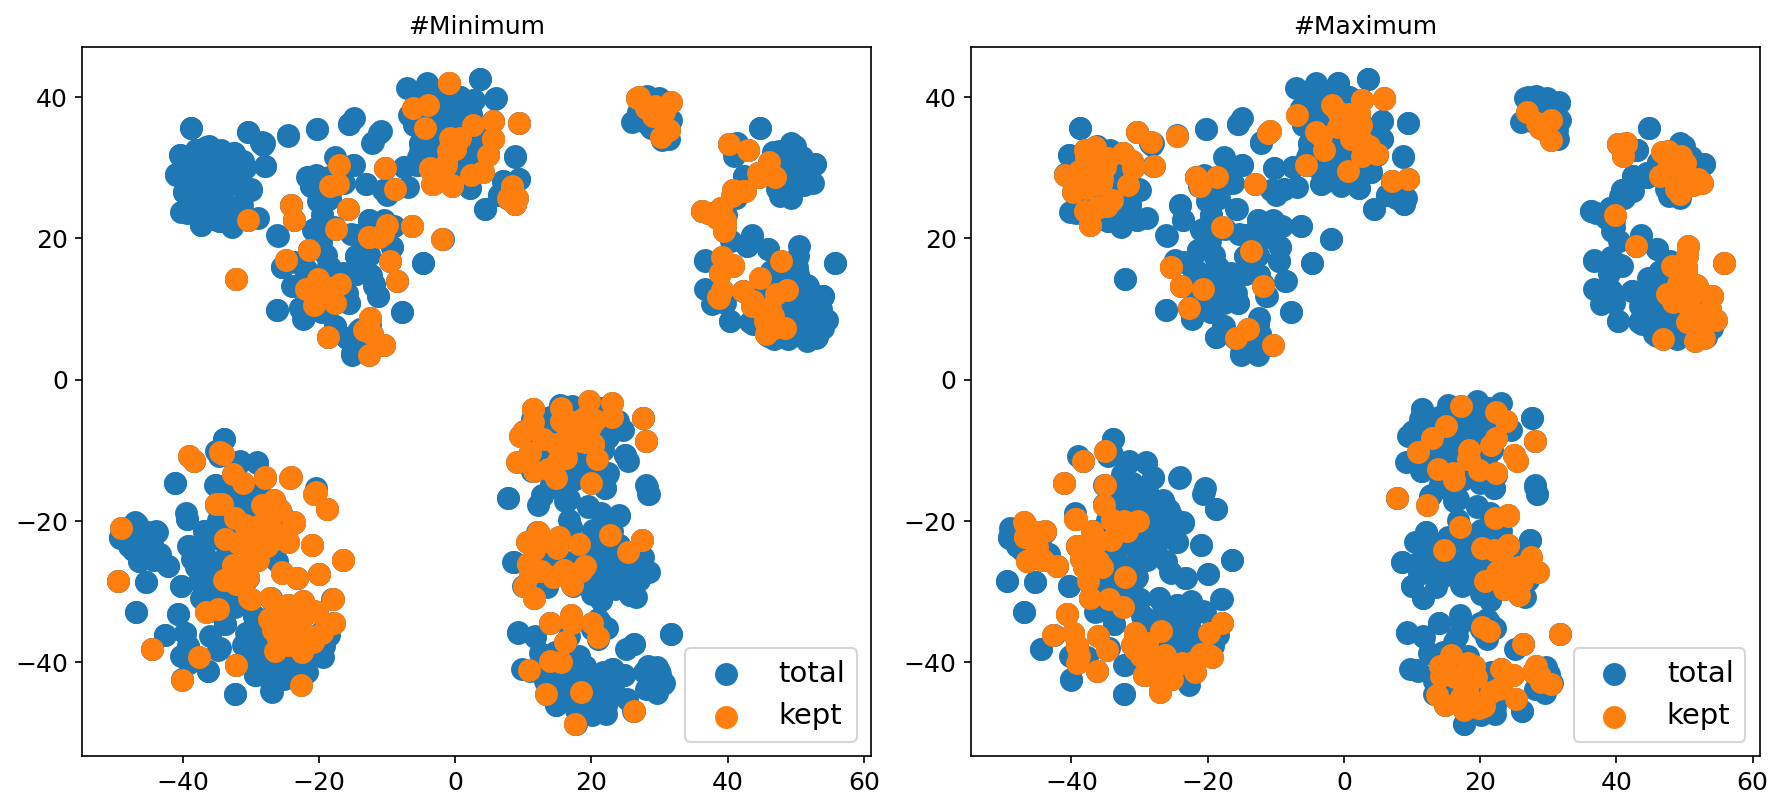

In [328]:
pdf = PdfPages('imgs/opcs/opcs_maxmin.pdf')
fig = plt.figure(figsize=(12, 5.5), dpi=dpi)

ratio = 0.25
plt.subplot(1,2,1)
plt.title('#Minimum')
for i in np.arange(1):
    # within_idx = vectors_lab == i
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    
    s = torch.softmax(torch.tensor(s).squeeze(), dim=0)
    s = s.numpy()
    
    plt.scatter(c_embedded[:, 0][within_idx],
                c_embedded[:, 1][within_idx],
                s=point_size, alpha=alpha,
                marker='o')

    
    s_idx = np.argsort(s)[:int(ratio*len(s))]
    
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                s=point_size, alpha=alpha,
                marker='o')
    
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)
    plt.legend(['total', 'kept'], loc=4, fontsize=legend_size)
    
    
# fig = plt.figure(figsize=(8, 8), dpi=100)
plt.subplot(1,2,2)
plt.title('#Maximum')

for i in np.arange(1):
    
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    
    s = torch.softmax(torch.tensor(s).squeeze(), dim=0)
    s = s.numpy()
    
    plt.scatter(c_embedded[:, 0][within_idx],
                c_embedded[:, 1][within_idx],
                s=point_size, alpha=alpha,
                marker='o')

    s_idx = np.argsort(s)[-int(ratio*len(s)):]
    
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                s=point_size, alpha=alpha,
                marker='o')
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)      
    plt.legend(['total', 'kept'], loc=4, fontsize=legend_size)

plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.savefig('')

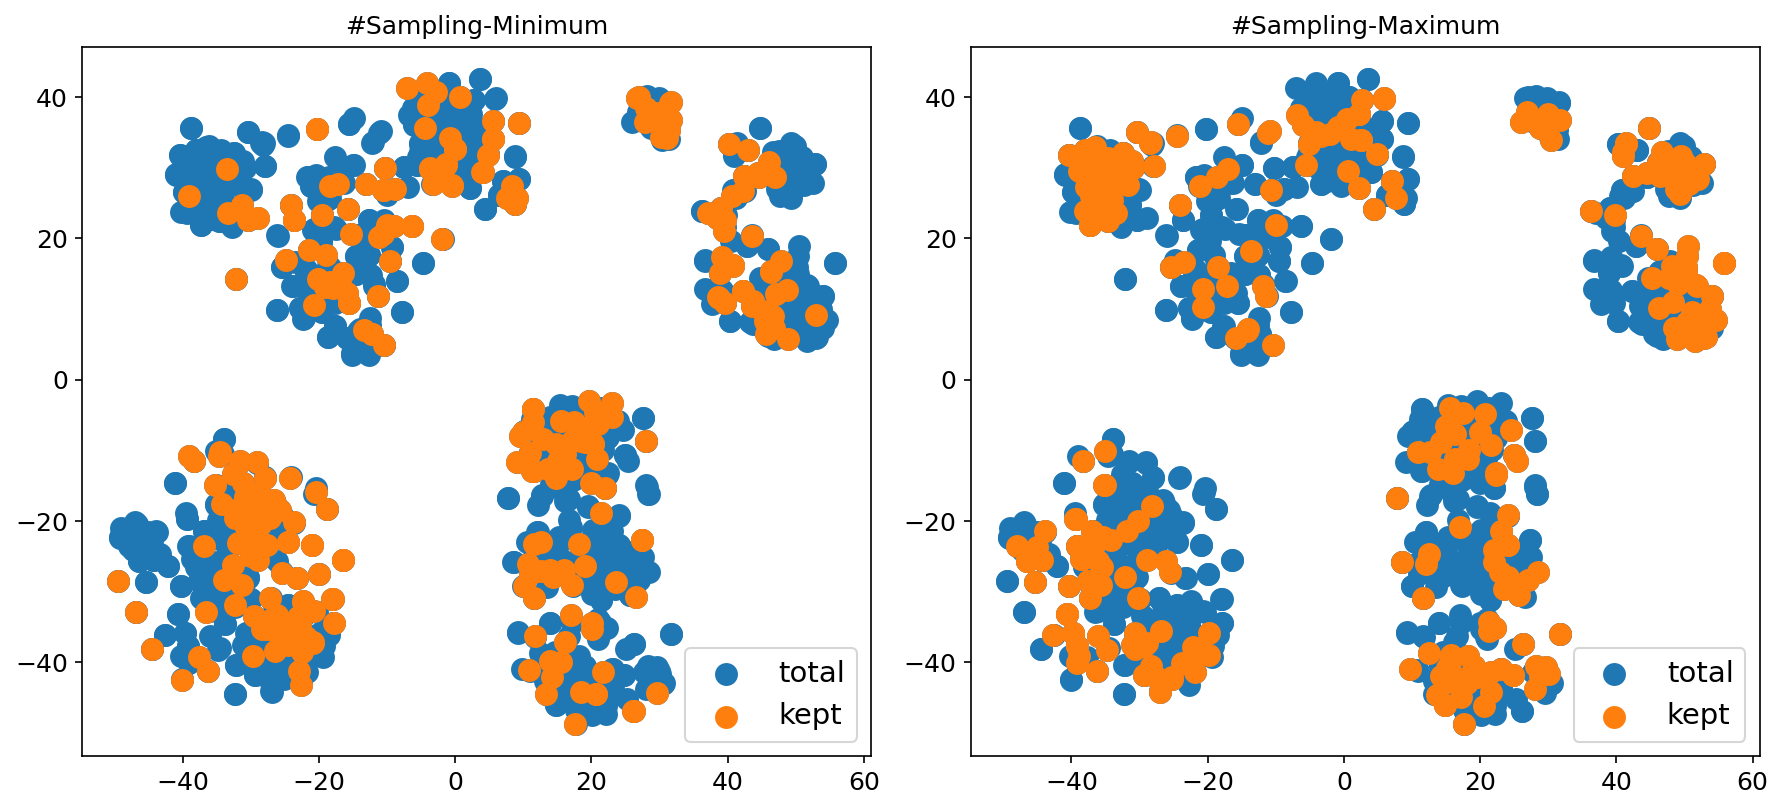

In [329]:
pdf = PdfPages('imgs/opcs/opcs_sampling.pdf')

fig = plt.figure(figsize=(12, 5.5), dpi=dpi)

ratio = 0.25
plt.subplot(1,2,1)
plt.title('#Sampling-Minimum')
for i in np.arange(1):
    # within_idx = vectors_lab == i
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    
    s = torch.softmax(torch.tensor(s).squeeze(), dim=0)
    s = s.numpy()
    
    plt.scatter(c_embedded[:, 0][within_idx],
                c_embedded[:, 1][within_idx],
                s=point_size, alpha=alpha,
                marker='o')

    s_idx = np.random.choice(np.arange(len(s)), p=s/s.sum(), 
                             size=int((1-ratio)*len(s)), replace=False)
    s_idx = np.array(list(set(np.arange(len(s))) - set(s_idx)))
    
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                s=point_size, alpha=alpha,
                marker='o')
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)        
    plt.legend(['total', 'kept'], loc=4, fontsize=legend_size)
    
    
# fig = plt.figure(figsize=(8, 8), dpi=100)
plt.subplot(1,2,2)
plt.title('#Sampling-Maximum')

for i in np.arange(1):
    
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    
    s = torch.softmax(torch.tensor(s).squeeze(), dim=0)
    s = s.numpy()
    
    plt.scatter(c_embedded[:, 0][within_idx],
                c_embedded[:, 1][within_idx],
                s=point_size, alpha=alpha,
                marker='o')

    s_idx = np.random.choice(np.arange(len(s)), p=s/s.sum(),
                             size=int(ratio*len(s)), replace=False)
    
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                s=point_size, alpha=alpha,
                marker='o')
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)        
    plt.legend(['total', 'kept'], loc=4, fontsize=legend_size)
        
plt.tight_layout()

pdf.savefig()
pdf.close()

51.285995 61.694035
51.115257 62.35341


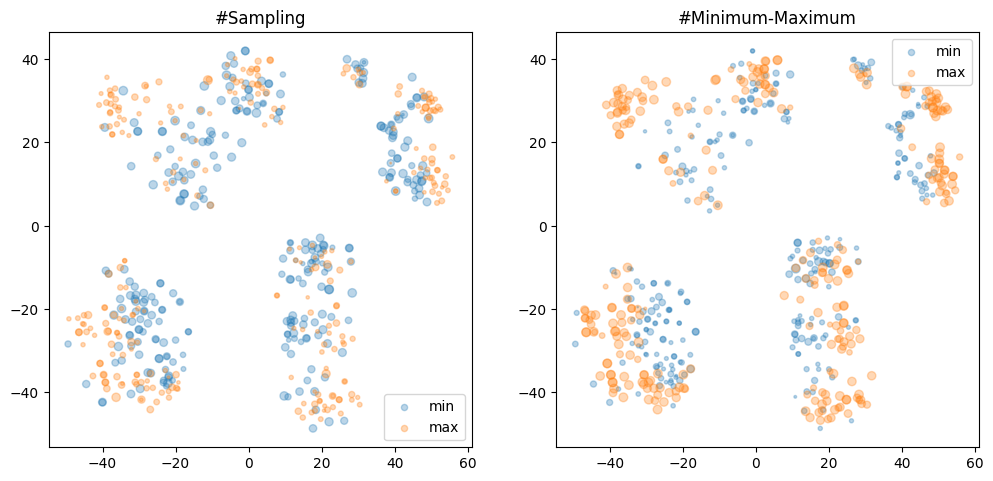

In [266]:
fig = plt.figure(figsize=(12, 5.5), dpi=100)

ratio = 0.25
plt.subplot(1,2,1)
plt.title('#Sampling')
for i in np.arange(1):
    # within_idx = vectors_lab == i
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    s -= s.min()
    
    # s_idx = np.argsort(s)[-int(ratio*len(s)):]
    s = torch.softmax(torch.tensor(s).squeeze(), dim=0)
    s = s.numpy()
    # print(len(s), s.sum())
    s_idx = np.random.choice(np.arange(len(s)), p=s/s.sum(), size=int((1-ratio)*len(s)), replace=False)
    s_idx = np.array(list(set(np.arange(len(s))) - set(s_idx)))
    
    size = np.log(s[s_idx]*200)
    size -= size.min()
    size /= size.max() * 0.025
    
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                marker='o', s=size, alpha=0.3)
    # print((s[s_idx]*200).min(), (s[s_idx]*200).max())
    # print(s[s_idx])
    
    print(c_embedded[within_idx][s_idx].std(axis=0).sum(), end = ' ')
    # s = -w.numpy()
    # s -= s.min()
    # s_idx = np.argsort(s)[:-int(ratio*len(s))]
    
    s_idx = np.random.choice(np.arange(len(s)),
                             p=s/s.sum(),
                             size=int(ratio*len(s)), replace=False)
    
    size = np.log(s[s_idx]*200)
    size -= size.min()
    size /= size.max() * 0.025
    
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                marker='o', s=size, alpha=0.3)
    
    # print((s[s_idx]*200).min(), (s[s_idx]*200).max())
    
    print(c_embedded[within_idx][s_idx].std(axis=0).sum())
    
    plt.legend(['min', 'max'])
    
    
# fig = plt.figure(figsize=(8, 8), dpi=100)
plt.subplot(1,2,2)
plt.title('#Minimum-Maximum')

for i in np.arange(1):
    # within_idx = vectors_lab == i
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    s -= s.min()
    
    size = s[s_idx]
    size -= size.min()
    size /= size.max() * 0.025

    s_idx = np.argsort(s)[:int(ratio*len(s))]
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                marker='o', s=size, alpha=0.3)
    
    print(c_embedded[within_idx][s_idx].std(axis=0).sum(), end = ' ')
    # s = -w.numpy()
    # s -= s.min()
    size = s[s_idx]
    size -= size.min()
    size /= size.max() * 0.025
    
    s_idx = np.argsort(s)[-int(ratio*len(s)):]
    plt.scatter(c_embedded[:, 0][within_idx][s_idx],
                c_embedded[:, 1][within_idx][s_idx],
                marker='o', s=size, alpha=0.3)
    
    print(c_embedded[within_idx][s_idx].std(axis=0).sum())
    
    plt.legend(['min', 'max'])

In [239]:
(s/s.sum()).numpy().sum()

1.0000001

In [252]:
stds = []
ratio = 0.25
i = 0

for j in np.arange(20):
    std = []
    # within_idx = vectors_lab == i
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    s -= s.min()
    
    s = torch.softmax(torch.tensor(s).squeeze(), dim=0).numpy()
    s_idx = np.random.choice(np.arange(len(s)), p=s/s.sum(),
                             size=int(ratio*len(s)), replace=False)

    std.append(c_embedded[within_idx][s_idx].std(axis=0).sum())

    s_idx = np.random.choice(np.arange(len(s)), p=s/s.sum(), size=int((1-ratio)*len(s)), replace=False)
    s_idx = np.array(list(set(np.arange(len(s))) - set(s_idx)))
 
    
    std.append(c_embedded[within_idx][s_idx].std(axis=0).sum())
    
    
    s_idx = np.random.choice(np.arange(len(s)),
                             size=int(ratio*len(s)), replace=False)
    std.append(c_embedded[within_idx][s_idx].std(axis=0).sum())
    
    stds.append(std)

print()

print([ f'{m:>8s}: {n:>8f}' for m,n in zip(['softmax', 'softmin', 'random'], np.mean(stds, axis=0)) ] )


for i in np.arange(1):
    std = []
    # within_idx = vectors_lab == i
    within_idx = np.arange(len(vectors_lab))
    s = w.numpy()
    s -= s.min()
    
    s_idx = np.argsort(s)[:int(ratio*len(s))]

    std.append(c_embedded[within_idx][s_idx].std(axis=0).sum())

    s_idx = np.argsort(s)[int(ratio*len(s)):]

    std.append(c_embedded[within_idx][s_idx].std(axis=0).sum())
    # print(std)
    
    print([ f'{m:>8s}: {n:>8f}' for m,n in zip(['min', 'max'], std) ] )

# [' softmax: 18.974079', ' softmin: 18.431675', '  random: 17.511234']
# ['     min: 18.978655', '     max: 17.680817']
# min > softmax >~ softmin > max > random


[' softmax: 60.787056', ' softmin: 52.044609', '  random: 56.543083']
['     min: 51.115257', '     max: 58.271492']


In [126]:
import geomloss
#geomloss.utils.squared_distances(a, b)

In [133]:
sqdist = geomloss.utils.squared_distances(x1, x2)
cosdist = cost_func(x1, x2)

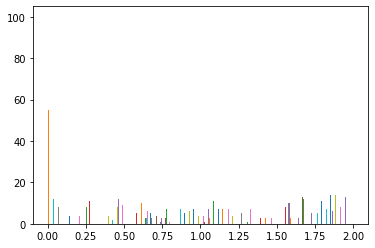

In [134]:
# _ = plt.hist(sqdist.squeeze().cpu().numpy(), bins=64)
_ = plt.hist(cosdist.squeeze().cpu().numpy(), bins=64)